In [1]:


import pandas as pd
import numpy as np
import gzip
import os
from datetime import datetime
from datetime import timedelta 
import pandas as pd
import calendar
import numpy as np
import glob
import sys
import datetime 

import re
import os
import quantstats as qs
import time

import matplotlib.pyplot as plt

import nest_asyncio # install this package to avoid running in loop

import urllib

import pandas_market_calendars as mcal

import pandas_ta as pta

qs.extend_pandas()

# import dask.dataframe as dd
# from dask.distributed import Client
from concurrent.futures import ThreadPoolExecutor

import talib


import sys
sys.path.append(r'C:\Users\Administrator\Desktop\Indian_backtester_python')

from strategy_functions import *

from fetchHistData import *
import sys
sys.path.append(r"C:\Users\Administrator\Desktop\Repos\Trade_log_equity")
from Process_trade_log_equity import *   # Import the module

#--- Input file with 15 min data

ifol = r"C:\Users\Administrator\Downloads\DATA (1)\DATA\NF_200\NF_200_Equity_parquet_30min"

stock_data = r"C:\Users\Administrator\Downloads\DATA (1)\DATA\NF_200\NF_200_Equity_parquet_30min"


strategy_name = "Aakash_Equity_Nifty_reversal"

base_folder = r"C:\Users\Administrator\Documents\ES's and trade_stats_figures"

# Create a folder for the strategy_name if it doesn't exist
strategy_folder = os.path.join(base_folder, strategy_name)
if not os.path.exists(strategy_folder):
    os.makedirs(strategy_folder)

    
    
# Create the full path to the output file. this file contains all the trades

output_all_trades_file = os.path.join(strategy_folder, f"All_trades_{strategy_name}.csv")
trade_html_file = os.path.join(strategy_folder, f"Trade_stats_{strategy_name}.html")    
    

#=== location to store the trade dataframe for debug

base_folder_df = r"C:\Users\Administrator\Documents\strategy_logs"
df_folder = os.path.join(base_folder_df, strategy_name)
if not os.path.exists(df_folder):
    os.makedirs(df_folder)

#----- symbol_wise_trades 

trades_folder = r"C:\Users\Administrator\Documents\symbol_wise_trades"
trades_strategy_folder = os.path.join(trades_folder, strategy_name)
if not os.path.exists(trades_strategy_folder):
    print("\n Making folder for symbol wise trades of strategy" , trades_strategy_folder)
    os.makedirs(trades_strategy_folder)


    

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Index(['entry_time', 'Symbol', 'Side', 'entry_price', 'exit_time',
       'exit_price', 'order'],
      dtype='object')


In [208]:
 

import numpy as np
import pandas as pd

def find_slope_and_prediction(df, column='Close', window=21):
    
    def calc_slope_intercept(y):
        if len(y) < window:
            return np.nan, np.nan
        x = np.arange(len(y))
        sum_x = np.sum(x)
        sum_y = np.sum(y)
        sum_x2 = np.sum(x**2)
        sum_xy = np.sum(x*y)
        N = len(x)

        # Calculate slope and intercept
        slope = (N * sum_xy - sum_x * sum_y) / (N * sum_x2 - sum_x**2)
        intercept = (sum_y - slope * sum_x) / N
        return slope, intercept

    # Apply the function over a rolling window and extract results
    results = df[column].rolling(window=window).apply(
        lambda y: calc_slope_intercept(y)[0], raw=True
    )

    slopes = results
    intercepts = df[column].rolling(window=window).apply(
        lambda y: calc_slope_intercept(y)[1], raw=True
    )

    # Calculate predicted value for the last point in each window
    predictions = slopes * (window - 1) + intercepts

    return slopes, predictions

# Example usage
# slopes, predictions = find_slope_and_prediction(df, 'Close', 21)


def supertrend( highcol='High' , lowcol= 'Low' , closecol = 'Close' , length=2 , multiplier=2.5):
    import pandas_ta as pta

    super_df  = pta.supertrend(highcol , lowcol , closecol , length=length , multiplier=multiplier)
    # Check if the DataFrame is empty or all values are NaN
    if super_df.empty or super_df.isnull().all().all():
        print("The DataFrame is either empty or contains only NaN values.")
        return None  # handle this as appropriate for your use case
    
    # If DataFrame is non-empty and not all NaN, return the first column
    return super_df.iloc[:, 0]


import pandas as pd
from datetime import timedelta





def bars_since_condition(df, column):
    # Calculate the cumulative sum which resets at each '1' to create group identifiers
    group_ids = (df[column] == 1).cumsum()
    
    # Use 'cumcount' to count the number of occurrences since the last reset, adding 1 to start from 1
    bars_since = df.groupby(group_ids).cumcount() 
    
    # Wherever the condition is true, reset 'bars_since' to 1
    return bars_since.where(df[column] == 0, 1)



def daily_ROC(df , column='Close' , ROC_period=3 , z_score_period=20 , highcol='High' , lowcol='Low' , closecol='Close' , opencol='Open'  , timeframe='1D' , volcol='Volume'):
    
    resamp = resample_data(df=df , highcol=highcol , lowcol=lowcol , closecol=closecol , opencol=opencol , volcol=volcol , timeframe=timeframe)
    resamp = resamp.shift(1)
    
    #print(resamp)
        
    
    resamp["ROC"] = (resamp[column] - resamp['Open'].shift(ROC_period)) / (resamp['Open'].shift(ROC_period)) * 100
    resamp["ROC_z_score"] = z_score_price(df=resamp , column='ROC' , window_size=z_score_period)
    
    resamp = resamp.reindex(df.index , method='ffill')
        
    return resamp['ROC_z_score']
    





In [209]:

def calculate_rolling_beta(df, window , stock_col = 'Close' , index_col = 'Close_index'):
    # Calculate daily returns
    
    
    
    df_copy = df.copy(deep=True)
    
    df['Stock_Returns'] = df[stock_col].pct_change()
    df['Index_Returns'] = df[index_col].pct_change()
    
    # Calculate rolling covariance of stock returns with index returns
    rolling_cov = df['Stock_Returns'].rolling(window=window).cov(df['Index_Returns'])
    
    # Calculate rolling variance of index returns
    rolling_var = df['Index_Returns'].rolling(window=window).var()
    
    # Rolling beta is the rolling covariance divided by the rolling variance
    rolling_beta = rolling_cov / rolling_var
    
    return rolling_beta

In [210]:
#"C:\Users\Administrator\Downloads\DATA (1)\DATA\index\NIFTY50\NIFTY50.csv"

#=== This section leads to nifty calculations


index_data_loc = r"C:\Users\Administrator\Downloads\DATA (1)\DATA\index\NIFTY50\NIFTY50.csv"

def process_index(indexpath , timeframe='30Min'):
       

    index_df = pd.read_csv(indexpath)
    
    if 'datetime' in index_df.columns:
    
        index_df.datetime = pd.to_datetime(index_df.datetime , format="%d-%m-%Y %H:%M")
        index_df.set_index('datetime' , inplace=True)

    #print(index_df)   

             
    index_df = index_df[(index_df.index.dayofweek<5)]
     
    ind_df = resample_data(index_df , highcol = 'High' , lowcol = 'Low' , closecol = 'Close' ,opencol = 'Open'  , volcol = 'Volume' , timeframe = '30min')


#     ind_df['indClose'] = index_df.Close.resample(timeframe).last().dropna()
#     ind_df['indHigh'] = index_df.High.resample(timeframe).max().dropna()
#     ind_df['indLow'] = index_df.Low.resample(timeframe).min().dropna()
#     ind_df['indOpen'] = index_df.Open.resample(timeframe).first().dropna()
#     ind_df['indVolume'] = index_df.Volume.resample(timeframe).sum().dropna()
    
    #print(ind_df) 
    ind_df['ind20DMA'] = daily_moving_average(df=ind_df, timeframe='D' , column='High', periods=10, agg_func='last')
        
    ind_df['indtodayo'] = ind_df.Open.groupby(ind_df.index.date).first().reindex(ind_df.index.date).values
    ind_df['indprevdayc'] = ind_df.Close.groupby(ind_df.index.date).last().shift().reindex(ind_df.index.date).values
    ind_df['indprevdayh'] = ind_df.High.groupby(ind_df.index.date).max().shift().reindex(ind_df.index.date).values
    ind_df['indprevdayo'] = ind_df.Open.groupby(ind_df.index.date).first().shift().reindex(ind_df.index.date).values
                                                      
    ind_df['near_Exp'] = get_prev_exp(ind_df.index , symbol='NIFTY')
    
    ind_df['ind_todayh'] = intraday_high(df=ind_df ,high_col= 'High' ,agg_func= 'max')
    ind_df['ind_todayl'] = intraday_low(df=ind_df ,low_col= 'Low' , agg_func='min')
            
    ind_df['indexpiry_high'] = expanding_high_since_expiry(ind_df , expiry_series='near_Exp' , column='High')
        
    ind_df['indexpiry_low'] = expanding_low_since_expiry(ind_df , expiry_series='near_Exp' , column='Low')
    
        
    ind_df['body'] = ind_df['Close'] - ind_df['Open']
    # Calculate the rolling average of the body size for the last 1 hour
    ind_df['body_avg_1h'] = abs(ind_df['body']).rolling(window=20).mean()

    # Create a boolean column that is True for negative candles
    ind_df['negative_candle'] = ind_df['body'] < 0

    ind_df['positive_candle'] = ind_df['body'] > 0

    # Check if the current negative candle's body is more than twice the average of the last 1 hour
    ind_df['big_rise'] = (ind_df['positive_candle']) & (ind_df['body'].abs() > 2.5 * ind_df['body_avg_1h'])
    ind_df['big_fall'] = (ind_df['negative_candle']) & (ind_df['body'].abs() > 1.5 * ind_df['body_avg_1h'])
    
    ind_df['all_time_high'] = ind_df['Close'].expanding().max()
    
    
    ind_df = ind_df[(ind_df.index.year>=2019) & (ind_df.index.year<2024)]
    
    
    
    #ind_df = ind_df.reindex(combined_df.index, method='ffill')
            
    return ind_df
    




In [211]:
ind_df = process_index(index_data_loc , timeframe='30Min')
ind_df = ind_df.rename(columns={
    'Open': 'indOpen',
    'High': 'indHigh',
    'Low': 'indLow',
    'Close': 'indClose',
    # Add other column mappings if necessary
})

OperationalError: connection to server at "13.233.195.173", port 8812 failed: Connection timed out (0x0000274C/10060)
	Is the server running on that host and accepting TCP/IP connections?


In [169]:
ind_df[[ 'indOpen', 'indClose' , 'big_rise' , 'big_fall' , 'all_time_high']]

,indOpen,indClose,big_rise,big_fall,all_time_high
datetime,,,,,
2019-01-01 09:15:00,10881.70,10843.80,False,True,11749.20
2019-01-01 09:45:00,10843.80,10826.45,False,True,11749.20
2019-01-01 10:15:00,10826.40,10830.95,False,False,11749.20
2019-01-01 10:45:00,10830.85,10839.35,False,False,11749.20
2019-01-01 11:15:00,10839.25,10834.30,False,False,11749.20
...,...,...,...,...,...
2022-12-20 13:15:00,18260.55,18275.70,False,False,18868.10
2022-12-20 13:45:00,18274.85,18298.85,False,False,18868.10
2022-12-20 14:15:00,18299.00,18331.70,False,False,18868.10


In [ ]:
def process_symbol(file_path , index=ind_df):
    
    fname = os.path.basename(file_path).split('.')[0]
    
    print("\n Processing ", fname)
    
    df = pd.read_parquet(file_path, engine='fastparquet')
    
    #df['first_hr_high'] =  x_min_high(df , 'High' , start='09:30' , end='11:00' )
   # df['cval'] = x_min_cum_vol(df , 'Volume' , start='09:30' , end=rank_time)
    df['x_day_low'] = get_x_day_low(df, n=10 , column='Close')
    df['x_day_high'] = get_x_day_high(df , n=20 , column='High')
    #df['m_low'] = get_x_day_low(df , n=40 , column='Close')
    #df['low_touch'] = np.where(df['Close']<df['x_day_low'].shift() , 1 , 0)
    
    #df[fname+'_ratio'] = df['cval']/df['D_Volume_moving_average']
    #df['bars_since_low'] = bars_since_condition(df , column='low_touch')
    
    
    df['5drng'] = get_x_day_range(df , n=5, high_col='High' , low_col='Low')
    
    df['20DMA'] = daily_moving_average(df , 'D' , 'Close' , periods=5 , agg_func='last')
    
    #df[fname+'_ratio'] = df['cval']/df['D_Volume_moving_average']
        
    df['todayo'] = df.resample('D').Open.first().dropna().reindex(df.index.date).values
    df['prevdayc'] = df.Close.groupby(df.index.date).last().shift().reindex(df.index.date).values
    df['ratio_co'] = df['Close']/(df[['todayo', 'prevdayc']].max(axis=1))
    df['prevdayl'] = df.Low.groupby(df.index.date).min().shift().reindex(df.index.date).values
    df['prevdayh'] = df.High.groupby(df.index.date).max().shift().reindex(df.index.date).values
    df['prevdayo'] = df.Open.groupby(df.index.date).first().shift().reindex(df.index.date).values
    df['all_time_shigh'] = df['Close'].expanding().max()
    
    #df['slope'] = find_slope_and_prediction(df , 'Low' , window=100)[0]
    df['vwap'] = intraday_vwap(df)
    
#     df['ATR'] = ATR(highcol=df['High'] , lowcol=df['Low'] , closecol=df['Close'] , length=7 , percent=False , mamode='WMA')
#     df['ATR_zc'] = z_score_price(df ,  'ATR' , window_size=3)
#     df['z_score'] = z_score_price(df , column='High' , window_size=13)
    
    
    #=== Find ATR and z-score of ATR
#     df['ATR'] = ATR(highcol=df['High'] , lowcol=df['Low'] , closecol=df['Close'] , length=14 , percent=False , mamode='WMA')
#     df['ATR_zc'] = z_score_price(df ,  'ATR' , window_size=50)
    
    #df['last_trough'] = find_trough_multi_tf(df , column='Low' , threshold=0.25, distance=5 , timeframe='1D')
        
    
    df = pivot_points_classic(df)
    
    df['todayl'] = intraday_low(df=df , low_col='Low' , agg_func='min')
    df['todayh'] = intraday_high(df=df , high_col='High' , agg_func='max')
    df['daily_RSI'] = rsi_timeframe(df ,period=7 , timeframe='1D' )
    df['zc_ROC'] = daily_ROC(df , column='Close' , ROC_period=3 , z_score_period=40)
    df = df[(df.index.year>=2019) & (df.index.year<2023)]
    #print("\n" , df.columns)
    
    #====== Index based conditions in any
        
    #===== First reindex the index to df
    index = index.reindex(df.index, method='ffill')
    
    df = pd.concat([df, ind_df], axis=1)
    
    #======= Concat the ranks for each symbol
    
#     rank = comb_ranks[f'{fname}_rank_param']
#     rank = rank.reindex(df.index , method=None)
#     df[f'{fname}_rank_param'] = rank
    
                  
                    
    #print(  "\n Concated df with index is : " , df)
    
    #df['int_indHigh'] = intraday_high(df=df , high_col='indHigh' , agg_func=)
    
    #=== Long conditions
    # df['ratio_co']>1.005 
    
    condition1 = df.index.time>datetime.time(10 , 15) 
    condition2 = df["indprevdayc"]>df["indprevdayo"]*0.985    #df['Close']>df['x_day_high'] - (0.5*(df['x_day_high']-df['x_day_low']))
    #condition3 = df['Close']<df['R1']
    #condition4 = df['ATR_zc']<=-1
    #condition5 = df['indLow']<df['ind20DMA']
    condition6 = df['prevdayc']>df['prevdayo']*0.98
    #condition7 = df['todayo']>df['m_low']*1.03
    condition8 = df['Close']>df['vwap']
    condition9 = df['Close']>=df['prevdayl']*1.001
    condition10 = df.index.time<=datetime.time(14 , 15)
    condition11 = df['todayo']>df['S1']
    condition12 = df['indtodayo']>df['indprevdayc']*0.998  # much better than opposite
    condition13 = df['indClose']>df['ind_todayl']*1.001
    #condition14 = df['ATR_zc']>=-1
    #condition15 = df['todayo']<df['prevdayh']*1.01
    condition17 = df['Close']>df['R1']*0.99
    condition18 = df['big_rise']>0
    #condition19 = df[f'{fname}_rank_param']<50
    
    #=== price goes below S2 but now above S1
    df['S1_reclaim'] = np.where(((df['todayl']<df['R1']*1.002) & (df['Close']>df['R1'].shift()))  , 1 , 0)
    condition16 = df['S1_reclaim']>=1
    
    ofol = df_folder
    ofil = os.path.join(ofol , f'{fname}.csv')
    #print(ofil)
    df.to_csv(ofil)
    
    #df['prevdayc']<df['prevdayo']*1.02 not helping
    #condition14 = df['todayl']>df["last_trough"]*1.01
    #condition14 = df['Close']<df['R2']
    
    #& condition13 is gud
    
    #=== df['Close']>df['first_hr_high'].shift(1) not helping
    #== df['Close']>df['x_day_high'] - (0.25*(df['x_day_high']-df['x_day_low'])) not helping
    #=== 20 dma index MA not helping
    
    # & condition10 trying.. not thta help
    #=== short conditions
    
    # & condition3
    # & condition6
    # & condition14 - df['slope']>0 not helping
    # ATR_zc bad
    # & condition14  & condition10  & condition12  & condition5 & condition7  & condition11
    
    # & condition17
    #& condition15 slight gud
    df['signal'] = condition1 & condition10 & condition18 & condition2 & condition12  & condition13 & condition17     
        
    #print("\n Mean of symbol is " , df['Close'].mean())
    
    # Compute the final result and return it as a pandas DataFrame
    return df , fname
    


In [213]:
def process_signal(df, side=1 , intra_Exit=0 , n_day_Exit=2, symbol=None ):
    
    #================================================================================================
    if symbol is None:
        raise ValueError("Symbol must be provided")
    
    print("\nProcessing signals of", symbol)
    log = []
    bar_counts = [0] * len(df)
    positions = [0]* len(df)
    position = 0
    day_count = 0
    entry_price = 0 
    exit_price = 0 
    ordern = 0 
    orders = [0]*len(df)
    highest_high = 0
    all_time_breach = 0
    bars_since_all_high = 0
    nifty_breach= 0
    bars_since_stock_high = 0
    bars_since_stock_high = 0
    all_time_sbreach = 0
    stock_breach = 0 
    # Compute date changes using diff()
    #df['date_changed'] = df.index.to_series().diff().dt.days != 0
    
        # Ensure your index is a DateTimeIndex and sorted.
    df['date_changed'] = df.index.to_series().dt.date != df.index.to_series().shift(1).dt.date
    
    #================================================================================================
   
        
    for i in range(len(df)):
        
        row = df.iloc[i]
        current_date = df.index[i].date()
        current_time = df.index[i].time()
        
        
        # If in a position, increment the bar count
        if position != 0:
                        
            #df.loc[i, 'bar_count'] = df.loc[i - 1, 'bar_count'] + 1  # increment bar_count in df
            bar_counts[i] = bar_counts[i-1] + 1
            
            if row['date_changed']:
                #print("the date changed")
                day_count += 1
                                           
            else:
                day_count = day_count
        else:
            #bar_count = 0
            #df.loc[i, 'bar_count'] = 0 
            bar_counts[i] =0 
            ordern = 0 
            day_count = 0
            entry_price = 0
        
        #--- n-day exit at first bar....
        
        highest_high = row['High'] if position > 0 and row['High'] > highest_high else highest_high if position > 0 else 0
        lowest_along = row['Low'] if position > 0 and row['Low'] < lowest_along else lowest_along if position > 0 else 0
        
        
        
        if df['indClose'][i] > df['all_time_high'][i-1] and current_time >= datetime.time(9, 30) and all_time_breach == 0:
            
            all_time_breach = 1
            nifty_breach = df['indClose'][i]
            bars_since_all_high = 1  # Reset the counter since new all-time high is breached
            
            
            
            
        
        
        elif all_time_breach == 1:
            bars_since_all_high += 1  # Increment the counter for each bar after breach

        
        
            # Reset bars_since_all_high and all_time_breach if bars_since_all_high exceeds 50
        if bars_since_all_high > 50:
            bars_since_all_high = 0
            all_time_breach = 0

        
        #=== stock breaks all time high
        
        if df['Close'][i]>df["all_time_shigh"][i-1] and current_time > datetime.time(9, 15) and all_time_sbreach ==0:
            
            all_time_sbreach = 1
            stock_breach = df['Close'][i]
            bars_since_stock_high = 1  # Reset the counter since new all-time high is breached
        
        elif all_time_sbreach==1:
            
            bars_since_stock_high+=1
        
        
        if bars_since_stock_high > 50:
            bars_since_stock_high = 0
            all_time_sbreach = 0
        
        
            
        #print("\n" , df['Close'][i] , df['all_time_shigh'][i-1] , "bars  " ,bars_since_stock_high )
        
        #=== First long on a rise of nifty
        
#         if (( df['signal'][i-1]==1 or df['signal'][i]==1  ) and position == 0 and df['Close'][i]>df['todayo'][i]*1.005  and df['Close'][i]>df['Close'][i-1] and df['indClose'][i]>df['indtodayo'][i]*0.995) :
#             # Determine if it's a long or short entry
#             if side > 0:
#                 position = 1
#                 entry_price = row['Close']
#                 ordern = 1                 
#                 print("\n Position taken long at : " , df.index[i] , "-- entry Price - :  " , entry_price , "position: " , position , " today open : "  , df['todayo'][i])
#                 log.append((df.index[i], symbol, position , entry_price , ordern))
#                 #print("\n" , df['5drng'][i])
#             else:
#                 position = -1
#                 entry_price = row['Close']
#                 ordern = -1 
#                 #print("\n Position taken Short at : " , df.index[i] , "-- entry Price - :  " , entry_price)
#                 log.append((df.index[i], symbol, position , entry_price, ordern))
        
        
        #--- second signal where we 
        
        if (bars_since_stock_high>2 and position == 0 and df['Close'][i]>df['R1'][i]*0.995 and df['Close'][i]>df['todayo'][i]*1.005   and df['indClose'][i]>df['indtodayo'][i]*0.995) :
            #print("\n Hii")
            
            if side > 0:
                position = 1
                entry_price = row['Close']
                ordern = 1
                bar_counts[i]+=1
                print("\n Position taken long at : " , df.index[i] , "-- entry Price - :  " , entry_price , "position: " , position , " today open : "  , df['todayo'][i])
                log.append((df.index[i], symbol, position , entry_price , ordern))
                #print("\n" , df['5drng'][i])
            
            
        
        
        if position == 1 and row['Close'] < min(df['prevdayl'][i]*1.00 ,df['todayl'][i-1]*1.005) and bar_counts[i]>=2:
            
            #print("\n Position Hit stop " , df.index[i] , position , "position at  ", row['Close'] )
            position = 0
            #bar_counts[i] = 0
            exit_price = row['Close']
            ordern = 2
            log.append((df.index[i], symbol, position , row['Close'], ordern))

        
        
        # End of Day Exit condition based on parameter intra_exit
        
        #print("position " ,position , df['bar_count'][i])
        
        if position != 0 and intra_Exit==1 and df.index[i].time() >= datetime.time(15, 5) and bar_counts[i] > 1:
            
            #print("Hi")
            #print("\n Position exit EOD long at" , df.index[i] , position , "position at  ", row['Close'] )
            
            position = 0
           
            exit_price = row['Close']
            ordern = 3 
            log.append((df.index[i], symbol, position , row['Close']))
        
        
        if position != 0 and bar_counts[i]>4 and df['indClose'][i]<df["indOpen"][i]*1.001 and df['High'][i]>df['High'][i-1]*1.03:
            
            #print("Hi")
            #print("\n Nifty bear exit at: " , df.index[i] ,"Nifty high and highest are:  "  ,df['indHigh'][i] , df['ind_todayh'][i-1]  )
            
            position = 0
           
            exit_price = row['Close']
            ordern = 4 
            log.append((df.index[i], symbol, position , row['Close']))
                       
                
        if position > 0 and day_count>=1 and bar_counts[i]>6 and df['Close'][i]<df['prevdayl'][i]*0.99 and df['Close'][i]<df['Close'][i-1] :
            #print("\n Gap down exit EOD long at" , df.index[i] , position , "position at  ", row['Close'] , "Day_count: " , day_count , "close: " , df['Close'][i] , df['Close'][i-1] )
        
            position = 0
            
            exit_price = row['Close']
            ordern = 5
            log.append((df.index[i], symbol, position , row['Close'], ordern))
        
        if position > 0 and day_count>=1 and bar_counts[i]>3 and df['Close'][i]<df['Open'][i]*0.985  :
            #print("\n Large bear bar" , df.index[i]  , "Day_count: " , day_count , "close: " , df['Close'][i] , df['Open'][i] )
        
            position = 0
            
            exit_price = row['Close']
            ordern = 6
            log.append((df.index[i], symbol, position , row['Close'], ordern))
                
        
        if position != 0 and intra_Exit==0 and day_count>=n_day_Exit and bar_counts[i]>1 and df['Close'][i]<df['Close'][i-1]  :
            
            #print("\n Carryforward exit EOD long at" , df.index[i] , position , "position at  ", row['Close'] , "Day_count: " , day_count )
            
            position = 0
            
            exit_price = row['Close']
            ordern = 7
            log.append((df.index[i], symbol, position , row['Close'], ordern))
                
        
        #---- Stop-loss of 3%
        
        if position!=0 and df['todayo'][i]<df['x_day_low'][i] and df['Close'][i]<df['Low'][i-1] and day_count>=1 and df.index[i].time()>=datetime.time(10 , 45):
            
            position = 0
            
            exit_price = row['Close']
            ordern = 8
            log.append((df.index[i], symbol, position , row['Close'], ordern))
            
            #print("\nBreakdown opening exit from low:  " , df['x_day_low'][i] ,   " -- open at" , df['todayo'][i])
        
        if position!=0 and df['High'][i]<df['S1'][i-1] and df['Close'][i]<df['Close'][i-1] and day_count>=1 and df.index[i].time()>=datetime.time(10 , 45):
            
            position = 0
            
            exit_price = row['Close']
            ordern = 9
            log.append((df.index[i], symbol, position , row['Close'], ordern))
    
        
        
        #=== exit of open==high of the day
        
#         if position>0 and day_count>=3  and df['close'][i]>=df['prevdayh'][i]*1.01 and df.index[i].time()>=datetime.time(10 , 00):
            
#             position = 0
#             bar_counts[i] = 0
#             exit_price = row['Close']
#             ordern = 10
#             log.append((df.index[i], symbol, position , row['Close'], ordern))
            
#             #print("\n reversal from low:  " ,df['prevdayh'][i],   " -- open at" , df['todayo'][i] , "reversal at: " , df['prevdayc'][i] )
        
        
        
    
        #----- 5drnag exit
        
        if position == 1 and row['Close'] > entry_price*(1+(1.75*df['5drng'][i])) and df['Close'][i]>df['Close'][i-1] and bar_counts[i]>10:
            
            #print("\n Range target  " , df.index[i] , "at  ", row['Close'] , " range: " , df['5drng'][i] , "entryprice" , entry_price )
            position = 0
            bar_counts[i] = 0
            ordern = 15
            log.append((df.index[i], symbol, position , row['Close'], ordern))
        
         #----- reistance exit
        
        if position >0 and df['Close'][i-1]>df['R2'][i-1]*1.01 and df['Close'][i]<df['R2'][i-1]*1.01 and bar_counts[i]>5 and df.index[i].time() >= datetime.time(9, 30):
            
            #print("\n Resistance target  " , df.index[i] , "at  ", row['Close'] , " R2 prev: " , df['R2'][i-1] , "entryprice" , entry_price )
            position = 0
            bar_counts[i] = 0
            ordern = 16
            log.append((df.index[i], symbol, position , row['Close'], ordern))
        
   
    
    #print("\n Position at last bar is " , positions[-1]   )
    
    
        positions[i] = position
        orders[i] = ordern

    
    df[symbol+'bar_count'] = bar_counts
    df[symbol+'_order'] = orders
    df[symbol+'_position'] = positions
    
    #== these are bar-by-bar returns when you are in position 
    df[symbol+'_ret'] = np.where(df[symbol+'bar_count']>0 ,  df['Close'].pct_change()*side , 0)
    
    
    #=== 
    df[symbol+'_Close'] = df['Close']

    trade_log = create_tradelog(df , Symbol=symbol)


#     if( num_entries!=num_exits):

#         print("\n \n Number of entries and exits dont match"  , "Entries: " , num_entries , "----- Exits" , num_exits  )

    file_path = os.path.join(trades_strategy_folder, f"{symbol}.csv")
    trade_log.to_csv(file_path )

        
    
    return df[[symbol+'_Close' , symbol+'_position' ,symbol+'_ret' , symbol+'bar_count', symbol+'_order']] 


In [202]:
#=== Code to group the symbol dataframe by positions.. ie each group is a trade
#--- helps in finding all the trades( entry  , exit)

def create_tradelog(df , Symbol=None ):
    
    
    """
    This function groups the positions into a dataframe for each symbol and returns the trade_log.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with Close and position , order and bar-by-bar returns
                             

    Returns:
    pandas.dataframe: A dataframe with each trade in format 
                      : Symbol	Side	EntryPrice	Stop Loss	Time of Entry	Time of Exit	Exit Reason	inposition	Exit Price

    """
  
    
     # Check if DataFrame is empty
    if df.empty:
        print("DataFrame is empty. No data to process.")
        return pd.DataFrame()  # Return an empty DataFrame

    
    print("\nSymbol passed to trade log: " , Symbol , "\n\n")
    
    
    #df.set_index('entry_time', inplace=True)

    
    
    # Assuming 'df' is your DataFrame with the columns 'A_Close', 'A_position', and 'A_ret'.

    # Detect changes in 'A_position'
    if Symbol+'_position' in df.columns:
        df['position_change'] = df[Symbol+'_position'].diff()
    
    else:
        print("\n Position column ( 1 , 0 , -1) missing in dataframe please check")
        
        
    # Assign a group number to each sequence of 1's
    df['group'] = (df['position_change'] == 1).cumsum()

    # Filter out the rows where 'A_position' is not 1
    df_positions_1 = df[df[Symbol+'_position'] == 1]
    
    if df_positions_1.empty:
        print(f"No trade entries found for symbol {Symbol}.")
        return pd.DataFrame()
    
    # Now you can group by the 'group' column
    grouped = df_positions_1.groupby('group')

    # If you want to see the groups

    # Initialize a list to store your results
    trade_returns = []

    for name, group in grouped:
        #print(f"Group {name}:")
        #print(group)

        start_price = group[Symbol+'_Close'].iloc[0]
        end_price = group[Symbol+'_Close'].iloc[-1]
        trade_return = end_price / start_price - 1
        start_time = group.index[0]
        end_time = group.index[-1]
        exit_order = group[Symbol+'_order'].iloc[-1]
        # Assume the position is consistent within the group and take the first one
        position = group[Symbol+'_position'].iloc[0]
        side = 'long' if position == 1 else 'Short' if position == -1 else 'flat'

        
        
        trade_returns.append({
            'Symbol': Symbol,
            'Side': side,
            'entry_time': start_time,
            'entry_price': start_price,
            'exit_time': end_time, 
            'exit_price': end_price,
            'order' : exit_order
        })

        
    # Convert the list of dictionaries to a DataFrame
    trade_returns_df = pd.DataFrame(trade_returns)
    #print("\nThe trade log is" , trade_returns_df)
    if not trade_returns_df.empty:
        trade_returns_df.set_index('entry_time', inplace=True)
    return trade_returns_df
    

In [203]:
def strategy_function(file_path):
    
    df,symbol = process_symbol(file_path , index=ind_df)
        
    cdf  = process_signal(df ,  side=1 , intra_Exit=0 , n_day_Exit=1,  symbol=symbol)    
    
    return cdf

In [197]:
df2 = strategy_function(r"C:\Users\Administrator\Downloads\DATA (1)\DATA\NF_200\NF_200_Equity_parquet_30min\LT.csv.parquet")



 Processing  LT


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of LT

 Position taken long at :  2019-01-07 10:15:00 -- entry Price - :   1404.9 position:  1  today open :  1397.0

 Position taken long at :  2019-05-20 14:15:00 -- entry Price - :   1448.0 position:  1  today open :  1400.0

 Position taken long at :  2019-05-22 11:15:00 -- entry Price - :   1466.15 position:  1  today open :  1450.1

 Position taken long at :  2019-05-23 09:45:00 -- entry Price - :   1522.6 position:  1  today open :  1476.2

 Position taken long at :  2019-05-27 10:15:00 -- entry Price - :   1573.75 position:  1  today open :  1543.7

 Position taken long at :  2021-07-19 10:45:00 -- entry Price - :   1633.7 position:  1  today open :  1600.0

 Position taken long at :  2021-07-22 10:45:00 -- entry Price - :   1621.85 position:  1  today open :  1610.0

 Position taken long at :  2021-08-13 11:15:00 -- entry Price - :   1657.65 position:  1  today open :  1626.0

 Position taken long at :  2021-08-13 14:45:00 -- entry Price - :   1670.0 positi

In [204]:

if __name__ == '__main__':
    if os.path.exists(stock_data):
        file_paths = glob.glob(stock_data + "/*.parquet")

        # Use ThreadPoolExecutor to process multiple files in parallel
        num_cores = os.cpu_count()
        with ThreadPoolExecutor(max_workers=num_cores) as executor:
            dataframes = list(executor.map(strategy_function, file_paths))

        # Do something with the results, e.g., concatenate them into a single DataFrame
        combined_df = pd.concat(dataframes , axis=1 , join='outer')
        
       
        
         


 Processing  AARTIIND

 Processing  ABCAPITAL

 Processing  ABFRL

 Processing  ACC


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of ACC

 Position taken long at :  2019-03-05 14:15:00 -- entry Price - :   1526.9 position:  1  today open :  1481.7

 Position taken long at :  2019-03-06 10:45:00 -- entry Price - :   1552.7 position:  1  today open :  1533.0

 Position taken long at :  2019-03-07 10:45:00 -- entry Price - :   1560.25 position:  1  today open :  1550.0

 Position taken long at :  2019-03-08 11:15:00 -- entry Price - :   1567.35 position:  1  today open :  1555.15

 Position taken long at :  2019-03-11 11:45:00 -- entry Price - :   1584.75 position:  1  today open :  1575.9

 Position taken long at :  2019-03-12 11:15:00 -- entry Price - :   1622.6 position:  1  today open :  1612.5

 Position taken long at :  2019-03-29 14:15:00 -- entry Price - :   1637.0 position:  1  today open :  1623.0

Processing signals of AARTIIND

 Position taken long at : 
 Position taken long at :  2019-04-16 12:45:00 -- entry Price - :   1700.05 position:  1  today open :  1680.0
 2019-01-04 09:45:00 


 Position taken long at :  2021-07-19 09:45:00 -- entry Price - :   2136.95 position:  1  today open :  2117.9

 Position taken long at :  2021-07-20 09:45:00 -- entry Price - :   2275.95 position:  1  today open :  2226.0

 Position taken long at :  2021-07-23 10:45:00 -- entry Price - :   2356.5 position:  1  today open :  2296.15

 Position taken long at :  2021-07-26 14:45:00 -- entry Price - :   2368.55 position:  1  today open :  2337.3

 Position taken long at :  2021-01-04 13:45:00 -- entry Price - :   639.25 position:  1  today open :  631.5

 Position taken long at :  2021-07-27 10:15:00 -- entry Price - :   2389.5 position:  1  today open :  2371.0

 Position taken long at :  2021-01-05 10:45:00 -- entry Price - :   648.47 position:  1  today open :  639.5

 Position taken long at :  2021-07-28 14:45:00 -- entry Price - :   2393.4 position:  1  today open :  2369.0

 Position taken long at :  2021-07-30 12:15:00 -- entry Price - :   2406.05 position:  1  today open :  2365.

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of ADANIENT

 Position taken long at :  2019-05-23 10:15:00 -- entry Price - :   180.0 position:  1  today open :  169.5

 Position taken long at :  2019-10-29 10:15:00 -- entry Price - :   187.5 position:  1  today open :  182.8

 Position taken long at :  2019-10-31 09:45:00 -- entry Price - :   198.2 position:  1  today open :  196.7

 Position taken long at :  2019-11-01 13:45:00 -- entry Price - :   200.0 position:  1  today open :  199.0

 Position taken long at :  2019-11-06 11:45:00 -- entry Price - :   201.7 position:  1  today open :  199.0

 Position taken long at :  2019-11-25 14:15:00 -- entry Price - :   214.65 position:  1  today open :  201.9

 Position taken long at :  2019-11-28 09:45:00 -- entry Price - :   214.3 position:  1  today open :  212.8

 Position taken long at :  2020-01-16 13:15:00 -- entry Price - :   221.1 position:  1  today open :  217.7

 Position taken long at :  2020-01-17 10:45:00 -- entry Price - :   224.7 position:  1  today 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-02-11 09:15:00 -- entry Price - :   246.6 position:  1  today open :  245.2

 Position taken long at :  2020-02-12 10:15:00 -- entry Price - :   248.5 position:  1  today open :  245.9

 Position taken long at :  2020-02-13 10:45:00 -- entry Price - :   251.25 position:  1  today open :  249.8

 Position taken long at :  2020-02-19 09:15:00 -- entry Price - :   251.8 position:  1  today open :  250.0

 Position taken long at :  2020-02-20 11:45:00 -- entry Price - :   256.5 position:  1  today open :  253.2


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-08-25 11:45:00 -- entry Price - :   264.3 position:  1  today open :  252.0

 Position taken long at :  2020-08-25 14:45:00 -- entry Price - :   304.25 position:  1  today open :  252.0

 Position taken long at :  2020-08-28 10:45:00 -- entry Price - :   294.0 position:  1  today open :  289.0

 Position taken long at :  2020-09-02 14:15:00 -- entry Price - :   299.25 position:  1  today open :  283.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-10-05 12:15:00 -- entry Price - :   317.0 position:  1  today open :  311.5

 Position taken long at :  2020-10-07 10:15:00 -- entry Price - :   333.1 position:  1  today open :  325.15

 Position taken long at :  2020-10-30 10:15:00 -- entry Price - :   342.45 position:  1  today open :  331.05

 Position taken long at :  2020-11-03 10:15:00 -- entry Price - :   346.3 position:  1  today open :  344.0

 Position taken long at :  2020-11-04 14:15:00 -- entry Price - :   358.0 position:  1  today open :  342.6

 Position taken long at :  2020-11-09 12:15:00 -- entry Price - :   362.1 position:  1  today open :  354.0

 Position taken long at :  2020-11-11 09:15:00 -- entry Price - :   362.05 position:  1  today open :  359.2

 Position taken long at :  2020-11-12 10:15:00 -- entry Price - :   366.05 position:  1  today open :  358.2

 Position taken long at :  2020-11-13 10:15:00 -- entry Price - :   369.25 position:  1  today open :  364.0

 Position ta

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-11-20 09:45:00 -- entry Price - :   394.3 position:  1  today open :  385.1

 Position taken long at :  2020-11-23 15:15:00 -- entry Price - :   406.95 position:  1  today open :  390.1

 Position taken long at :  2020-12-01 13:15:00 -- entry Price - :   419.0 position:  1  today open :  398.0

 Position taken long at :  2020-12-02 12:15:00 -- entry Price - :   441.7 position:  1  today open :  420.55

 Position taken long at :  2020-12-04 09:15:00 -- entry Price - :   453.85 position:  1  today open :  449.0

 Position taken long at :  2020-12-15 15:15:00 -- entry Price - :   462.2 position:  1  today open :  455.5

 Position taken long at :  2020-12-17 09:15:00 -- entry Price - :   469.5 position:  1  today open :  463.4

 Position taken long at :  2020-12-24 11:15:00 -- entry Price - :   472.15 position:  1  today open :  465.0

 Position taken long at :  2020-12-28 10:45:00 -- entry Price - :   494.75 position:  1  today open :  473.0

 Position tak


 Position taken long at :  2020-01-07 09:15:00 -- entry Price - :   210.6 position:  1  today open :  208.0

 Position taken long at :  2022-03-28 15:15:00 -- entry Price - :   1910.0 position:  1  today open :  1876.9

 Position taken long at :  2022-03-30 09:45:00 -- entry Price - :   1940.3 position:  1  today open :  1927.7

 Position taken long at :  2022-04-01 12:15:00 -- entry Price - :   2032.65 position:  1  today open :  2018.0

 Position taken long at :  2022-04-04 10:45:00 -- entry Price - :   2060.5 position:  1  today open :  2050.0

 Position taken long at :  2022-04-05 11:15:00 -- entry Price - :   2115.15 position:  1  today open :  2078.0

 Position taken long at :  2022-04-07 09:15:00 -- entry Price - :   2203.0 position:  1  today open :  2165.95

 Position taken long at :  2022-04-18 14:15:00 -- entry Price - :   2220.5 position:  1  today open :  2179.8

 Position taken long at :  2022-04-21 12:15:00 -- entry Price - :   2263.35 position:  1  today open :  2216.0


 Position taken long at :  2019-10-15 10:15:00 -- entry Price - :   245.0 position:  1  today open :  235.0

 Position taken long at :  2019-10-15 14:15:00 -- entry Price - :   239.2 position:  1  today open :  235.0

 Position taken long at :  2019-10-18 09:15:00 -- entry Price - :   238.1 position:  1  today open :  234.45

 Position taken long at :  2019-10-23 10:45:00 -- entry Price - :   266.85 position:  1  today open :  255.8

 Position taken long at :  2019-10-31 12:45:00 -- entry Price - :   272.9 position:  1  today open :  265.0

 Position taken long at :  2019-11-01 10:45:00 -- entry Price - :   283.95 position:  1  today open :  276.65

 Position taken long at :  2019-11-04 14:45:00 -- entry Price - :   283.5 position:  1  today open :  277.85

 Position taken long at :  2019-11-05 10:15:00 -- entry Price - :   288.95 position:  1  today open :  286.7

 Position taken long at :  2019-11-07 12:45:00 -- entry Price - :   289.0 position:  1  today open :  283.8

 Position ta


 Position taken long at :  2021-02-11 09:15:00 -- entry Price - :   578.65 position:  1  today open :  564.0

 Position taken long at :  2021-02-12 13:15:00 -- entry Price - :   616.4 position:  1  today open :  593.5

 Position taken long at :  2021-02-15 10:15:00 -- entry Price - :   666.5 position:  1  today open :  629.1

 Position taken long at :  2021-02-16 10:15:00 -- entry Price - :   730.9 position:  1  today open :  690.0

 Position taken long at :  2021-02-16 15:15:00 -- entry Price - :   766.8 position:  1  today open :  690.0

 Position taken long at :  2021-02-17 11:15:00 -- entry Price - :   805.5 position:  1  today open :  767.0

 Position taken long at :  2021-03-03 10:15:00 -- entry Price - :   828.9 position:  1  today open :  788.85

 Position taken long at :  2021-03-03 15:15:00 -- entry Price - :   829.0 position:  1  today open :  788.85

Symbol passed to trade log:  ADANIGREEN 



 Position taken long at :  2021-03-30 10:15:00 -- entry Price - :   901.45 posit

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of AJANTPHARM

 Position taken long at :  2019-01-23 10:45:00 -- entry Price - :   792.33 position:  1  today open :  780.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2020-01-22 09:15:00 -- entry Price - :   796.57 position:  1  today open :  786.67

 Position taken long at :  2020-02-04 12:45:00 -- entry Price - :   805.03 position:  1  today open :  790.0

 Position taken long at :  2020-02-06 09:15:00 -- entry Price - :   862.0 position:  1  today open :  841.33

 Position taken long at :  2020-02-07 10:45:00 -- entry Price - :   889.27 position:  1  today open :  883.03

 Position taken long at :  2020-02-12 11:15:00 -- entry Price - :   943.77 position:  1  today open :  912.0

 Position taken long at :  2020-02-13 10:45:00 -- entry Price - :   959.8 position:  1  today open :  932.67

 Position taken long at :  2020-02-13 15:15:00 -- entry Price - :   968.67 position:  1  today open :  932.67

 Position taken long at :  2020-03-05 09:45:00 -- entry Price - :   1021.33 position:  1  today open :  1008.0

 Position taken long at :  2020-05-15 13:45:00 -- entry Price - :   1016.0 position:  1  today open :  1000.0

 Po


 Position taken long at :  2021-01-11 13:15:00 -- entry Price - :   271.25 position:  1  today open :  268.8

 Position taken long at :  2021-02-02 11:15:00 -- entry Price - :   273.9 position:  1  today open :  263.7

 Position taken long at :  2021-02-02 14:45:00 -- entry Price - :   276.4 position:  1  today open :  263.7

 Position taken long at :  2021-02-08 09:15:00 -- entry Price - :   274.95 position:  1  today open :  272.5

 Position taken long at :  2020-08-06 09:15:00 -- entry Price - :   2926.35 position:  1  today open :  2901.0

 Position taken long at :  2021-02-12 10:15:00 -- entry Price - :   281.9 position:  1  today open :  275.0

 Position taken long at :  2020-08-07 11:15:00 -- entry Price - :   2937.95 position:  1  today open :  2889.0

 Position taken long at :  2021-02-15 10:15:00 -- entry Price - :   282.5 position:  1  today open :  281.0

 Position taken long at :  2021-02-17 09:15:00 -- entry Price - :   288.5 position:  1  today open :  285.75

Symbol pa


 Position taken long at :  2021-09-23 14:45:00 -- entry Price - :   3955.0 position:  1  today open :  3893.0

 Position taken long at :  2021-09-24 10:15:00 -- entry Price - :   4014.85 position:  1  today open :  3962.0

 Position taken long at :  2021-10-07 09:45:00 -- entry Price - :   3962.0 position:  1  today open :  3939.0

 Position taken long at :  2022-09-07 10:15:00 -- entry Price - :   454.7 position:  1  today open :  440.05

 Position taken long at :  2022-09-08 11:45:00 -- entry Price - :   462.3 position:  1  today open :  453.95

 Position taken long at :  2022-09-09 12:15:00 -- entry Price - :   469.4 position:  1  today open :  465.3

 Position taken long at :  2022-09-12 13:45:00 -- entry Price - :   473.25 position:  1  today open :  454.6

 Position taken long at :  2022-09-14 09:15:00 -- entry Price - :   499.7 position:  1  today open :  482.0

 Position taken long at :  2022-09-14 13:15:00 -- entry Price - :   498.25 position:  1  today open :  482.0

 Positi

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of APLLTD

 Position taken long at :  2019-01-18 11:45:00 -- entry Price - :   601.3 position:  1  today open :  594.8

 Position taken long at :  2019-01-22 09:15:00 -- entry Price - :   597.15 position:  1  today open :  592.0

 Position taken long at :  2019-01-30 12:15:00 -- entry Price - :   607.85 position:  1  today open :  600.0

 Position taken long at :  2019-01-31 10:15:00 -- entry Price - :   603.95 position:  1  today open :  599.95


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-01-27 10:45:00 -- entry Price - :   619.15 position:  1  today open :  590.0

 Position taken long at :  2020-01-28 11:45:00 -- entry Price - :   635.5 position:  1  today open :  616.0

 Position taken long at :  2020-02-07 10:15:00 -- entry Price - :   651.3 position:  1  today open :  644.4

 Position taken long at :  2020-02-11 09:15:00 -- entry Price - :   651.25 position:  1  today open :  640.15

 Position taken long at :  2020-02-14 09:15:00 -- entry Price - :   649.9 position:  1  today open :  642.0

 Position taken long at :  2020-02-19 15:15:00 -- entry Price - :   677.0 position:  1  today open :  650.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-04-24 10:45:00 -- entry Price - :   783.15 position:  1  today open :  705.8

 Position taken long at :  2020-04-24 14:15:00 -- entry Price - :   751.1 position:  1  today open :  705.8

 Position taken long at :  2020-04-27 10:45:00 -- entry Price - :   809.4 position:  1  today open :  779.0

 Position taken long at :  2020-05-14 11:45:00 -- entry Price - :   829.95 position:  1  today open :  799.95

 Position taken long at :  2020-05-15 13:45:00 -- entry Price - :   871.3 position:  1  today open :  850.0

 Position taken long at :  2020-05-21 13:45:00 -- entry Price - :   896.5 position:  1  today open :  875.0

 Position taken long at :  2020-06-16 10:15:00 -- entry Price - :   927.35 position:  1  today open :  900.9

 Position taken long at :  2020-06-19 10:15:00 -- entry Price - :   922.0 position:  1  today open :  913.4

 Position taken long at :  2020-06-19 14:15:00 -- entry Price - :   943.75 position:  1  today open :  913.4

 Position tak

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of APOLLOTYRE

 Position taken long at :  2019-01-04 11:45:00 -- entry Price - :   230.6 position:  1  today open :  228.0

Symbol passed to trade log:  APLLTD 



 Processing  ASIANPAINT

Processing signals of ASHOKLEY

Processing signals of APOLLOHOSP

 Position taken long at :  2019-01-02 09:45:00 -- entry Price - :   1282.1 position:  1  today open :  1268.0

 Position taken long at :  2019-01-04 09:45:00 -- entry Price - :   1276.05 position:  1  today open :  1259.0

 Position taken long at :  2019-01-16 09:15:00 -- entry Price - :   1348.5 position:  1  today open :  1328.2

 Position taken long at :  2019-01-17 10:45:00 -- entry Price - :   1351.9 position:  1  today open :  1344.9

 Position taken long at :  2019-01-18 12:45:00 -- entry Price - :   1358.25 position:  1  today open :  1350.0

 Position taken long at :  2019-01-21 10:45:00 -- entry Price - :   1376.6 position:  1  today open :  1366.3

 Position taken long at :  2019-01-23 09:15:00 -- entry P


 Position taken long at :  2021-07-02 14:15:00 -- entry Price - :   3726.0 position:  1  today open :  3701.0

 Position taken long at :  2021-07-06 10:15:00 -- entry Price - :   3744.8 position:  1  today open :  3717.9

 Position taken long at :  2021-07-19 10:15:00 -- entry Price - :   3862.95 position:  1  today open :  3779.1

 Position taken long at :  2021-07-22 09:15:00 -- entry Price - :   3934.8 position:  1  today open :  3890.0

 Position taken long at :  2021-07-26 10:15:00 -- entry Price - :   4025.25 position:  1  today open :  3937.0

 Position taken long at :  2021-08-16 10:15:00 -- entry Price - :   4297.0 position:  1  today open :  4146.0

 Position taken long at :  2021-08-17 12:15:00 -- entry Price - :   4744.05 position:  1  today open :  4345.0

 Position taken long at :  2021-08-31 10:15:00 -- entry Price - :   4977.6 position:  1  today open :  4766.1

 Position taken long at :  2021-08-31 14:45:00 -- entry Price - :   4972.0 position:  1  today open :  4766.

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  ASHOKLEY 



 Processing  ATGL


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  APOLLOHOSP 



 Processing  AUBANK

Processing signals of ASIANPAINT

 Position taken long at :  2019-01-02 10:15:00 -- entry Price - :   1374.9 position:  1  today open :  1367.0

 Position taken long at :  2019-01-04 10:45:00 -- entry Price - :   1395.65 position:  1  today open :  1388.0

 Position taken long at :  2019-01-07 11:15:00 -- entry Price - :   1396.0 position:  1  today open :  1386.0

 Position taken long at :  2019-01-09 10:45:00 -- entry Price - :   1411.6 position:  1  today open :  1402.5

 Position taken long at :  2019-01-15 11:15:00 -- entry Price - :   1407.85 position:  1  today open :  1388.6

 Position taken long at :  2019-01-18 13:45:00 -- entry Price - :   1399.8 position:  1  today open :  1391.0

 Position taken long at :  2019-01-21 13:15:00 -- entry Price - :   1415.8 position:  1  today open :  1395.2

 Position taken long at :  2019-02-01 12:45:00 -- entry Price - :   1465.6 position:  1  today open :  1412.4

 Position 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2020-08-21 11:45:00 -- entry Price - :   1932.0 position:  1  today open :  1887.9

 Position taken long at :  2020-08-25 13:15:00 -- entry Price - :   2006.0 position:  1  today open :  1964.25

 Position taken long at :  2020-08-27 09:15:00 -- entry Price - :   1994.1 position:  1  today open :  1980.9

 Position taken long at :  2020-09-10 10:15:00 -- entry Price - :   2014.2 position:  1  today open :  1985.05

 Position taken long at :  2020-10-06 10:15:00 -- entry Price - :   2077.2 position:  1  today open :  2050.0

 Position taken long at :  2020-10-07 10:45:00 -- entry Price - :   2104.4 position:  1  today open :  2080.0

 Position taken long at :  2020-10-20 09:15:00 -- entry Price - :   2100.95 position:  1  today open :  2077.9

 Position taken long at :  2020-10-27 10:15:00 -- entry Price - :   2145.25 position:  1  today open :  2085.0

 Position taken long at :  2020-10-29 09:15:00 -- entry Price - :   2192.25 position:  1  today open :  216

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  ASIANPAINT 



 Processing  AUROPHARMA

 Position taken long at :  2021-01-25 10:45:00 -- entry Price - :   383.0 position:  1  today open :  369.45

 Position taken long at :  2021-02-01 10:15:00 -- entry Price - :   387.65 position:  1  today open :  384.55

 Position taken long at :  2021-02-02 10:45:00 -- entry Price - :   394.45 position:  1  today open :  392.0

 Position taken long at :  2021-02-15 10:15:00 -- entry Price - :   419.7 position:  1  today open :  387.0

 Position taken long at :  2021-02-16 11:15:00 -- entry Price - :   488.3 position:  1  today open :  441.0

 Position taken long at :  2021-02-17 09:15:00 -- entry Price - :   533.7 position:  1  today open :  521.0

 Position taken long at :  2021-03-02 13:15:00 -- entry Price - :   577.2 position:  1  today open :  530.0

 Position taken long at :  2021-03-03 09:45:00 -- entry Price - :   603.75 position:  1  today open :  588.0

 Position taken long at :  2021-03-05 09:45:00 -- ent

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-12-15 13:15:00 -- entry Price - :   1928.9 position:  1  today open :  1896.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2022-03-24 15:15:00 -- entry Price - :   1985.0 position:  1  today open :  1910.0

 Position taken long at :  2022-03-28 12:15:00 -- entry Price - :   2112.0 position:  1  today open :  2095.0

 Position taken long at :  2022-04-01 09:15:00 -- entry Price - :   2208.0 position:  1  today open :  2178.55

 Position taken long at :  2022-04-04 10:45:00 -- entry Price - :   2344.9 position:  1  today open :  2280.0

 Position taken long at :  2022-04-05 10:45:00 -- entry Price - :   2446.95 position:  1  today open :  2366.8

 Position taken long at :  2022-04-06 10:15:00 -- entry Price - :   2548.15 position:  1  today open :  2489.95

 Position taken long at :  2022-04-07 10:45:00 -- entry Price - :   2590.0 position:  1  today open :  2530.0

 Position taken long at :  2022-04-11 09:15:00 -- entry Price - :   2537.7 position:  1  today open :  2469.0

 Position taken long at :  2022-07-11 12:15:00 -- entry Price - :   2681.15 position:  1  today open :  255


 Position taken long at :  2020-01-15 09:45:00 -- entry Price - :   427.17 position:  1  today open :  425.02

 Position taken long at :  2020-01-16 10:45:00 -- entry Price - :   432.15 position:  1  today open :  429.7

 Position taken long at :  2021-07-01 14:15:00 -- entry Price - :   2025.4 position:  1  today open :  2004.0

 Position taken long at :  2020-01-23 09:15:00 -- entry Price - :   472.3 position:  1  today open :  455.5

 Position taken long at :  2020-01-24 13:15:00 -- entry Price - :   513.22 position:  1  today open :  490.0

 Position taken long at :  2021-07-02 12:15:00 -- entry Price - :   2042.6 position:  1  today open :  2024.0

 Position taken long at :  2021-07-06 10:15:00 -- entry Price - :   2063.1 position:  1  today open :  2049.6

 Position taken long at :  2020-02-05 10:15:00 -- entry Price - :   565.0 position:  1  today open :  530.0

 Position taken long at :  2020-02-07 09:15:00 -- entry Price - :   550.1 position:  1  today open :  543.45

 Positi

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2021-03-03 15:15:00 -- entry Price - :   607.5 position:  1  today open :  581.2

 Position taken long at :  2021-03-04 10:45:00 -- entry Price - :   627.55 position:  1  today open :  593.83

 Position taken long at :  2022-09-08 10:15:00 -- entry Price - :   2501.75 position:  1  today open :  2456.1

 Position taken long at :  2022-09-09 10:15:00 -- entry Price - :   2519.7 position:  1  today open :  2495.0

 Position taken long at :  2021-03-09 09:15:00 -- entry Price - :   655.5 position:  1  today open :  629.97

Symbol passed to trade log:  ASTRAL 



 Processing  BAJAJ-AUTO

 Position taken long at :  2021-08-10 12:15:00 -- entry Price - :   651.7 position:  1  today open :  632.5

 Position taken long at :  2021-08-12 11:45:00 -- entry Price - :   654.65 position:  1  today open :  644.95

 Position taken long at :  2021-08-17 13:45:00 -- entry Price - :   680.12 position:  1  today open :  667.5

 Position taken long at :  2021-08-18 11:15:00 -- e

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2020-07-15 12:15:00 -- entry Price - :   833.0 position:  1  today open :  811.0

 Position taken long at :  2020-07-31 10:45:00 -- entry Price - :   857.0 position:  1  today open :  821.0

 Position taken long at :  2020-08-05 09:15:00 -- entry Price - :   879.7 position:  1  today open :  869.0

 Position taken long at :  2020-08-06 11:15:00 -- entry Price - :   886.85 position:  1  today open :  863.0

 Position taken long at :  2020-08-10 09:15:00 -- entry Price - :   926.5 position:  1  today open :  913.0

 Position taken long at :  2021-01-04 15:15:00 -- entry Price - :   967.5 position:  1  today open :  936.1

 Position taken long at :  2021-01-05 10:45:00 -- entry Price - :   984.9 position:  1  today open :  966.0

 Position taken long at :  2021-05-05 15:15:00 -- entry Price - :   1024.0 position:  1  today open :  957.1

 Position taken long at :  2021-05-10 09:15:00 -- entry Price - :   1035.15 position:  1  today open :  1018.85

Processing s

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2021-10-25 11:15:00 -- entry Price - :   850.6 position:  1  today open :  830.1


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2022-10-21 11:15:00 -- entry Price - :   874.95 position:  1  today open :  860.1

 Position taken long at :  2022-10-27 09:45:00 -- entry Price - :   913.65 position:  1  today open :  909.0

 Position taken long at :  2022-12-08 10:15:00 -- entry Price - :   929.55 position:  1  today open :  915.65

 Position taken long at :  2022-12-12 11:45:00 -- entry Price - :   937.3 position:  1  today open :  929.9

 Position taken long at :  2022-12-13 10:15:00 -- entry Price - :   946.45 position:  1  today open :  940.2

Symbol passed to trade log:  AXISBANK 



 Processing  BAJFINANCE

Processing signals of BAJAJ-AUTO

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   2716.25 position:  1  today open :  2690.1

 Position taken long at :  2019-01-04 12:45:00 -- entry Price - :   2736.85 position:  1  today open :  2714.0

 Position taken long at :  2019-02-06 11:15:00 -- entry Price - :   2756.0 position:  1  today open :  2715.0

 Position tak


 Position taken long at :  2019-12-17 10:15:00 -- entry Price - :   933.19 position:  1  today open :  928.18

 Position taken long at :  2021-02-02 10:15:00 -- entry Price - :   4195.0 position:  1  today open :  4155.8

 Position taken long at :  2021-02-04 09:15:00 -- entry Price - :   4313.0 position:  1  today open :  4236.35

 Position taken long at :  2019-12-18 11:45:00 -- entry Price - :   941.57 position:  1  today open :  936.5

 Position taken long at :  2019-12-27 15:15:00 -- entry Price - :   944.0 position:  1  today open :  936.0

 Position taken long at :  2020-01-02 10:15:00 -- entry Price - :   942.9 position:  1  today open :  937.85

 Position taken long at :  2020-01-07 09:15:00 -- entry Price - :   923.2 position:  1  today open :  912.5

 Position taken long at :  2020-01-14 14:45:00 -- entry Price - :   954.74 position:  1  today open :  944.6

 Position taken long at :  2020-01-15 09:45:00 -- entry Price - :   960.4 position:  1  today open :  953.98

 Positi

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2021-02-08 11:45:00 -- entry Price - :   1004.5 position:  1  today open :  975.0

 Position taken long at :  2021-02-10 09:15:00 -- entry Price - :   1013.73 position:  1  today open :  990.1

 Position taken long at :  2021-02-10 14:15:00 -- entry Price - :   1023.51 position:  1  today open :  990.1

 Position taken long at :  2021-02-15 10:15:00 -- entry Price - :   1054.8 position:  1  today open :  1033.02

 Position taken long at :  2021-02-15 13:45:00 -- entry Price - :   1053.48 position:  1  today open :  1033.02

 Position taken long at :  2021-04-28 11:45:00 -- entry Price - :   1058.5 position:  1  today open :  1020.0

 Position taken long at :  2021-04-29 12:45:00 -- entry Price - :   1102.2 position:  1  today open :  1054.0

 Position taken long at :  2021-05-07 15:15:00 -- entry Price - :   1134.0 position:  1  today open :  1105.0

 Position taken long at :  2021-05-18 10:45:00 -- entry Price - :   1149.2 position:  1  today open :  1134.5

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-07-16 10:15:00 -- entry Price - :   3976.15 position:  1  today open :  3889.6

 Position taken long at :  2021-07-22 10:15:00 -- entry Price - :   3908.65 position:  1  today open :  3822.0

 Position taken long at :  2021-07-29 15:15:00 -- entry Price - :   3981.0 position:  1  today open :  3900.1

 Position taken long at :  2021-07-30 14:45:00 -- entry Price - :   4029.95 position:  1  today open :  4000.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-08-12 14:45:00 -- entry Price - :   4032.35 position:  1  today open :  3999.0

 Position taken long at :  2021-08-13 12:45:00 -- entry Price - :   4073.9 position:  1  today open :  4044.95

 Position taken long at :  2021-08-25 13:45:00 -- entry Price - :   4220.2 position:  1  today open :  4130.0

 Position taken long at :  2021-08-27 15:15:00 -- entry Price - :   4199.0 position:  1  today open :  4169.8

 Position taken long at :  2021-08-30 10:15:00 -- entry Price - :   4273.0 position:  1  today open :  4233.0

 Position taken long at :  2021-08-31 09:45:00 -- entry Price - :   4280.0 position:  1  today open :  4240.0

 Position taken long at :  2021-09-03 14:15:00 -- entry Price - :   4362.1 position:  1  today open :  4295.0

 Position taken long at :  2021-09-17 10:15:00 -- entry Price - :   4817.0 position:  1  today open :  4347.95

 Position taken long at :  2021-09-21 15:15:00 -- entry Price - :   4718.5 position:  1  today open :  4546.


 Position taken long at :  2021-02-04 11:15:00 -- entry Price - :   5398.8 position:  1  today open :  5214.0

 Position taken long at :  2021-02-08 09:15:00 -- entry Price - :   5658.05 position:  1  today open :  5542.0

 Position taken long at :  2021-02-15 10:15:00 -- entry Price - :   5722.5 position:  1  today open :  5605.35

 Position taken long at :  2021-06-01 14:45:00 -- entry Price - :   5784.95 position:  1  today open :  5644.0

 Position taken long at :  2021-06-03 13:15:00 -- entry Price - :   5887.95 position:  1  today open :  5840.0

 Position taken long at :  2021-06-04 11:45:00 -- entry Price - :   5953.65 position:  1  today open :  5915.0

 Position taken long at :  2021-06-10 14:15:00 -- entry Price - :   6063.4 position:  1  today open :  5715.0

 Position taken long at :  2021-06-14 11:15:00 -- entry Price - :   6206.8 position:  1  today open :  6069.7


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-07-06 13:45:00 -- entry Price - :   6251.35 position:  1  today open :  6055.0

 Position taken long at :  2021-07-27 10:45:00 -- entry Price - :   6298.7 position:  1  today open :  6180.0

 Position taken long at :  2021-07-29 12:15:00 -- entry Price - :   6348.0 position:  1  today open :  6289.95

 Position taken long at :  2021-08-04 11:15:00 -- entry Price - :   6423.1 position:  1  today open :  6343.0

 Position taken long at :  2021-08-09 09:45:00 -- entry Price - :   6257.6 position:  1  today open :  6225.0

 Position taken long at :  2021-08-18 10:15:00 -- entry Price - :   6608.0 position:  1  today open :  6434.0

 Position taken long at :  2021-08-20 11:15:00 -- entry Price - :   6715.0 position:  1  today open :  6471.95

 Position taken long at :  2021-08-23 11:45:00 -- entry Price - :   6779.8 position:  1  today open :  6740.0

 Position taken long at :  2021-08-24 10:15:00 -- entry Price - :   6851.75 position:  1  today open :  6775

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-09-03 09:15:00 -- entry Price - :   7539.8 position:  1  today open :  7500.0

 Position taken long at :  2021-09-21 14:15:00 -- entry Price - :   7742.1 position:  1  today open :  7481.15

 Position taken long at :  2021-09-23 10:45:00 -- entry Price - :   7953.0 position:  1  today open :  7863.6

Symbol passed to trade log:  BAJFINANCE 



 Processing  BANKINDIA


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of BALKRISIND

 Position taken long at :  2019-03-12 14:45:00 -- entry Price - :   933.6 position:  1  today open :  911.0

 Position taken long at :  2019-03-14 13:45:00 -- entry Price - :   943.0 position:  1  today open :  935.0

 Position taken long at :  2019-03-15 10:15:00 -- entry Price - :   945.5 position:  1  today open :  939.9

 Position taken long at :  2019-03-26 11:45:00 -- entry Price - :   951.9 position:  1  today open :  928.55

 Position taken long at :  2019-03-28 09:15:00 -- entry Price - :   976.7 position:  1  today open :  963.0

 Position taken long at :  2019-03-29 11:15:00 -- entry Price - :   1016.05 position:  1  today open :  989.9

 Position taken long at :  2020-01-09 10:15:00 -- entry Price - :   1021.1 position:  1  today open :  995.15

 Position taken long at :  2020-01-10 10:45:00 -- entry Price - :   1042.7 position:  1  today open :  1028.5

 Position taken long at :  2020-01-14 09:15:00 -- entry Price - :   1044.05 position: 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-05-19 09:15:00 -- entry Price - :   2172.0 position:  1  today open :  2090.0

 Position taken long at :  2021-05-25 11:15:00 -- entry Price - :   2184.45 position:  1  today open :  2145.0

 Position taken long at :  2021-06-01 10:45:00 -- entry Price - :   2226.0 position:  1  today open :  2204.05

 Position taken long at :  2021-06-02 14:45:00 -- entry Price - :   2231.95 position:  1  today open :  2178.0

 Position taken long at :  2021-06-07 14:15:00 -- entry Price - :   2240.1 position:  1  today open :  2218.65

 Position taken long at :  2021-06-09 11:15:00 -- entry Price - :   2265.25 position:  1  today open :  2253.0

 Position taken long at :  2021-06-10 09:15:00 -- entry Price - :   2281.0 position:  1  today open :  2258.8

 Position taken long at :  2019-04-23 14:45:00 -- entry Price - :   577.0 position:  1  today open :  566.9

 Position taken long at :  2019-04-24 11:15:00 -- entry Price - :   587.3 position:  1  today open :  582.75

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-09-22 09:15:00 -- entry Price - :   2635.25 position:  1  today open :  2543.0

 Position taken long at :  2019-10-29 14:45:00 -- entry Price - :   620.0 position:  1  today open :  596.8

 Position taken long at :  2019-10-31 09:45:00 -- entry Price - :   624.4 position:  1  today open :  619.95

Symbol passed to trade log:  BALKRISIND 



 Processing  BATAINDIA

Processing signals of BANKBARODA

 Position taken long at :  2019-03-19 12:45:00 -- entry Price - :   125.15 position:  1  today open :  121.2

 Position taken long at :  2019-03-26 09:45:00 -- entry Price - :   120.0 position:  1  today open :  119.1

 Position taken long at :  2019-03-28 12:15:00 -- entry Price - :   128.6 position:  1  today open :  121.75

 Position taken long at :  2019-04-01 10:45:00 -- entry Price - :   133.9 position:  1  today open :  133.0

 Position taken long at :  2019-04-03 09:15:00 -- entry Price - :   135.6 position:  1  today open :  134.4

 Position taken lon

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  BANDHANBNK 



 Processing  BEL

Processing signals of BANKINDIA

 Position taken long at :  2019-01-04 12:15:00 -- entry Price - :   107.3 position:  1  today open :  106.1

 Position taken long at :  2022-10-21 11:15:00 -- entry Price - :   144.75 position:  1  today open :  141.0

 Position taken long at :  2022-11-09 13:45:00 -- entry Price - :   165.1 position:  1  today open :  159.6

 Position taken long at :  2022-11-23 09:45:00 -- entry Price - :   168.75 position:  1  today open :  167.85

 Position taken long at :  2022-11-24 10:45:00 -- entry Price - :   170.4 position:  1  today open :  169.15

 Position taken long at :  2022-12-07 13:15:00 -- entry Price - :   175.9 position:  1  today open :  174.85

 Position taken long at :  2022-12-08 10:15:00 -- entry Price - :   182.2 position:  1  today open :  177.0

Symbol passed to trade log:  BANKBARODA 



 Processing  BERGEPAINT

Symbol passed to trade log:  BANKINDIA 



 Processing  BHARATFORG


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of BATAINDIA

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   1131.5 position:  1  today open :  1120.4

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   1127.15 position:  1  today open :  1112.0

 Position taken long at :  2019-01-07 09:15:00 -- entry Price - :   1131.0 position:  1  today open :  1125.0

 Position taken long at :  2019-01-08 14:45:00 -- entry Price - :   1133.9 position:  1  today open :  1126.0

 Position taken long at :  2019-01-09 11:45:00 -- entry Price - :   1140.6 position:  1  today open :  1134.0

 Position taken long at :  2019-01-10 10:45:00 -- entry Price - :   1155.0 position:  1  today open :  1148.0

 Position taken long at :  2019-01-15 11:15:00 -- entry Price - :   1175.7 position:  1  today open :  1162.5

 Position taken long at :  2019-02-04 15:15:00 -- entry Price - :   1193.5 position:  1  today open :  1145.95

 Position taken long at :  2019-02-06 14:45:00 -- entry Price - :   1203.1 p

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2021-10-07 11:15:00 -- entry Price - :   1875.0 position:  1  today open :  1845.0

 Position taken long at :  2021-10-11 10:15:00 -- entry Price - :   2003.85 position:  1  today open :  1984.85

 Position taken long at :  2021-10-12 11:45:00 -- entry Price - :   1995.55 position:  1  today open :  1971.8

 Position taken long at :  2021-10-14 10:45:00 -- entry Price - :   2114.95 position:  1  today open :  2072.0

 Position taken long at :  2021-10-18 11:45:00 -- entry Price - :   2168.25 position:  1  today open :  2118.15

 Position taken long at :  2021-10-19 13:15:00 -- entry Price - :   2155.75 position:  1  today open :  2121.0

 Position taken long at :  2021-11-15 14:15:00 -- entry Price - :   2231.05 position:  1  today open :  2168.1


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



Processing signals of BEL

 Position taken long at :  2019-01-04 10:45:00 -- entry Price - :   30.02 position:  1  today open :  29.63

 Position taken long at :  2019-01-07 12:45:00 -- entry Price - :   31.0 position:  1  today open :  30.83

 Position taken long at :  2019-03-06 10:15:00 -- entry Price - :   30.77 position:  1  today open :  30.28

Symbol passed to trade log:  BATAINDIA 



 Position taken long at :  2019-03-11 09:15:00 -- entry Price - :   29.4 position:  1  today open :  29.25


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2019-03-13 14:15:00 -- entry Price - :   30.87 position:  1  today open :  30.43

 Position taken long at :  2019-03-15 14:45:00 -- entry Price - :   31.77 position:  1  today open :  31.02

 Position taken long at :  2019-03-19 11:45:00 -- entry Price - :   31.88 position:  1  today open :  31.48

 Position taken long at :  2019-04-01 14:15:00 -- entry Price - :   32.3 position:  1  today open :  31.27

 Position taken long at :  2019-04-02 10:15:00 -- entry Price - :   33.15 position:  1  today open :  32.13

 Processing  BHARTIARTL


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2019-05-23 10:15:00 -- entry Price - :   35.57 position:  1  today open :  34.67

 Position taken long at :  2019-05-24 10:45:00 -- entry Price - :   36.28 position:  1  today open :  34.37

 Position taken long at :  2019-05-27 10:45:00 -- entry Price - :   39.02 position:  1  today open :  37.17


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2019-10-18 14:15:00 -- entry Price - :   39.0 position:  1  today open :  37.65

 Position taken long at :  2019-10-24 14:15:00 -- entry Price - :   38.53 position:  1  today open :  38.15

 Position taken long at :  2019-10-29 11:15:00 -- entry Price - :   39.88 position:  1  today open :  39.1

 Position taken long at :  2019-11-01 11:15:00 -- entry Price - :   40.13 position:  1  today open :  39.6

 Position taken long at :  2019-11-08 09:15:00 -- entry Price - :   37.17 position:  1  today open :  36.22

 Position taken long at :  2020-12-21 10:15:00 -- entry Price - :   40.7 position:  1  today open :  40.23

 Position taken long at :  2020-12-23 10:15:00 -- entry Price - :   38.33 position:  1  today open :  37.73

 Position taken long at :  2021-01-01 10:15:00 -- entry Price - :   41.97 position:  1  today open :  40.33

 Position taken long at :  2021-01-04 12:15:00 -- entry Price - :   43.22 position:  1  today open :  43.0

 Position taken long at


 Position taken long at :  2022-08-11 10:15:00 -- entry Price - :   97.1 position:  1  today open :  96.17

 Position taken long at :  2022-08-12 11:45:00 -- entry Price - :   96.58 position:  1  today open :  96.0

 Position taken long at :  2022-08-16 10:45:00 -- entry Price - :   98.13 position:  1  today open :  97.5

 Position taken long at :  2022-08-23 11:45:00 -- entry Price - :   98.18 position:  1  today open :  95.77

 Position taken long at :  2022-08-25 10:15:00 -- entry Price - :   99.42 position:  1  today open :  98.52

 Position taken long at :  2022-08-26 09:45:00 -- entry Price - :   102.05 position:  1  today open :  99.17

 Position taken long at :  2022-08-29 12:45:00 -- entry Price - :   102.9 position:  1  today open :  100.6

 Position taken long at :  2022-09-01 09:15:00 -- entry Price - :   103.85 position:  1  today open :  102.28

 Position taken long at :  2022-09-02 11:15:00 -- entry Price - :   109.03 position:  1  today open :  107.0

 Position taken l

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of BHARTIARTL

 Position taken long at :  2019-01-04 09:15:00 -- entry Price - :   291.38 position:  1  today open :  286.89

 Position taken long at :  2019-01-04 14:15:00 -- entry Price - :   295.56 position:  1  today open :  286.89

 Position taken long at :  2019-01-08 09:15:00 -- entry Price - :   300.11 position:  1  today open :  297.26

 Position taken long at :  2019-01-15 15:15:00 -- entry Price - :   310.34 position:  1  today open :  303.0

 Position taken long at :  2019-03-12 10:45:00 -- entry Price - :   320.31 position:  1  today open :  305.57

 Position taken long at :  2019-04-02 10:45:00 -- entry Price - :   322.46 position:  1  today open :  314.94

 Position taken long at :  2019-04-02 14:45:00 -- entry Price - :   326.87 position:  1  today open :  314.94

 Position taken long at :  2019-04-04 09:15:00 -- entry Price - :   329.76 position:  1  today open :  323.2

 Position taken long at :  2019-05-02 09:15:00 -- entry Price - :   325.45 posi

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of BHEL

 Position taken long at :  2019-01-02 09:45:00 -- entry Price - :   74.35 position:  1  today open :  73.4

 Position taken long at :  2019-03-29 10:45:00 -- entry Price - :   74.9 position:  1  today open :  71.7

 Position taken long at :  2019-04-01 11:15:00 -- entry Price - :   76.7 position:  1  today open :  75.45

 Position taken long at :  2019-04-12 15:15:00 -- entry Price - :   77.6 position:  1  today open :  74.7

 Position taken long at :  2019-04-16 09:15:00 -- entry Price - :   78.4 position:  1  today open :  77.5

 Position taken long at :  2021-06-09 12:15:00 -- entry Price - :   78.6 position:  1  today open :  75.95

 Position taken long at :  2021-06-11 12:45:00 -- entry Price - :   77.4 position:  1  today open :  76.9

 Position taken long at :  2021-06-15 09:15:00 -- entry Price - :   71.15 position:  1  today open :  67.2

 Position taken long at :  2022-11-25 11:45:00 -- entry Price - :   80.15 position:  1  today open :  75.4

 Po

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of BOSCHLTD

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   19674.95 position:  1  today open :  19510.0

 Position taken long at :  2019-01-10 15:15:00 -- entry Price - :   19707.0 position:  1  today open :  19440.0

Processing signals of BIOCON

 Position taken long at :  2019-01-02 10:15:00 -- entry Price - :   314.23 position:  1  today open :  312.4

 Position taken long at :  2019-01-11 09:15:00 -- entry Price - :   318.6 position:  1  today open :  315.42

 Position taken long at :  2019-01-16 09:15:00 -- entry Price - :   326.52 position:  1  today open :  324.45

 Position taken long at :  2019-01-17 14:45:00 -- entry Price - :   328.5 position:  1  today open :  326.05

 Position taken long at :  2019-01-18 11:15:00 -- entry Price - :   334.15 position:  1  today open :  330.0

 Position taken long at :  2020-04-13 11:15:00 -- entry Price - :   345.5 position:  1  today open :  335.95

 Position taken long at :  2020-04-16 10:45:00 --

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of BPCL

 Position taken long at :  2019-01-04 09:15:00 -- entry Price - :   355.0 position:  1  today open :  351.8

 Position taken long at :  2019-03-06 12:45:00 -- entry Price - :   371.6 position:  1  today open :  364.8

 Position taken long at :  2019-03-11 09:15:00 -- entry Price - :   375.75 position:  1  today open :  369.45

 Position taken long at :  2019-03-12 09:45:00 -- entry Price - :   393.2 position:  1  today open :  388.4

 Position taken long at :  2019-03-15 10:45:00 -- entry Price - :   393.85 position:  1  today open :  391.0

 Position taken long at :  2019-03-18 10:15:00 -- entry Price - :   401.7 position:  1  today open :  398.0

 Position taken long at :  2019-03-18 13:45:00 -- entry Price - :   407.3 position:  1  today open :  398.0

 Position taken long at :  2019-05-31 10:15:00 -- entry Price - :   417.0 position:  1  today open :  414.15

 Position taken long at :  2019-09-20 14:15:00 -- entry Price - :   406.4 position:  1  today o

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of BRITANNIA

 Position taken long at :  2019-01-02 09:45:00 -- entry Price - :   3120.6 position:  1  today open :  3100.0

 Position taken long at :  2019-01-03 10:45:00 -- entry Price - :   3152.1 position:  1  today open :  3116.85

 Position taken long at :  2019-01-15 15:15:00 -- entry Price - :   3186.0 position:  1  today open :  3120.15

 Position taken long at :  2019-01-17 14:15:00 -- entry Price - :   3204.45 position:  1  today open :  3181.0

 Position taken long at :  2019-01-23 12:45:00 -- entry Price - :   3218.5 position:  1  today open :  3177.0

 Position taken long at :  2019-01-25 09:15:00 -- entry Price - :   3256.0 position:  1  today open :  3221.0

 Position taken long at :  2019-02-01 13:15:00 -- entry Price - :   3247.6 position:  1  today open :  3201.0

 Position taken long at :  2019-02-05 09:45:00 -- entry Price - :   3299.45 position:  1  today open :  3278.0

 Position taken long at :  2019-10-23 10:15:00 -- entry Price - :   3300.0

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of CASTROLIND

 Position taken long at :  2019-01-04 12:45:00 -- entry Price - :   149.0 position:  1  today open :  146.9

 Position taken long at :  2019-01-11 14:15:00 -- entry Price - :   152.4 position:  1  today open :  151.3

 Position taken long at :  2019-01-15 09:15:00 -- entry Price - :   164.15 position:  1  today open :  159.2

 Position taken long at :  2019-01-17 10:45:00 -- entry Price - :   168.0 position:  1  today open :  165.5

 Position taken long at :  2019-03-12 10:15:00 -- entry Price - :   167.45 position:  1  today open :  166.0

 Position taken long at :  2019-03-13 11:45:00 -- entry Price - :   168.45 position:  1  today open :  167.1

 Position taken long at :  2019-03-14 11:15:00 -- entry Price - :   168.2 position:  1  today open :  166.35

 Position taken long at :  2019-03-15 13:15:00 -- entry Price - :   169.35 position:  1  today open :  166.95

 Position taken long at :  2019-04-03 11:15:00 -- entry Price - :   170.4 position:  1 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of CHOLAFIN

 Position taken long at :  2019-01-02 09:45:00 -- entry Price - :   252.15 position:  1  today open :  250.5

 Position taken long at :  2019-01-07 12:15:00 -- entry Price - :   244.59 position:  1  today open :  243.17

 Position taken long at :  2019-02-12 09:45:00 -- entry Price - :   244.22 position:  1  today open :  241.2

 Position taken long at :  2019-03-01 10:45:00 -- entry Price - :   253.82 position:  1  today open :  246.22

 Position taken long at :  2019-03-05 10:15:00 -- entry Price - :   256.73 position:  1  today open :  254.4

 Position taken long at :  2019-03-06 09:45:00 -- entry Price - :   261.27 position:  1  today open :  259.0

 Position taken long at :  2019-03-11 10:45:00 -- entry Price - :   265.21 position:  1  today open :  258.43

 Position taken long at :  2019-03-14 10:45:00 -- entry Price - :   277.79 position:  1  today open :  272.2

 Position taken long at :  2019-03-15 13:45:00 -- entry Price - :   279.8 position: 


 Position taken long at :  2022-09-06 09:15:00 -- entry Price - :   805.45 position:  1  today open :  801.3

Symbol passed to trade log:  CHOLAFIN 



 Processing  COLPAL


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of CIPLA

 Position taken long at :  2019-02-06 15:15:00 -- entry Price - :   545.25 position:  1  today open :  510.5

 Position taken long at :  2019-02-08 11:15:00 -- entry Price - :   540.9 position:  1  today open :  532.85

 Position taken long at :  2019-02-11 11:15:00 -- entry Price - :   542.4 position:  1  today open :  538.7

 Position taken long at :  2019-04-15 14:15:00 -- entry Price - :   558.55 position:  1  today open :  555.0

 Position taken long at :  2019-04-25 09:45:00 -- entry Price - :   561.8 position:  1  today open :  558.7

 Position taken long at :  2019-04-26 10:45:00 -- entry Price - :   568.25 position:  1  today open :  558.25

 Position taken long at :  2019-05-03 10:15:00 -- entry Price - :   571.3 position:  1  today open :  568.0

 Position taken long at :  2019-05-21 10:15:00 -- entry Price - :   572.25 position:  1  today open :  565.45

 Position taken long at :  2019-05-27 10:45:00 -- entry Price - :   584.1 position:  1  tod

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of COALINDIA

 Position taken long at :  2019-03-06 12:15:00 -- entry Price - :   244.45 position:  1  today open :  241.15

 Position taken long at :  2019-03-11 09:15:00 -- entry Price - :   239.7 position:  1  today open :  236.7

 Position taken long at :  2019-03-19 11:15:00 -- entry Price - :   246.05 position:  1  today open :  244.55

 Position taken long at :  2019-03-25 14:45:00 -- entry Price - :   236.7 position:  1  today open :  233.0

 Position taken long at :  2019-04-15 10:45:00 -- entry Price - :   246.85 position:  1  today open :  244.0

 Position taken long at :  2019-06-03 14:15:00 -- entry Price - :   259.8 position:  1  today open :  255.0

 Position taken long at :  2019-06-04 14:15:00 -- entry Price - :   262.8 position:  1  today open :  258.8

Processing signals of COFORGE

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   1162.5 position:  1  today open :  1147.9

 Position taken long at :  2019-01-16 09:15:00 -- entry 


 Position taken long at :  2021-07-22 10:45:00 -- entry Price - :   4615.65 position:  1  today open :  4558.85

 Position taken long at :  2021-07-23 10:45:00 -- entry Price - :   4742.35 position:  1  today open :  4678.0

 Position taken long at :  2021-07-26 11:15:00 -- entry Price - :   4752.0 position:  1  today open :  4686.0

 Position taken long at :  2021-07-28 15:15:00 -- entry Price - :   4749.0 position:  1  today open :  4725.0

 Position taken long at :  2021-07-29 10:45:00 -- entry Price - :   5006.75 position:  1  today open :  4825.0

 Position taken long at :  2021-08-02 10:15:00 -- entry Price - :   5178.05 position:  1  today open :  5114.6

 Position taken long at :  2021-09-03 09:45:00 -- entry Price - :   5244.3 position:  1  today open :  5185.0

 Position taken long at :  2021-09-06 12:15:00 -- entry Price - :   5297.6 position:  1  today open :  5268.0

 Position taken long at :  2021-09-14 13:45:00 -- entry Price - :   5290.45 position:  1  today open :  52

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of COLPAL

 Position taken long at :  2019-09-20 11:15:00 -- entry Price - :   1381.05 position:  1  today open :  1329.95

 Position taken long at :  2019-09-23 09:45:00 -- entry Price - :   1491.1 position:  1  today open :  1415.7

 Position taken long at :  2019-09-26 09:15:00 -- entry Price - :   1508.25 position:  1  today open :  1474.15

 Position taken long at :  2019-09-27 15:15:00 -- entry Price - :   1552.25 position:  1  today open :  1517.95

 Position taken long at :  2019-10-15 10:15:00 -- entry Price - :   1552.85 position:  1  today open :  1529.8

 Position taken long at :  2019-10-15 14:15:00 -- entry Price - :   1558.2 position:  1  today open :  1529.8

 Position taken long at :  2019-10-18 10:45:00 -- entry Price - :   1543.5 position:  1  today open :  1535.0

 Position taken long at :  2019-10-23 10:45:00 -- entry Price - :   1568.4 position:  1  today open :  1542.0

 Position taken long at :  2019-11-07 11:45:00 -- entry Price - :   1577.7

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of CONCOR

 Position taken long at :  2019-01-04 10:45:00 -- entry Price - :   539.44 position:  1  today open :  536.56

 Position taken long at :  2019-01-09 12:15:00 -- entry Price - :   550.72 position:  1  today open :  545.04

 Position taken long at :  2019-01-10 12:45:00 -- entry Price - :   551.88 position:  1  today open :  547.44

 Position taken long at :  2019-06-26 10:15:00 -- entry Price - :   565.9 position:  1  today open :  556.0

 Position taken long at :  2019-06-26 15:15:00 -- entry Price - :   568.0 position:  1  today open :  556.0

 Position taken long at :  2019-07-01 10:45:00 -- entry Price - :   579.45 position:  1  today open :  571.0

 Position taken long at :  2019-09-26 12:45:00 -- entry Price - :   629.7 position:  1  today open :  603.85

 Position taken long at :  2019-10-01 10:45:00 -- entry Price - :   640.85 position:  1  today open :  635.0

 Position taken long at :  2021-05-25 15:15:00 -- entry Price - :   677.7 position:  1  

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of COROMANDEL

 Position taken long at :  2019-01-03 10:15:00 -- entry Price - :   452.85 position:  1  today open :  450.1

 Position taken long at :  2019-01-04 10:45:00 -- entry Price - :   458.6 position:  1  today open :  449.3

 Position taken long at :  2019-03-07 14:15:00 -- entry Price - :   474.7 position:  1  today open :  461.9

 Position taken long at :  2019-03-08 10:45:00 -- entry Price - :   480.0 position:  1  today open :  473.0

 Position taken long at :  2019-03-11 13:45:00 -- entry Price - :   494.3 position:  1  today open :  484.3

 Position taken long at :  2019-03-29 12:15:00 -- entry Price - :   501.4 position:  1  today open :  498.0

 Position taken long at :  2019-12-09 11:45:00 -- entry Price - :   516.35 position:  1  today open :  499.5

 Position taken long at :  2019-12-13 09:45:00 -- entry Price - :   515.25 position:  1  today open :  512.65

 Position taken long at :  2019-12-26 14:15:00 -- entry Price - :   524.4 position:  1  t


 Position taken long at :  2021-01-07 10:45:00 -- entry Price - :   392.4 position:  1  today open :  388.0

 Position taken long at :  2021-01-08 09:15:00 -- entry Price - :   402.15 position:  1  today open :  399.9

 Position taken long at :  2021-01-19 13:45:00 -- entry Price - :   390.45 position:  1  today open :  382.0

 Position taken long at :  2021-01-20 12:45:00 -- entry Price - :   404.6 position:  1  today open :  391.0

 Position taken long at :  2021-01-21 10:15:00 -- entry Price - :   433.4 position:  1  today open :  412.0

 Position taken long at :  2021-07-02 11:15:00 -- entry Price - :   445.35 position:  1  today open :  431.0

 Position taken long at :  2021-07-05 09:15:00 -- entry Price - :   461.7 position:  1  today open :  447.3

 Position taken long at :  2021-07-14 14:15:00 -- entry Price - :   462.95 position:  1  today open :  453.15

 Position taken long at :  2021-07-16 13:45:00 -- entry Price - :   477.5 position:  1  today open :  464.25

 Position ta

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of CUB

 Position taken long at :  2019-01-04 10:45:00 -- entry Price - :   196.0 position:  1  today open :  194.0

 Position taken long at :  2019-03-22 11:15:00 -- entry Price - :   197.0 position:  1  today open :  191.55

 Position taken long at :  2019-03-26 09:15:00 -- entry Price - :   201.8 position:  1  today open :  200.65

 Position taken long at :  2019-03-27 10:45:00 -- entry Price - :   202.75 position:  1  today open :  200.0

 Position taken long at :  2019-03-29 15:15:00 -- entry Price - :   204.3 position:  1  today open :  202.0

 Position taken long at :  2019-04-01 12:15:00 -- entry Price - :   207.4 position:  1  today open :  206.0

 Position taken long at :  2019-05-21 11:15:00 -- entry Price - :   207.95 position:  1  today open :  203.45

 Position taken long at :  2019-05-27 09:15:00 -- entry Price - :   215.25 position:  1  today open :  212.6

 Position taken long at :  2019-05-28 10:15:00 -- entry Price - :   217.45 position:  1  today

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of CUMMINSIND

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   853.9 position:  1  today open :  848.0

 Position taken long at :  2019-01-03 10:15:00 -- entry Price - :   854.5 position:  1  today open :  845.5

 Position taken long at :  2019-01-09 10:15:00 -- entry Price - :   857.95 position:  1  today open :  848.9

 Position taken long at :  2019-01-11 09:15:00 -- entry Price - :   858.0 position:  1  today open :  850.05

 Position taken long at :  2019-01-15 14:15:00 -- entry Price - :   872.0 position:  1  today open :  855.0

 Position taken long at :  2019-01-21 11:15:00 -- entry Price - :   850.05 position:  1  today open :  845.0

 Position taken long at :  2021-03-04 13:45:00 -- entry Price - :   893.2 position:  1  today open :  859.0

 Position taken long at :  2021-03-08 09:45:00 -- entry Price - :   887.05 position:  1  today open :  853.65

 Position taken long at :  2021-03-12 10:15:00 -- entry Price - :   911.65 position:  1 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of DABUR

 Position taken long at :  2019-01-25 10:15:00 -- entry Price - :   435.45 position:  1  today open :  432.15

 Position taken long at :  2019-01-30 09:45:00 -- entry Price - :   428.15 position:  1  today open :  425.55

 Position taken long at :  2019-01-31 15:15:00 -- entry Price - :   447.5 position:  1  today open :  434.45

 Position taken long at :  2019-02-01 12:45:00 -- entry Price - :   454.4 position:  1  today open :  450.0

 Position taken long at :  2019-02-07 14:15:00 -- entry Price - :   459.3 position:  1  today open :  453.5

 Position taken long at :  2019-09-20 10:45:00 -- entry Price - :   465.6 position:  1  today open :  458.5

 Position taken long at :  2019-10-18 15:15:00 -- entry Price - :   465.5 position:  1  today open :  462.5

 Position taken long at :  2019-10-22 10:45:00 -- entry Price - :   473.55 position:  1  today open :  466.0

 Position taken long at :  2019-11-05 15:15:00 -- entry Price - :   482.9 position:  1  toda


 Position taken long at :  2021-09-13 10:45:00 -- entry Price - :   2400.1 position:  1  today open :  2347.25

 Position taken long at :  2021-09-13 14:45:00 -- entry Price - :   2414.9 position:  1  today open :  2347.25

 Position taken long at :  2021-09-14 10:45:00 -- entry Price - :   2483.55 position:  1  today open :  2425.0

Symbol passed to trade log:  DALBHARAT 



 Processing  DIXON


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of DEEPAKNTR

 Position taken long at :  2019-01-17 11:15:00 -- entry Price - :   226.85 position:  1  today open :  221.0

 Position taken long at :  2019-01-18 11:15:00 -- entry Price - :   230.9 position:  1  today open :  226.8

 Position taken long at :  2019-03-05 09:15:00 -- entry Price - :   238.8 position:  1  today open :  233.85

 Position taken long at :  2019-03-06 10:45:00 -- entry Price - :   251.5 position:  1  today open :  242.45

 Position taken long at :  2019-03-07 10:15:00 -- entry Price - :   256.0 position:  1  today open :  252.15

 Position taken long at :  2019-03-11 10:45:00 -- entry Price - :   258.55 position:  1  today open :  253.95

 Position taken long at :  2019-03-12 11:15:00 -- entry Price - :   264.95 position:  1  today open :  260.0

 Position taken long at :  2019-03-18 11:45:00 -- entry Price - :   267.0 position:  1  today open :  263.95

 Position taken long at :  2019-03-28 13:45:00 -- entry Price - :   278.25 position:  


 Position taken long at :  2020-12-07 15:15:00 -- entry Price - :   301.0 position:  1  today open :  284.6

 Position taken long at :  2021-03-04 09:15:00 -- entry Price - :   1668.0 position:  1  today open :  1617.9

 Position taken long at :  2020-12-16 11:15:00 -- entry Price - :   304.5 position:  1  today open :  291.0

 Position taken long at :  2020-12-16 14:45:00 -- entry Price - :   304.0 position:  1  today open :  291.0

 Position taken long at :  2020-12-24 10:15:00 -- entry Price - :   320.7 position:  1  today open :  304.65

 Position taken long at :  2020-12-24 15:15:00 -- entry Price - :   318.5 position:  1  today open :  304.65

 Position taken long at :  2020-12-28 10:45:00 -- entry Price - :   336.9 position:  1  today open :  320.95

 Position taken long at :  2021-04-06 09:45:00 -- entry Price - :   1680.0 position:  1  today open :  1623.0

 Position taken long at :  2021-04-07 14:15:00 -- entry Price - :   1708.45 position:  1  today open :  1663.95

 Positi

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of DIVISLAB

 Position taken long at :  2019-01-09 14:45:00 -- entry Price - :   1476.4 position:  1  today open :  1460.85

 Position taken long at :  2019-01-10 10:45:00 -- entry Price - :   1498.35 position:  1  today open :  1470.7

 Position taken long at :  2019-01-17 09:15:00 -- entry Price - :   1537.0 position:  1  today open :  1526.0

 Position taken long at :  2019-02-04 09:15:00 -- entry Price - :   1583.2 position:  1  today open :  1563.95

 Position taken long at :  2019-02-04 12:45:00 -- entry Price - :   1610.0 position:  1  today open :  1563.95

 Position taken long at :  2019-02-06 10:15:00 -- entry Price - :   1626.85 position:  1  today open :  1616.15

 Position taken long at :  2019-02-07 12:45:00 -- entry Price - :   1670.3 position:  1  today open :  1645.0

 Position taken long at :  2019-02-08 13:15:00 -- entry Price - :   1686.35 position:  1  today open :  1667.0

 Position taken long at :  2019-02-13 09:15:00 -- entry Price - :   1655

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-01-16 09:15:00 -- entry Price - :   1879.5 position:  1  today open :  1870.0

 Position taken long at :  2020-01-17 09:45:00 -- entry Price - :   1908.95 position:  1  today open :  1899.45

 Position taken long at :  2020-01-22 09:15:00 -- entry Price - :   1883.45 position:  1  today open :  1872.1

 Position taken long at :  2020-01-23 09:45:00 -- entry Price - :   1873.35 position:  1  today open :  1855.0

 Position taken long at :  2020-01-27 11:15:00 -- entry Price - :   1923.8 position:  1  today open :  1910.0

 Position taken long at :  2020-01-28 11:15:00 -- entry Price - :   1930.5 position:  1  today open :  1918.35


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-01-29 10:15:00 -- entry Price - :   1967.25 position:  1  today open :  1956.0

 Position taken long at :  2020-02-03 10:15:00 -- entry Price - :   2013.0 position:  1  today open :  1994.9

 Position taken long at :  2020-02-05 09:15:00 -- entry Price - :   1978.45 position:  1  today open :  1962.05

 Position taken long at :  2020-02-06 11:15:00 -- entry Price - :   2056.5 position:  1  today open :  1950.0

 Position taken long at :  2020-02-07 14:45:00 -- entry Price - :   2084.0 position:  1  today open :  2023.0

 Position taken long at :  2020-02-11 09:15:00 -- entry Price - :   2125.7 position:  1  today open :  2085.0

 Position taken long at :  2020-02-14 11:45:00 -- entry Price - :   2186.45 position:  1  today open :  2169.25

 Position taken long at :  2020-02-18 14:45:00 -- entry Price - :   2176.35 position:  1  today open :  2154.85

 Position taken long at :  2020-02-19 14:45:00 -- entry Price - :   2181.05 position:  1  today open :  


 Position taken long at :  2019-09-23 11:15:00 -- entry Price - :   557.0 position:  1  today open :  540.0

 Position taken long at :  2019-09-23 14:45:00 -- entry Price - :   576.0 position:  1  today open :  540.0

 Position taken long at :  2021-10-04 10:15:00 -- entry Price - :   5262.55 position:  1  today open :  4890.0

 Position taken long at :  2019-09-26 09:15:00 -- entry Price - :   577.0 position:  1  today open :  564.67

 Position taken long at : 
 Position taken long at :  2019-10-07 09:45:00 -- entry Price - :   608.0 position:  1  today open :  598.4
 2021-10-14 09:15:00 -- entry Price - :   5301.0 position:  1  today open :  5248.9

 Position taken long at :  2019-10-09 15:15:00 -- entry Price - :   605.0 position:  1  today open :  590.01

 Position taken long at :  2019-10-10 10:45:00 -- entry Price - :   619.73 position:  1  today open :  606.23

 Position taken long at :  2019-11-14 11:15:00 -- entry Price - :   658.02 position:  1  today open :  612.0

 Positio

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-07-23 10:15:00 -- entry Price - :   1542.46 position:  1  today open :  1490.0

Symbol passed to trade log:  DIVISLAB 




C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence t


 Position taken long at :  2020-08-26 10:15:00 -- entry Price - :   1660.8 position:  1  today open :  1648.0

 Position taken long at :  2020-08-27 12:15:00 -- entry Price - :   1715.8 position:  1  today open :  1676.61

 Processing  DRREDDY

 Position taken long at :  2020-09-07 10:15:00 -- entry Price - :   1765.04 position:  1  today open :  1718.0

 Position taken long at :  2020-09-08 10:45:00 -- entry Price - :   1878.01 position:  1  today open :  1799.8

 Position taken long at :  2020-09-14 10:15:00 -- entry Price - :   1973.0 position:  1  today open :  1865.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-11-06 09:15:00 -- entry Price - :   2084.03 position:  1  today open :  2037.6

 Position taken long at :  2020-11-13 15:15:00 -- entry Price - :   2142.0 position:  1  today open :  2036.0

 Position taken long at :  2020-11-18 12:45:00 -- entry Price - :   2045.88 position:  1  today open :  2010.02

 Position taken long at :  2020-11-20 09:15:00 -- entry Price - :   2052.79 position:  1  today open :  2031.94

 Position taken long at :  2020-11-23 12:45:00 -- entry Price - :   2144.22 position:  1  today open :  2099.79

 Position taken long at :  2020-11-24 11:45:00 -- entry Price - :   2192.0 position:  1  today open :  2160.2

 Position taken long at :  2020-11-26 12:45:00 -- entry Price - :   2231.42 position:  1  today open :  2189.99

 Position taken long at :  2020-12-10 14:15:00 -- entry Price - :   2416.51 position:  1  today open :  2370.4

 Position taken long at :  2020-12-11 12:15:00 -- entry Price - :   2495.39 position:  1  today open 


 Position taken long at :  2019-12-13 13:45:00 -- entry Price - :   229.85 position:  1  today open :  226.1

Symbol passed to trade log:  DIXON 



 Position taken long at :  2019-12-16 10:15:00 -- entry Price - :   230.5 position:  1  today open :  227.5

 Position taken long at :  2019-12-20 14:45:00 -- entry Price - :   230.8 position:  1  today open :  228.15

 Position taken long at :  2019-12-27 09:15:00 -- entry Price - :   228.25 position:  1  today open :  227.0

 Processing  EICHERMOT

 Position taken long at :  2019-12-31 09:45:00 -- entry Price - :   233.85 position:  1  today open :  232.0

 Position taken long at :  2020-01-02 12:15:00 -- entry Price - :   230.3 position:  1  today open :  227.5

 Position taken long at :  2020-01-09 12:15:00 -- entry Price - :   235.55 position:  1  today open :  230.0

 Position taken long at :  2020-01-10 12:45:00 -- entry Price - :   241.6 position:  1  today open :  238.85

 Position taken long at :  2020-01-13 11:15:00 -- entry Pr

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  DMART 



 Processing  EMAMILTD

Symbol passed to trade log:  DLF 



 Processing  ENDURANCE

Processing signals of DRREDDY

 Position taken long at :  2019-01-21 10:15:00 -- entry Price - :   2630.55 position:  1  today open :  2605.0

 Position taken long at :  2019-01-22 13:15:00 -- entry Price - :   2629.8 position:  1  today open :  2599.1

 Position taken long at :  2019-01-23 10:15:00 -- entry Price - :   2653.95 position:  1  today open :  2639.85

 Position taken long at :  2019-01-24 10:15:00 -- entry Price - :   2666.9 position:  1  today open :  2642.05

 Position taken long at :  2019-01-31 13:45:00 -- entry Price - :   2709.3 position:  1  today open :  2665.0

 Position taken long at :  2019-02-01 10:45:00 -- entry Price - :   2748.95 position:  1  today open :  2717.7

 Position taken long at :  2019-02-05 09:15:00 -- entry Price - :   2832.0 position:  1  today open :  2775.2

 Position taken long at :  2019-04-25 10:45:00 -- entry Price -

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of EICHERMOT


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2019-11-25 12:45:00 -- entry Price - :   232.56 position:  1  today open :  227.6


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-08-24 10:15:00 -- entry Price - :   2328.0 position:  1  today open :  2199.45


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2020-11-12 12:15:00 -- entry Price - :   2351.8 position:  1  today open :  2326.0

 Position taken long at :  2020-11-13 09:45:00 -- entry Price - :   2459.7 position:  1  today open :  2318.0

 Position taken long at :  2020-11-18 14:45:00 -- entry Price - :   2618.05 position:  1  today open :  2526.0

 Position taken long at :  2020-11-24 09:15:00 -- entry Price - :   2665.4 position:  1  today open :  2596.0

 Position taken long at :  2021-01-08 10:15:00 -- entry Price - :   2738.0 position:  1  today open :  2661.0

 Position taken long at :  2021-01-11 13:15:00 -- entry Price - :   2787.5 position:  1  today open :  2767.0

 Position taken long at :  2021-01-12 10:15:00 -- entry Price - :   2917.45 position:  1  today open :  2777.2

 Position taken long at :  2021-01-20 10:15:00 -- entry Price - :   2949.2 position:  1  today open :  2887.2

 Position taken long at :  2021-01-21 11:45:00 -- entry Price - :   2943.9 position:  1  today open :  2896.0

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-01-04 11:45:00 -- entry Price - :   1383.05 position:  1  today open :  1366.85


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-02-11 09:45:00 -- entry Price - :   1490.95 position:  1  today open :  1482.3

 Position taken long at :  2021-02-12 10:45:00 -- entry Price - :   1504.9 position:  1  today open :  1491.9

 Position taken long at :  2021-02-15 10:45:00 -- entry Price - :   1499.15 position:  1  today open :  1478.65

 Position taken long at :  2021-06-03 14:45:00 -- entry Price - :   1500.0 position:  1  today open :  1484.15

 Position taken long at :  2021-06-14 15:15:00 -- entry Price - :   1575.0 position:  1  today open :  1497.25

 Position taken long at :  2021-06-28 11:15:00 -- entry Price - :   1581.3 position:  1  today open :  1550.0

 Position taken long at :  2021-06-30 12:45:00 -- entry Price - :   1632.9 position:  1  today open :  1604.35

 Position taken long at :  2021-07-01 09:45:00 -- entry Price - :   1685.0 position:  1  today open :  1636.85

 Position taken long at :  2021-07-30 15:15:00 -- entry Price - :   1729.0 position:  1  today open :  1


 Position taken long at :  2021-02-09 13:15:00 -- entry Price - :   1454.7 position:  1  today open :  1441.0

 Position taken long at :  2021-09-14 14:45:00 -- entry Price - :   1458.65 position:  1  today open :  1382.0

 Position taken long at :  2021-09-20 10:15:00 -- entry Price - :   1481.0 position:  1  today open :  1438.0

 Position taken long at :  2021-09-22 13:15:00 -- entry Price - :   1526.05 position:  1  today open :  1475.05

 Position taken long at :  2021-09-28 09:15:00 -- entry Price - :   1478.85 position:  1  today open :  1469.8

 Position taken long at :  2021-10-13 10:15:00 -- entry Price - :   1555.0 position:  1  today open :  1522.0

 Position taken long at :  2021-10-18 09:15:00 -- entry Price - :   1549.8 position:  1  today open :  1530.0

 Position taken long at :  2021-11-15 10:15:00 -- entry Price - :   1607.95 position:  1  today open :  1589.0

 Position taken long at :  2021-11-18 13:45:00 -- entry Price - :   1808.9 position:  1  today open :  164

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of EXIDEIND

Symbol passed to trade log:  EXIDEIND 


No trade entries found for symbol EXIDEIND.

 Processing  GLAND


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of FEDERALBNK

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   94.15 position:  1  today open :  93.2

 Position taken long at :  2019-01-04 11:45:00 -- entry Price - :   94.05 position:  1  today open :  93.25

 Position taken long at :  2019-01-09 12:15:00 -- entry Price - :   97.1 position:  1  today open :  95.55

 Position taken long at :  2019-03-29 14:45:00 -- entry Price - :   96.6 position:  1  today open :  94.05

 Position taken long at :  2019-04-01 10:45:00 -- entry Price - :   98.0 position:  1  today open :  96.95

 Position taken long at :  2019-04-05 15:15:00 -- entry Price - :   97.95 position:  1  today open :  95.45

 Position taken long at :  2019-05-20 10:15:00 -- entry Price - :   104.95 position:  1  today open :  101.5

 Position taken long at :  2019-05-23 09:45:00 -- entry Price - :   106.05 position:  1  today open :  104.25

 Position taken long at :  2019-05-27 10:15:00 -- entry Price - :   107.35 position:  1  today

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of FORTIS

 Position taken long at :  2019-01-02 10:45:00 -- entry Price - :   140.6 position:  1  today open :  139.9

 Position taken long at :  2019-03-12 15:15:00 -- entry Price - :   141.9 position:  1  today open :  135.9

 Position taken long at :  2019-04-12 10:15:00 -- entry Price - :   141.8 position:  1  today open :  136.0

 Position taken long at :  2019-04-12 15:15:00 -- entry Price - :   138.9 position:  1  today open :  136.0

 Position taken long at :  2019-10-31 15:15:00 -- entry Price - :   147.8 position:  1  today open :  139.7

 Position taken long at :  2019-11-01 12:15:00 -- entry Price - :   151.0 position:  1  today open :  147.75

 Position taken long at :  2019-11-07 10:15:00 -- entry Price - :   153.4 position:  1  today open :  151.0

 Position taken long at :  2019-11-07 15:15:00 -- entry Price - :   151.85 position:  1  today open :  151.0

 Position taken long at :  2019-11-11 09:45:00 -- entry Price - :   156.2 position:  1  today o


 Position taken long at :  2021-08-10 10:15:00 -- entry Price - :   4172.15 position:  1  today open :  4041.0

 Position taken long at :  2021-08-12 10:45:00 -- entry Price - :   4210.0 position:  1  today open :  4154.9

 Position taken long at :  2022-09-14 11:45:00 -- entry Price - :   314.35 position:  1  today open :  287.1

 Position taken long at :  2022-09-19 12:15:00 -- entry Price - :   313.85 position:  1  today open :  299.0

Symbol passed to trade log:  FORTIS 



 Processing  GODREJCP

Symbol passed to trade log:  GLAND 



 Processing  GODREJIND

Symbol passed to trade log:  GAIL 



 Processing  GODREJPROP


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of GLENMARK


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  GLENMARK 


No trade entries found for symbol GLENMARK.

 Processing  GRASIM

Processing signals of GODREJIND

 Position taken long at :  2019-01-02 11:45:00 -- entry Price - :   547.05 position:  1  today open :  540.9

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   544.2 position:  1  today open :  539.85

 Position taken long at :  2019-01-04 13:15:00 -- entry Price - :   540.5 position:  1  today open :  533.65

Processing signals of GODREJCP

 Position taken long at :  2019-01-03 09:45:00 -- entry Price - :   820.55 position:  1  today open :  809.4

 Position taken long at :  2019-03-27 10:45:00 -- entry Price - :   548.6 position:  1  today open :  545.4

Processing signals of GODREJPROP

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   679.0 position:  1  today open :  673.6

 Position taken long at :  2019-01-04 11:15:00 -- entry Price - :   685.0 position:  1  today open :  680.0

 Position taken long at : 


 Position taken long at :  2021-09-27 13:15:00 -- entry Price - :   2287.45 position:  1  today open :  2192.5

 Position taken long at :  2021-09-29 11:45:00 -- entry Price - :   2367.95 position:  1  today open :  2229.7

Symbol passed to trade log:  GODREJIND 



 Position taken long at :  2021-10-04 10:15:00 -- entry Price - :   2312.25 position:  1  today open :  2239.95

 Position taken long at :  2021-10-07 12:45:00 -- entry Price - :   2480.1 position:  1  today open :  2308.45

 Processing  GSPL

 Position taken long at :  2021-10-12 09:45:00 -- entry Price - :   2434.2 position:  1  today open :  2380.0

Symbol passed to trade log:  GODREJCP 



 Processing  GUJGASLTD

Symbol passed to trade log:  GODREJPROP 



 Processing  HAL


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of GRASIM

 Position taken long at :  2019-01-02 11:15:00 -- entry Price - :   834.9 position:  1  today open :  829.9

 Position taken long at :  2019-01-04 12:45:00 -- entry Price - :   809.4 position:  1  today open :  802.1

 Position taken long at :  2019-01-08 15:15:00 -- entry Price - :   835.7 position:  1  today open :  820.0

 Position taken long at :  2019-01-11 09:45:00 -- entry Price - :   829.35 position:  1  today open :  822.5

 Position taken long at :  2019-03-29 12:45:00 -- entry Price - :   844.5 position:  1  today open :  838.8

 Position taken long at :  2019-04-15 15:15:00 -- entry Price - :   865.0 position:  1  today open :  853.5

 Position taken long at :  2019-04-16 11:15:00 -- entry Price - :   877.3 position:  1  today open :  869.9

 Position taken long at :  2019-04-24 14:45:00 -- entry Price - :   879.6 position:  1  today open :  867.5

 Position taken long at :  2019-04-25 12:45:00 -- entry Price - :   927.4 position:  1  today op

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  GRASIM 



 Processing  HAVELLS


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of GSPL

 Position taken long at :  2019-01-16 15:15:00 -- entry Price - :   176.7 position:  1  today open :  170.95

 Position taken long at :  2019-01-18 09:15:00 -- entry Price - :   182.3 position:  1  today open :  178.0

 Position taken long at :  2019-03-28 15:15:00 -- entry Price - :   185.95 position:  1  today open :  177.3

 Position taken long at :  2019-03-29 14:45:00 -- entry Price - :   193.0 position:  1  today open :  187.7

 Position taken long at :  2019-04-26 14:15:00 -- entry Price - :   194.5 position:  1  today open :  190.0

 Position taken long at :  2019-04-30 12:15:00 -- entry Price - :   198.95 position:  1  today open :  197.5

 Position taken long at :  2019-07-15 10:15:00 -- entry Price - :   201.05 position:  1  today open :  197.0

 Position taken long at :  2019-07-16 10:15:00 -- entry Price - :   206.95 position:  1  today open :  204.75

 Position taken long at :  2019-07-31 14:15:00 -- entry Price - :   212.6 position:  1  today

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2019-10-30 10:45:00 -- entry Price - :   196.9 position:  1  today open :  186.95

 Position taken long at :  2019-11-04 09:15:00 -- entry Price - :   199.9 position:  1  today open :  198.65

 Position taken long at :  2019-11-04 14:45:00 -- entry Price - :   203.95 position:  1  today open :  198.65

 Position taken long at :  2019-12-02 09:15:00 -- entry Price - :   217.75 position:  1  today open :  213.2

 Position taken long at :  2019-12-04 09:15:00 -- entry Price - :   219.05 position:  1  today open :  214.0

 Position taken long at :  2019-12-05 10:15:00 -- entry Price - :   223.3 position:  1  today open :  218.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2019-12-09 12:15:00 -- entry Price - :   231.5 position:  1  today open :  228.5

 Position taken long at :  2019-12-13 15:15:00 -- entry Price - :   232.0 position:  1  today open :  226.5

 Position taken long at :  2019-12-31 13:45:00 -- entry Price - :   236.45 position:  1  today open :  231.8

 Position taken long at :  2020-01-01 11:45:00 -- entry Price - :   248.4 position:  1  today open :  239.0

 Position taken long at :  2020-01-09 10:15:00 -- entry Price - :   265.1 position:  1  today open :  263.0

 Position taken long at :  2020-01-14 09:45:00 -- entry Price - :   267.2 position:  1  today open :  264.6

 Position taken long at :  2020-01-15 11:15:00 -- entry Price - :   272.35 position:  1  today open :  270.4

 Position taken long at :  2020-01-21 14:45:00 -- entry Price - :   276.5 position:  1  today open :  270.95

 Position taken long at :  2020-01-23 10:15:00 -- entry Price - :   284.85 position:  1  today open :  282.0

 Position take


 Position taken long at :  2022-08-11 13:15:00 -- entry Price - :   2256.1 position:  1  today open :  2181.1

 Position taken long at :  2022-08-18 09:15:00 -- entry Price - :   2337.15 position:  1  today open :  2295.0

 Position taken long at :  2022-09-02 10:15:00 -- entry Price - :   2406.8 position:  1  today open :  2325.0

 Position taken long at :  2022-09-02 15:15:00 -- entry Price - :   2370.0 position:  1  today open :  2325.0

 Position taken long at :  2022-09-06 09:15:00 -- entry Price - :   2402.95 position:  1  today open :  2389.4

 Position taken long at :  2022-09-07 11:15:00 -- entry Price - :   2415.75 position:  1  today open :  2400.0

 Position taken long at :  2022-09-09 10:15:00 -- entry Price - :   2455.85 position:  1  today open :  2434.0

 Position taken long at :  2022-09-12 11:15:00 -- entry Price - :   2541.05 position:  1  today open :  2450.0

 Position taken long at :  2022-11-16 12:45:00 -- entry Price - :   2676.55 position:  1  today open :  25

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of HAVELLS

 Position taken long at :  2019-01-02 11:45:00 -- entry Price - :   700.0 position:  1  today open :  692.0

 Position taken long at :  2019-01-22 13:45:00 -- entry Price - :   713.9 position:  1  today open :  679.7

 Position taken long at :  2019-01-25 09:15:00 -- entry Price - :   707.7 position:  1  today open :  700.25

 Position taken long at :  2019-02-01 10:15:00 -- entry Price - :   724.1 position:  1  today open :  715.0

 Position taken long at :  2019-02-06 12:15:00 -- entry Price - :   741.25 position:  1  today open :  735.4

 Position taken long at :  2019-02-07 11:45:00 -- entry Price - :   746.5 position:  1  today open :  736.9

 Position taken long at :  2019-03-12 10:15:00 -- entry Price - :   759.15 position:  1  today open :  748.7

 Position taken long at :  2019-03-13 10:45:00 -- entry Price - :   773.3 position:  1  today open :  769.0

 Position taken long at :  2019-03-29 12:45:00 -- entry Price - :   774.6 position:  1  today

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of HCLTECH

 Position taken long at :  2019-01-03 09:45:00 -- entry Price - :   479.5 position:  1  today open :  475.0

 Position taken long at :  2019-01-18 11:15:00 -- entry Price - :   482.15 position:  1  today open :  474.3

 Position taken long at :  2019-01-21 11:15:00 -- entry Price - :   487.58 position:  1  today open :  484.52

 Position taken long at :  2019-01-29 15:15:00 -- entry Price - :   494.8 position:  1  today open :  489.0

 Position taken long at :  2019-02-01 09:15:00 -- entry Price - :   517.3 position:  1  today open :  505.3

 Position taken long at :  2019-02-11 14:15:00 -- entry Price - :   540.83 position:  1  today open :  534.05

 Position taken long at :  2019-02-13 14:15:00 -- entry Price - :   535.4 position:  1  today open :  530.0

 Position taken long at :  2019-02-25 14:15:00 -- entry Price - :   540.33 position:  1  today open :  535.3

 Position taken long at :  2019-03-28 15:15:00 -- entry Price - :   542.5 position:  1  to

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-01-14 15:15:00 -- entry Price - :   594.0 position:  1  today open :  587.2

 Position taken long at :  2020-01-17 09:45:00 -- entry Price - :   599.45 position:  1  today open :  585.0

 Position taken long at :  2020-01-24 10:15:00 -- entry Price - :   605.65 position:  1  today open :  599.0

 Position taken long at :  2020-01-29 10:15:00 -- entry Price - :   609.45 position:  1  today open :  605.0

 Position taken long at :  2020-02-06 10:15:00 -- entry Price - :   608.35 position:  1  today open :  598.95

 Position taken long at :  2020-02-11 09:15:00 -- entry Price - :   611.05 position:  1  today open :  606.0

 Position taken long at :  2020-02-14 11:15:00 -- entry Price - :   618.25 position:  1  today open :  612.45


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-07-15 10:45:00 -- entry Price - :   617.7 position:  1  today open :  593.65

 Position taken long at :  2020-07-16 09:45:00 -- entry Price - :   639.1 position:  1  today open :  630.0

 Position taken long at :  2020-07-20 11:15:00 -- entry Price - :   639.75 position:  1  today open :  633.0

 Position taken long at :  2020-07-24 10:45:00 -- entry Price - :   659.0 position:  1  today open :  641.0

 Position taken long at :  2020-07-27 13:15:00 -- entry Price - :   696.95 position:  1  today open :  684.0

 Position taken long at :  2020-07-28 09:45:00 -- entry Price - :   710.4 position:  1  today open :  702.0

 Position taken long at :  2020-07-31 10:15:00 -- entry Price - :   709.8 position:  1  today open :  701.85

 Position taken long at :  2020-08-12 14:45:00 -- entry Price - :   717.75 position:  1  today open :  680.6

 Position taken long at :  2020-08-13 13:15:00 -- entry Price - :   727.1 position:  1  today open :  717.0

 Position tak

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-08-05 11:45:00 -- entry Price - :   1065.9 position:  1  today open :  1040.0

 Position taken long at :  2021-08-05 15:15:00 -- entry Price - :   1058.8 position:  1  today open :  1040.0

 Position taken long at :  2021-08-10 09:15:00 -- entry Price - :   1058.7 position:  1  today open :  1052.5

 Position taken long at :  2021-08-12 09:45:00 -- entry Price - :   1081.85 position:  1  today open :  1071.0

 Position taken long at :  2021-08-12 14:45:00 -- entry Price - :   1096.5 position:  1  today open :  1071.0

 Position taken long at :  2021-08-13 11:45:00 -- entry Price - :   1116.75 position:  1  today open :  1099.0

 Position taken long at :  2021-08-17 10:45:00 -- entry Price - :   1147.2 position:  1  today open :  1119.25

 Position taken long at :  2021-08-23 09:15:00 -- entry Price - :   1156.5 position:  1  today open :  1129.0

 Position taken long at :  2021-08-31 15:15:00 -- entry Price - :   1179.3 position:  1  today open :  1166.

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Processing signals of HDFC

 Position taken long at :  2019-01-04 14:45:00 -- entry Price - :   1972.95 position:  1  today open :  1948.0

 Position taken long at :  2019-01-21 12:15:00 -- entry Price - :   2008.35 position:  1  today open :  1998.0

 Position taken long at :  2019-01-24 14:45:00 -- entry Price - :   1972.75 position:  1  today open :  1960.0

 Position taken long at :  2019-04-03 11:45:00 -- entry Price - :   2026.25 position:  1  today open :  2004.0

 Position taken long at :  2019-04-04 10:45:00 -- entry Price - :   2021.0 position:  1  today open :  2008.0

 Position taken long at :  2019-04-05 10:45:00 -- entry Price - :   2059.0 position:  1  today open :  2045.0

 Position taken long at :  2019-05-20 11:45:00 -- entry Price - :   2071.9 position:  1  today open :  2030.5

 Position taken long at :  2019-05-21 10:15:00 -- entry Price - :   2156.0 position:  1  today open :  2141.2

 Position taken long at :  2019-05-23 09:45:00 -- entry Price - :   2193.35 pos

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of HDFCBANK

 Position taken long at :  2019-01-21 10:45:00 -- entry Price - :   1080.75 position:  1  today open :  1069.97

 Position taken long at :  2019-03-12 14:45:00 -- entry Price - :   1086.95 position:  1  today open :  1073.5

 Position taken long at :  2019-03-13 10:45:00 -- entry Price - :   1104.5 position:  1  today open :  1087.5

 Position taken long at :  2019-03-15 11:45:00 -- entry Price - :   1121.4 position:  1  today open :  1115.5

 Position taken long at :  2019-03-20 11:15:00 -- entry Price - :   1141.8 position:  1  today open :  1134.5

 Position taken long at :  2019-03-26 13:15:00 -- entry Price - :   1144.65 position:  1  today open :  1137.95

 Position taken long at :  2019-03-28 13:45:00 -- entry Price - :   1161.43 position:  1  today open :  1149.4

 Position taken long at :  2019-03-29 14:45:00 -- entry Price - :   1159.25 position:  1  today open :  1152.3

 Position taken long at :  2019-05-02 10:15:00 -- entry Price - :   1174

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of HDFCLIFE

 Position taken long at :  2019-01-02 09:45:00 -- entry Price - :   388.75 position:  1  today open :  385.95

 Position taken long at :  2019-01-09 10:45:00 -- entry Price - :   397.0 position:  1  today open :  392.7

 Position taken long at :  2019-01-10 12:45:00 -- entry Price - :   399.8 position:  1  today open :  396.65

 Position taken long at :  2019-04-23 09:15:00 -- entry Price - :   403.0 position:  1  today open :  399.1

 Position taken long at :  2019-05-02 10:15:00 -- entry Price - :   415.0 position:  1  today open :  405.45

 Position taken long at :  2019-05-27 12:45:00 -- entry Price - :   417.85 position:  1  today open :  409.0

 Position taken long at :  2019-05-30 09:15:00 -- entry Price - :   427.45 position:  1  today open :  425.0

 Position taken long at :  2019-05-31 10:45:00 -- entry Price - :   444.75 position:  1  today open :  437.0

 Position taken long at :  2019-06-03 10:45:00 -- entry Price - :   449.95 position:  1 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  HDFCLIFE 




C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Processing  HINDPETRO

Processing signals of HEROMOTOCO


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-08-26 13:45:00 -- entry Price - :   3136.35 position:  1  today open :  3110.0

 Position taken long at :  2020-09-29 11:15:00 -- entry Price - :   3175.0 position:  1  today open :  3105.0

 Position taken long at :  2020-10-01 11:45:00 -- entry Price - :   3182.5 position:  1  today open :  3165.0

 Position taken long at :  2020-10-07 14:15:00 -- entry Price - :   3230.7 position:  1  today open :  3140.0

 Position taken long at :  2020-10-08 14:45:00 -- entry Price - :   3274.9 position:  1  today open :  3250.0

 Position taken long at :  2020-10-09 14:15:00 -- entry Price - :   3316.55 position:  1  today open :  3300.0

 Position taken long at :  2020-10-16 09:15:00 -- entry Price - :   3351.85 position:  1  today open :  3315.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-01-22 10:15:00 -- entry Price - :   3404.35 position:  1  today open :  3265.0

 Position taken long at :  2021-01-28 13:15:00 -- entry Price - :   3453.55 position:  1  today open :  3338.95

 Position taken long at :  2021-02-09 10:15:00 -- entry Price - :   3509.95 position:  1  today open :  3461.0

 Position taken long at :  2021-02-10 11:15:00 -- entry Price - :   3521.95 position:  1  today open :  3490.0

 Position taken long at :  2021-02-12 09:15:00 -- entry Price - :   3562.45 position:  1  today open :  3535.95

 Position taken long at :  2021-02-17 12:15:00 -- entry Price - :   3560.4 position:  1  today open :  3463.45

 Position taken long at :  2021-02-23 10:15:00 -- entry Price - :   3473.0 position:  1  today open :  3414.15

Symbol passed to trade log:  HEROMOTOCO 



 Processing  HINDUNILVR

Processing signals of HINDALCO

 Position taken long at :  2020-11-19 10:15:00 -- entry Price - :   225.9 position:  1  today open :  217.45

 P

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-07-29 10:15:00 -- entry Price - :   435.55 position:  1  today open :  420.5

 Position taken long at :  2021-07-29 13:15:00 -- entry Price - :   450.15 position:  1  today open :  420.5

 Position taken long at :  2021-08-03 13:15:00 -- entry Price - :   450.45 position:  1  today open :  447.75

 Position taken long at :  2021-08-31 14:15:00 -- entry Price - :   465.2 position:  1  today open :  448.0

 Position taken long at :  2021-09-03 11:45:00 -- entry Price - :   460.75 position:  1  today open :  457.25

 Position taken long at :  2021-09-06 15:15:00 -- entry Price - :   469.45 position:  1  today open :  466.95

 Position taken long at :  2021-09-09 13:15:00 -- entry Price - :   460.7 position:  1  today open :  458.25

 Position taken long at :  2021-09-13 15:15:00 -- entry Price - :   479.0 position:  1  today open :  476.0

 Position taken long at :  2021-09-15 12:45:00 -- entry Price - :   483.45 position:  1  today open :  478.2

 Positio

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2022-02-11 09:15:00 -- entry Price - :   552.55 position:  1  today open :  547.75

 Position taken long at :  2022-02-15 13:45:00 -- entry Price - :   531.75 position:  1  today open :  526.45

 Position taken long at :  2022-02-28 11:15:00 -- entry Price - :   556.8 position:  1  today open :  537.0

 Position taken long at :  2022-03-02 11:15:00 -- entry Price - :   608.95 position:  1  today open :  575.25

 Position taken long at :  2022-03-04 09:15:00 -- entry Price - :   614.75 position:  1  today open :  607.8

 Position taken long at :  2022-03-07 14:45:00 -- entry Price - :   619.95 position:  1  today open :  586.75

 Position taken long at :  2022-03-11 09:15:00 -- entry Price - :   600.2 position:  1  today open :  595.0

 Position taken long at :  2022-03-24 10:15:00 -- entry Price - :   623.3 position:  1  today open :  610.2

 Position taken long at :  2022-03-28 12:15:00 -- entry Price - :   632.5 position:  1  today open :  621.5

 Position

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  HINDCOPPER 



 Processing  ICICIBANK

Processing signals of HINDPETRO

 Position taken long at :  2019-01-04 12:15:00 -- entry Price - :   251.0 position:  1  today open :  247.0

 Position taken long at :  2019-03-11 10:15:00 -- entry Price - :   261.8 position:  1  today open :  250.95

 Position taken long at :  2019-03-13 14:45:00 -- entry Price - :   267.95 position:  1  today open :  262.0

 Position taken long at :  2019-03-15 14:45:00 -- entry Price - :   276.15 position:  1  today open :  268.1

 Position taken long at :  2019-03-18 10:45:00 -- entry Price - :   283.0 position:  1  today open :  278.35

 Position taken long at :  2019-03-19 11:45:00 -- entry Price - :   289.5 position:  1  today open :  288.0

 Position taken long at :  2019-04-30 15:15:00 -- entry Price - :   291.4 position:  1  today open :  284.8

 Position taken long at :  2019-05-06 09:45:00 -- entry Price - :   291.0 position:  1  today open :  284.55

 Position taken long 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-11-08 11:45:00 -- entry Price - :   333.8 position:  1  today open :  326.45

 Position taken long at :  2021-11-10 10:45:00 -- entry Price - :   346.4 position:  1  today open :  343.95

 Position taken long at :  2021-11-12 10:15:00 -- entry Price - :   346.1 position:  1  today open :  344.2

 Position taken long at :  2021-11-15 10:15:00 -- entry Price - :   352.55 position:  1  today open :  350.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  HINDPETRO 



 Processing  ICICIGI

Processing signals of HINDUNILVR

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   1799.05 position:  1  today open :  1782.6

 Position taken long at :  2019-02-01 13:15:00 -- entry Price - :   1820.0 position:  1  today open :  1763.25

 Position taken long at :  2019-02-05 09:45:00 -- entry Price - :   1818.7 position:  1  today open :  1805.0

 Position taken long at :  2019-06-10 09:15:00 -- entry Price - :   1854.35 position:  1  today open :  1839.8

 Position taken long at :  2019-08-26 15:15:00 -- entry Price - :   1882.35 position:  1  today open :  1867.5

 Position taken long at :  2019-08-30 15:15:00 -- entry Price - :   1882.45 position:  1  today open :  1834.2

 Position taken long at :  2019-09-20 11:15:00 -- entry Price - :   1905.25 position:  1  today open :  1823.0

 Position taken long at :  2019-09-23 09:45:00 -- entry Price - :   2078.05 position:  1  today open :  1984.0

 Posi

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  HINDUNILVR 



 Processing  ICICIPRULI

Processing signals of HINDZINC

 Position taken long at :  2019-01-04 14:45:00 -- entry Price - :   271.7 position:  1  today open :  269.3

 Position taken long at :  2019-04-01 09:15:00 -- entry Price - :   284.35 position:  1  today open :  279.3

 Position taken long at :  2019-04-01 15:15:00 -- entry Price - :   283.05 position:  1  today open :  279.3

 Position taken long at :  2019-04-03 09:15:00 -- entry Price - :   286.6 position:  1  today open :  284.9

 Position taken long at :  2021-03-04 14:15:00 -- entry Price - :   333.5 position:  1  today open :  315.25

 Position taken long at :  2021-05-18 10:15:00 -- entry Price - :   340.7 position:  1  today open :  321.45

 Position taken long at :  2021-05-21 09:15:00 -- entry Price - :   353.45 position:  1  today open :  349.0

 Position taken long at :  2021-10-14 10:45:00 -- entry Price - :   354.0 position:  1  today open :  350.0

 Position taken long 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of ICICIBANK

 Position taken long at :  2019-01-02 10:45:00 -- entry Price - :   366.4 position:  1  today open :  361.5

 Position taken long at :  2019-01-04 11:15:00 -- entry Price - :   364.45 position:  1  today open :  361.85

 Position taken long at :  2019-01-07 11:45:00 -- entry Price - :   369.8 position:  1  today open :  367.5

 Position taken long at :  2019-01-08 11:15:00 -- entry Price - :   373.35 position:  1  today open :  367.8

 Position taken long at :  2019-03-12 10:15:00 -- entry Price - :   387.45 position:  1  today open :  378.0

 Position taken long at :  2019-03-12 13:45:00 -- entry Price - :   386.25 position:  1  today open :  378.0

 Position taken long at :  2019-03-13 13:45:00 -- entry Price - :   391.5 position:  1  today open :  387.9

 Position taken long at :  2019-03-15 09:15:00 -- entry Price - :   394.7 position:  1  today open :  388.85

 Position taken long at :  2019-03-28 13:45:00 -- entry Price - :   400.8 position:  1  

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2019-12-13 12:45:00 -- entry Price - :   541.35 position:  1  today open :  537.9

 Position taken long at :  2019-12-27 15:15:00 -- entry Price - :   549.15 position:  1  today open :  541.0

 Position taken long at :  2020-01-02 09:15:00 -- entry Price - :   540.0 position:  1  today open :  536.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-01-21 12:15:00 -- entry Price - :   558.25 position:  1  today open :  555.0

 Position taken long at :  2021-02-01 10:15:00 -- entry Price - :   564.5 position:  1  today open :  552.45

 Position taken long at :  2021-02-04 13:45:00 -- entry Price - :   626.2 position:  1  today open :  618.8

 Position taken long at :  2021-02-09 10:45:00 -- entry Price - :   636.5 position:  1  today open :  631.35

 Position taken long at :  2021-02-12 09:15:00 -- entry Price - :   634.45 position:  1  today open :  629.9

 Position taken long at :  2021-02-12 13:45:00 -- entry Price - :   641.5 position:  1  today open :  629.9

 Position taken long at :  2021-02-15 11:45:00 -- entry Price - :   662.05 position:  1  today open :  655.0

 Position taken long at :  2021-07-23 14:45:00 -- entry Price - :   676.8 position:  1  today open :  655.95

 Position taken long at :  2021-07-26 10:45:00 -- entry Price - :   683.8 position:  1  today open :  680.0

 Position ta


 Position taken long at :  2021-01-15 09:45:00 -- entry Price - :   1568.5 position:  1  today open :  1558.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-09-08 10:15:00 -- entry Price - :   1608.45 position:  1  today open :  1589.7

 Position taken long at :  2021-09-13 14:15:00 -- entry Price - :   1643.2 position:  1  today open :  1623.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  ICICIGI 



 Processing  IGL

Processing signals of ICICIPRULI

 Position taken long at :  2019-01-09 10:15:00 -- entry Price - :   334.15 position:  1  today open :  326.45

 Position taken long at :  2019-01-10 11:15:00 -- entry Price - :   343.35 position:  1  today open :  338.0

 Position taken long at :  2019-01-11 14:15:00 -- entry Price - :   358.5 position:  1  today open :  347.5

 Position taken long at :  2019-04-01 14:45:00 -- entry Price - :   363.0 position:  1  today open :  350.25

 Position taken long at :  2019-04-02 11:45:00 -- entry Price - :   368.5 position:  1  today open :  363.9

 Position taken long at :  2019-04-03 10:15:00 -- entry Price - :   372.3 position:  1  today open :  370.25

 Position taken long at :  2019-04-05 09:15:00 -- entry Price - :   366.0 position:  1  today open :  360.0

 Position taken long at :  2019-04-23 09:15:00 -- entry Price - :   377.2 position:  1  today open :  370.5

 Position taken long at :  20

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of IDEA

 Position taken long at :  2019-03-28 10:15:00 -- entry Price - :   17.4 position:  1  today open :  17.24

 Position taken long at :  2019-03-29 09:45:00 -- entry Price - :   18.6 position:  1  today open :  17.95


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  IDEA 



 Processing  INDIAMART

Processing signals of IDFCFIRSTB

 Position taken long at :  2019-01-04 11:45:00 -- entry Price - :   43.45 position:  1  today open :  43.1

 Position taken long at :  2019-01-07 10:45:00 -- entry Price - :   47.1 position:  1  today open :  46.0

 Position taken long at :  2019-01-10 09:15:00 -- entry Price - :   46.5 position:  1  today open :  46.0

 Position taken long at :  2019-01-16 11:15:00 -- entry Price - :   48.3 position:  1  today open :  47.25

 Position taken long at :  2019-03-05 13:15:00 -- entry Price - :   49.2 position:  1  today open :  47.9

 Position taken long at :  2019-03-11 09:45:00 -- entry Price - :   49.5 position:  1  today open :  49.15

 Position taken long at :  2019-03-15 11:45:00 -- entry Price - :   52.4 position:  1  today open :  50.85

 Position taken long at :  2019-03-19 12:45:00 -- entry Price - :   52.8 position:  1  today open :  52.5

 Position taken long at :  2019-03-22 09:15

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2021-02-17 12:45:00 -- entry Price - :   56.6 position:  1  today open :  53.8

 Position taken long at :  2021-02-19 09:15:00 -- entry Price - :   59.05 position:  1  today open :  58.5

 Position taken long at :  2021-02-19 12:15:00 -- entry Price - :   65.1 position:  1  today open :  58.5

 Position taken long at :  2021-02-23 09:45:00 -- entry Price - :   63.05 position:  1  today open :  61.4

 Position taken long at :  2021-03-03 10:15:00 -- entry Price - :   67.05 position:  1  today open :  64.8

 Position taken long at :  2021-03-04 12:15:00 -- entry Price - :   68.55 position:  1  today open :  65.95

 Position taken long at :  2021-03-08 09:45:00 -- entry Price - :   68.3 position:  1  today open :  67.4

Processing signals of IGL

 Position taken long at :  2019-01-02 09:45:00 -- entry Price - :   274.35 position:  1  today open :  271.6

 Position taken long at :  2019-01-04 09:45:00 -- entry Price - :   275.25 position:  1  today open :  273.5

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-01-05 10:45:00 -- entry Price - :   525.2 position:  1  today open :  511.75

 Position taken long at :  2021-01-06 10:45:00 -- entry Price - :   528.5 position:  1  today open :  522.85

 Position taken long at :  2021-01-08 09:15:00 -- entry Price - :   548.15 position:  1  today open :  543.55

 Position taken long at :  2021-01-11 15:15:00 -- entry Price - :   556.0 position:  1  today open :  550.0

 Position taken long at :  2021-01-12 11:45:00 -- entry Price - :   566.0 position:  1  today open :  555.0

 Position taken long at :  2021-01-14 09:15:00 -- entry Price - :   570.35 position:  1  today open :  565.95

 Position taken long at :  2021-02-11 13:15:00 -- entry Price - :   569.95 position:  1  today open :  547.0

 Position taken long at :  2021-02-16 09:45:00 -- entry Price - :   554.55 position:  1  today open :  541.0

 Position taken long at :  2021-02-18 10:15:00 -- entry Price - :   589.5 position:  1  today open :  555.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  IGL 



 Processing  INDIGO

Processing signals of INDHOTEL

 Position taken long at :  2019-01-02 10:15:00 -- entry Price - :   148.35 position:  1  today open :  146.1

 Position taken long at :  2019-01-04 09:15:00 -- entry Price - :   148.05 position:  1  today open :  144.55

 Position taken long at :  2019-01-07 10:15:00 -- entry Price - :   147.2 position:  1  today open :  143.7

 Position taken long at :  2019-03-12 12:45:00 -- entry Price - :   150.4 position:  1  today open :  145.0

 Position taken long at :  2019-03-13 09:45:00 -- entry Price - :   154.2 position:  1  today open :  151.7

 Position taken long at :  2019-03-29 15:15:00 -- entry Price - :   154.0 position:  1  today open :  152.0

 Position taken long at :  2019-04-02 14:45:00 -- entry Price - :   157.6 position:  1  today open :  156.6

 Position taken long at :  2019-06-26 10:15:00 -- entry Price - :   161.8 position:  1  today open :  159.5


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-09-20 10:15:00 -- entry Price - :   165.15 position:  1  today open :  149.2

 Position taken long at :  2021-09-22 09:45:00 -- entry Price - :   172.05 position:  1  today open :  165.0

 Position taken long at :  2021-09-22 13:45:00 -- entry Price - :   174.6 position:  1  today open :  165.0

 Position taken long at :  2021-09-23 10:15:00 -- entry Price - :   181.0 position:  1  today open :  174.5

 Position taken long at :  2021-09-27 11:45:00 -- entry Price - :   196.05 position:  1  today open :  182.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-10-06 11:15:00 -- entry Price - :   198.15 position:  1  today open :  193.9

 Position taken long at :  2021-10-07 10:45:00 -- entry Price - :   196.35 position:  1  today open :  187.2

 Position taken long at :  2021-10-08 09:45:00 -- entry Price - :   203.5 position:  1  today open :  198.35

 Position taken long at :  2021-10-11 12:15:00 -- entry Price - :   209.85 position:  1  today open :  204.2

 Position taken long at :  2021-10-13 10:45:00 -- entry Price - :   219.7 position:  1  today open :  215.4

 Position taken long at :  2022-03-29 14:45:00 -- entry Price - :   240.65 position:  1  today open :  234.4

 Position taken long at :  2022-03-31 09:15:00 -- entry Price - :   242.5 position:  1  today open :  241.0

 Position taken long at :  2022-04-01 13:15:00 -- entry Price - :   241.0 position:  1  today open :  238.7

 Position taken long at :  2022-04-08 09:45:00 -- entry Price - :   253.55 position:  1  today open :  251.5

 Position ta

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of INDIANB

 Position taken long at :  2019-01-04 13:15:00 -- entry Price - :   250.15 position:  1  today open :  248.8

 Position taken long at :  2019-01-08 13:45:00 -- entry Price - :   255.3 position:  1  today open :  247.0

 Position taken long at :  2019-01-17 14:15:00 -- entry Price - :   261.35 position:  1  today open :  257.05

 Position taken long at :  2019-01-22 09:45:00 -- entry Price - :   248.5 position:  1  today open :  243.6

 Position taken long at :  2019-01-23 11:45:00 -- entry Price - :   251.3 position:  1  today open :  249.45

 Position taken long at :  2019-03-11 13:15:00 -- entry Price - :   260.75 position:  1  today open :  252.0

 Position taken long at :  2019-03-14 13:15:00 -- entry Price - :   269.65 position:  1  today open :  267.0

 Position taken long at :  2019-03-15 10:15:00 -- entry Price - :   269.65 position:  1  today open :  267.8

 Position taken long at :  2019-03-19 10:45:00 -- entry Price - :   272.85 position:  1  

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2022-12-06 12:15:00 -- entry Price - :   291.35 position:  1  today open :  285.35

 Position taken long at :  2022-12-09 09:15:00 -- entry Price - :   298.8 position:  1  today open :  296.75

Processing signals of INDIGO

 Position taken long at :  2022-12-14 12:15:00 -- entry Price - :   304.15 position:  1  today open :  296.0

Symbol passed to trade log:  INDIANB 



 Position taken long at :  2019-01-29 11:45:00 -- entry Price - :   1192.05 position:  1  today open :  1170.0

 Position taken long at :  2019-02-06 11:45:00 -- entry Price - :   1212.0 position:  1  today open :  1174.0

 Position taken long at :  2019-02-07 13:15:00 -- entry Price - :   1215.4 position:  1  today open :  1182.0

 Processing  INFY

 Position taken long at :  2019-03-06 10:15:00 -- entry Price - :   1228.15 position:  1  today open :  1186.3

 Position taken long at :  2019-03-08 09:15:00 -- entry Price - :   1230.0 position:  1  today open :  1220.0

 Position taken long 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2021-08-31 15:15:00 -- entry Price - :   1906.0 position:  1  today open :  1830.0

 Position taken long at :  2021-09-02 10:15:00 -- entry Price - :   1935.0 position:  1  today open :  1919.0

 Position taken long at :  2021-09-03 12:45:00 -- entry Price - :   1962.15 position:  1  today open :  1944.7

 Position taken long at :  2021-09-15 12:45:00 -- entry Price - :   2004.0 position:  1  today open :  1954.0

 Position taken long at :  2021-09-17 09:15:00 -- entry Price - :   2013.0 position:  1  today open :  1995.0

 Position taken long at :  2021-09-21 15:15:00 -- entry Price - :   2233.0 position:  1  today open :  2175.0

 Position taken long at :  2021-11-12 14:45:00 -- entry Price - :   2300.0 position:  1  today open :  2164.0

 Position taken long at :  2021-11-16 12:15:00 -- entry Price - :   2376.9 position:  1  today open :  2349.95

Symbol passed to trade log:  INDIGO 



 Processing  IOC

Processing signals of INDUSINDBK

 Position taken l

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  INDUSINDBK 



 Processing  IPCALAB

Processing signals of INDUSTOWER

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   264.9 position:  1  today open :  261.95

 Position taken long at :  2019-01-03 10:15:00 -- entry Price - :   268.9 position:  1  today open :  265.0

 Position taken long at :  2019-01-04 10:45:00 -- entry Price - :   279.6 position:  1  today open :  273.0

 Position taken long at :  2019-01-07 12:45:00 -- entry Price - :   292.4 position:  1  today open :  287.5

 Position taken long at :  2019-01-08 10:15:00 -- entry Price - :   295.8 position:  1  today open :  292.7

 Position taken long at :  2019-02-07 11:15:00 -- entry Price - :   304.2 position:  1  today open :  293.6

 Position taken long at :  2019-02-08 10:15:00 -- entry Price - :   315.7 position:  1  today open :  302.05

 Position taken long at :  2019-03-19 11:15:00 -- entry Price - :   329.1 position:  1  today open :  320.0

 Position taken long at :

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  INDUSTOWER 



 Processing  IRCTC


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Processing signals of INFY

 Position taken long at :  2019-01-02 09:45:00 -- entry Price - :   669.75 position:  1  today open :  666.0

 Position taken long at :  2019-01-11 14:45:00 -- entry Price - :   684.7 position:  1  today open :  680.2

 Position taken long at :  2019-01-15 09:15:00 -- entry Price - :   712.5 position:  1  today open :  707.2

 Position taken long at :  2019-01-15 13:45:00 -- entry Price - :   722.1 position:  1  today open :  707.2

 Position taken long at :  2019-01-16 11:15:00 -- entry Price - :   733.65 position:  1  today open :  729.9

 Position taken long at :  2019-01-21 10:15:00 -- entry Price - :   749.0 position:  1  today open :  738.2

 Position taken long at :  2019-01-31 11:45:00 -- entry Price - :   750.0 position:  1  today open :  726.0

 Position taken long at :  2019-02-01 14:45:00 -- entry Price - :   758.15 position:  1  today open :  751.35

 Position taken long at :  2019-02-05 13:15:00 -- entry Price - :   759.85 position:  1  today 


 Position taken long at :  2022-01-03 09:15:00 -- entry Price - :   1910.2 position:  1  today open :  1887.75

 Position taken long at :  2022-01-14 11:15:00 -- entry Price - :   1914.3 position:  1  today open :  1882.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  INFY 



 Processing  IRFC


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Processing signals of IOC

 Position taken long at :  2019-01-17 11:15:00 -- entry Price - :   92.03 position:  1  today open :  90.67

 Position taken long at :  2019-01-22 09:15:00 -- entry Price - :   91.33 position:  1  today open :  90.63

 Position taken long at :  2019-01-25 11:15:00 -- entry Price - :   92.33 position:  1  today open :  91.2

 Position taken long at :  2019-01-29 11:15:00 -- entry Price - :   92.77 position:  1  today open :  92.0

 Position taken long at :  2019-02-26 11:15:00 -- entry Price - :   93.6 position:  1  today open :  91.33

 Position taken long at :  2019-02-28 13:15:00 -- entry Price - :   95.6 position:  1  today open :  95.0

 Position taken long at :  2019-03-01 14:15:00 -- entry Price - :   97.5 position:  1  today open :  96.6

 Position taken long at :  2019-03-05 11:45:00 -- entry Price - :   102.47 position:  1  today open :  97.87

 Position taken long at :  2019-03-06 10:45:00 -- entry Price - :   104.03 position:  1  today open :  103

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  IOC 



 Processing  ISEC


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence t


Processing signals of IRFC

Processing signals of IRCTC

Processing signals of IPCALAB

 Position taken long at :  2019-03-01 10:15:00 -- entry Price - :   424.7 position:  1  today open :  404.55

 Position taken long at :  2019-03-05 09:45:00 -- entry Price - :   436.15 position:  1  today open :  427.0

 Position taken long at :  2019-03-08 12:15:00 -- entry Price - :   447.2 position:  1  today open :  436.5

 Position taken long at :  2019-03-11 11:15:00 -- entry Price - :   456.38 position:  1  today open :  445.0

 Position taken long at :  2019-03-20 10:45:00 -- entry Price - :   469.0 position:  1  today open :  458.85

 Position taken long at :  2019-03-26 15:15:00 -- entry Price - :   464.5 position:  1  today open :  460.5

 Position taken long at :  2019-03-28 15:15:00 -- entry Price - :   483.75 position:  1  today open :  462.5

 Position taken long at :  2019-03-29 13:15:00 -- entry Price - :   510.02 position:  1  today open :  482.5

 Position taken long at :  2019-0


 Position taken long at :  2021-08-09 11:15:00 -- entry Price - :   513.88 position:  1  today open :  500.08

Symbol passed to trade log:  IRFC 



 Processing  ITC

 Position taken long at :  2021-08-12 14:15:00 -- entry Price - :   534.82 position:  1  today open :  518.79

 Position taken long at :  2021-08-31 10:15:00 -- entry Price - :   550.4 position:  1  today open :  542.2

 Position taken long at :  2021-09-02 09:15:00 -- entry Price - :   558.0 position:  1  today open :  549.2

 Position taken long at :  2021-09-03 11:15:00 -- entry Price - :   573.5 position:  1  today open :  568.8

 Position taken long at :  2021-09-06 11:45:00 -- entry Price - :   600.12 position:  1  today open :  577.12

 Position taken long at :  2021-09-07 10:15:00 -- entry Price - :   625.32 position:  1  today open :  610.0

 Position taken long at :  2021-09-13 10:15:00 -- entry Price - :   675.6 position:  1  today open :  663.0

 Position taken long at :  2021-09-14 09:45:00 -- entry Price - 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of ISEC

 Position taken long at :  2019-01-07 10:15:00 -- entry Price - :   265.7 position:  1  today open :  262.9

 Position taken long at :  2019-01-08 09:45:00 -- entry Price - :   267.0 position:  1  today open :  264.0

 Position taken long at :  2019-01-10 10:45:00 -- entry Price - :   268.0 position:  1  today open :  265.7

 Position taken long at :  2019-01-11 14:15:00 -- entry Price - :   274.35 position:  1  today open :  267.65

 Position taken long at :  2019-09-23 10:15:00 -- entry Price - :   287.05 position:  1  today open :  270.55

 Position taken long at :  2019-10-23 11:45:00 -- entry Price - :   305.0 position:  1  today open :  293.0

 Position taken long at :  2019-10-24 09:45:00 -- entry Price - :   325.5 position:  1  today open :  315.0

 Position taken long at :  2019-10-29 10:45:00 -- entry Price - :   335.0 position:  1  today open :  323.3

 Position taken long at :  2019-12-04 09:15:00 -- entry Price - :   349.85 position:  1  today 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of ITC

 Position taken long at :  2019-01-04 09:15:00 -- entry Price - :   280.7 position:  1  today open :  279.15

 Position taken long at :  2019-01-08 13:15:00 -- entry Price - :   283.9 position:  1  today open :  282.0

 Position taken long at :  2019-01-09 12:15:00 -- entry Price - :   287.3 position:  1  today open :  285.6

 Position taken long at :  2019-01-11 09:45:00 -- entry Price - :   294.2 position:  1  today open :  291.9

 Position taken long at :  2019-01-15 13:15:00 -- entry Price - :   297.0 position:  1  today open :  295.25


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2019-03-19 14:15:00 -- entry Price - :   299.85 position:  1  today open :  294.6

 Position taken long at :  2019-03-28 15:15:00 -- entry Price - :   301.0 position:  1  today open :  294.1

 Position taken long at :  2019-04-12 12:45:00 -- entry Price - :   301.35 position:  1  today open :  296.65

 Position taken long at :  2019-04-16 10:15:00 -- entry Price - :   309.35 position:  1  today open :  306.8


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of JINDALSTEL

 Position taken long at :  2019-03-05 11:15:00 -- entry Price - :   166.55 position:  1  today open :  161.2

 Position taken long at :  2019-03-11 09:15:00 -- entry Price - :   164.75 position:  1  today open :  163.9

 Position taken long at :  2019-03-11 14:15:00 -- entry Price - :   169.05 position:  1  today open :  163.9

 Position taken long at :  2019-03-19 10:45:00 -- entry Price - :   171.05 position:  1  today open :  169.95

 Position taken long at :  2019-03-22 09:15:00 -- entry Price - :   167.7 position:  1  today open :  164.9

 Position taken long at :  2019-03-29 10:15:00 -- entry Price - :   179.3 position:  1  today open :  166.7

 Position taken long at :  2019-04-01 11:45:00 -- entry Price - :   184.6 position:  1  today open :  182.0

 Position taken long at :  2019-04-02 10:15:00 -- entry Price - :   184.95 position:  1  today open :  182.65

 Position taken long at :  2019-04-03 10:15:00 -- entry Price - :   187.75 position:  


 Position taken long at :  2021-04-26 10:15:00 -- entry Price - :   445.5 position:  1  today open :  441.0

 Position taken long at :  2021-04-27 10:15:00 -- entry Price - :   450.0 position:  1  today open :  445.0

 Position taken long at :  2021-04-29 14:15:00 -- entry Price - :   454.0 position:  1  today open :  449.0

 Position taken long at :  2021-05-06 15:15:00 -- entry Price - :   461.55 position:  1  today open :  441.0

 Position taken long at :  2021-05-07 10:45:00 -- entry Price - :   470.6 position:  1  today open :  465.1

 Position taken long at :  2021-05-07 14:15:00 -- entry Price - :   482.35 position:  1  today open :  465.1

 Position taken long at :  2021-05-10 11:45:00 -- entry Price - :   495.05 position:  1  today open :  488.95

 Position taken long at :  2019-11-07 14:45:00 -- entry Price - :   78.95 position:  1  today open :  75.85

 Position taken long at :  2022-03-24 09:45:00 -- entry Price - :   521.5 position:  1  today open :  511.7

 Position take

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  JSWENERGY 



 Processing  L&TFH

Processing signals of JSWSTEEL

 Position taken long at :  2019-04-30 15:15:00 -- entry Price - :   309.7 position:  1  today open :  294.5

 Position taken long at :  2020-10-16 15:15:00 -- entry Price - :   311.35 position:  1  today open :  291.5

 Position taken long at :  2020-10-19 13:15:00 -- entry Price - :   317.65 position:  1  today open :  314.2

 Position taken long at :  2020-10-20 14:15:00 -- entry Price - :   317.65 position:  1  today open :  310.0

 Position taken long at :  2020-10-21 11:15:00 -- entry Price - :   323.05 position:  1  today open :  320.75

 Position taken long at :  2020-10-22 11:45:00 -- entry Price - :   325.9 position:  1  today open :  322.0

 Position taken long at :  2020-11-05 14:15:00 -- entry Price - :   327.05 position:  1  today open :  322.2

 Position taken long at :  2020-11-09 12:45:00 -- entry Price - :   332.1 position:  1  today open :  330.0

 Position taken long at : 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of JUBLFOOD

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   251.89 position:  1  today open :  247.32

 Position taken long at :  2019-02-01 10:15:00 -- entry Price - :   261.3 position:  1  today open :  252.41

 Position taken long at :  2019-02-04 14:15:00 -- entry Price - :   278.06 position:  1  today open :  267.2

 Position taken long at :  2019-03-19 12:15:00 -- entry Price - :   283.41 position:  1  today open :  279.13

 Position taken long at :  2019-03-22 09:15:00 -- entry Price - :   283.68 position:  1  today open :  279.5

 Position taken long at :  2019-03-25 10:15:00 -- entry Price - :   286.76 position:  1  today open :  284.69

 Position taken long at :  2019-03-26 14:45:00 -- entry Price - :   292.22 position:  1  today open :  290.46

 Position taken long at :  2019-03-28 13:15:00 -- entry Price - :   290.05 position:  1  today open :  287.2

 Position taken long at :  2019-04-01 09:45:00 -- entry Price - :   295.57 position

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2019-10-23 10:15:00 -- entry Price - :   301.19 position:  1  today open :  292.25

 Position taken long at :  2019-10-29 14:15:00 -- entry Price - :   316.14 position:  1  today open :  306.56

 Position taken long at :  2019-10-31 11:15:00 -- entry Price - :   316.7 position:  1  today open :  310.93

 Position taken long at :  2019-11-07 14:15:00 -- entry Price - :   321.24 position:  1  today open :  310.34

 Position taken long at :  2019-11-11 09:45:00 -- entry Price - :   321.69 position:  1  today open :  319.48

 Position taken long at :  2019-11-14 09:15:00 -- entry Price - :   321.41 position:  1  today open :  315.08

 Position taken long at :  2019-11-26 11:45:00 -- entry Price - :   326.07 position:  1  today open :  319.68


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2019-12-31 10:15:00 -- entry Price - :   329.62 position:  1  today open :  323.46

 Position taken long at :  2020-01-01 10:15:00 -- entry Price - :   331.77 position:  1  today open :  329.41

 Position taken long at :  2020-01-02 10:15:00 -- entry Price - :   333.85 position:  1  today open :  331.01

 Position taken long at :  2020-01-03 10:45:00 -- entry Price - :   336.36 position:  1  today open :  334.19

 Position taken long at :  2020-01-07 11:45:00 -- entry Price - :   337.38 position:  1  today open :  335.59

 Position taken long at :  2020-01-08 12:15:00 -- entry Price - :   340.14 position:  1  today open :  335.83

 Position taken long at :  2020-01-10 09:15:00 -- entry Price - :   343.19 position:  1  today open :  340.95

 Position taken long at :  2020-01-15 15:15:00 -- entry Price - :   349.3 position:  1  today open :  341.95

 Position taken long at :  2020-01-17 10:15:00 -- entry Price - :   349.05 position:  1  today open :  347.26

 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-01-08 10:15:00 -- entry Price - :   581.79 position:  1  today open :  576.54

 Position taken long at :  2021-01-11 10:15:00 -- entry Price - :   585.47 position:  1  today open :  582.5

 Position taken long at :  2021-02-19 10:15:00 -- entry Price - :   590.41 position:  1  today open :  576.34

 Position taken long at :  2021-02-23 13:15:00 -- entry Price - :   632.34 position:  1  today open :  621.87


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-06-03 14:45:00 -- entry Price - :   632.21 position:  1  today open :  608.35

 Position taken long at :  2021-06-09 12:15:00 -- entry Price - :   635.39 position:  1  today open :  626.22

 Position taken long at :  2021-06-16 09:15:00 -- entry Price - :   657.73 position:  1  today open :  646.12

 Position taken long at :  2021-07-22 10:15:00 -- entry Price - :   666.41 position:  1  today open :  637.57

 Position taken long at :  2021-07-23 11:45:00 -- entry Price - :   713.71 position:  1  today open :  677.53

 Position taken long at :  2021-07-27 09:15:00 -- entry Price - :   731.09 position:  1  today open :  713.32

 Position taken long at :  2021-07-29 12:15:00 -- entry Price - :   734.0 position:  1  today open :  724.68

 Position taken long at :  2021-07-30 10:15:00 -- entry Price - :   750.24 position:  1  today open :  745.73

 Position taken long at :  2021-08-17 10:15:00 -- entry Price - :   756.87 position:  1  today open :  745.53

 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  KOTAKBANK 



 Processing  LICHSGFIN

Symbol passed to trade log:  L&TFH 



 Processing  LT

Processing signals of LALPATHLAB

 Position taken long at :  2019-01-04 09:15:00 -- entry Price - :   924.35 position:  1  today open :  908.0

 Position taken long at :  2019-01-04 13:15:00 -- entry Price - :   937.5 position:  1  today open :  908.0

 Position taken long at :  2019-01-08 12:45:00 -- entry Price - :   953.2 position:  1  today open :  943.0

 Position taken long at :  2019-01-09 10:15:00 -- entry Price - :   956.55 position:  1  today open :  944.05

 Position taken long at :  2019-01-10 11:15:00 -- entry Price - :   956.75 position:  1  today open :  949.05

 Position taken long at :  2019-01-11 10:45:00 -- entry Price - :   1003.2 position:  1  today open :  978.0

 Position taken long at :  2019-01-16 14:45:00 -- entry Price - :   1020.0 position:  1  today open :  990.3

 Position taken long at :  2019-01-17 11:45:00 -- entry Price - :   1063

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of LAURUSLABS

 Position taken long at :  2019-01-02 11:45:00 -- entry Price - :   76.8 position:  1  today open :  76.41

 Position taken long at :  2019-01-03 10:45:00 -- entry Price - :   76.5 position:  1  today open :  76.0

 Position taken long at :  2019-01-04 12:15:00 -- entry Price - :   76.53 position:  1  today open :  75.8

 Position taken long at :  2019-03-18 12:45:00 -- entry Price - :   79.41 position:  1  today open :  77.6

 Position taken long at :  2019-03-22 09:15:00 -- entry Price - :   78.55 position:  1  today open :  77.0

 Position taken long at :  2019-03-27 10:45:00 -- entry Price - :   79.8 position:  1  today open :  79.18

 Position taken long at :  2019-03-28 14:45:00 -- entry Price - :   81.15 position:  1  today open :  80.2

 Position taken long at :  2019-03-29 10:15:00 -- entry Price - :   81.62 position:  1  today open :  81.0

 Position taken long at :  2020-01-15 12:15:00 -- entry Price - :   82.71 position:  1  today open :  

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-04-06 10:15:00 -- entry Price - :   392.65 position:  1  today open :  377.4

 Position taken long at :  2021-04-07 10:15:00 -- entry Price - :   417.3 position:  1  today open :  405.6


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-04-13 13:45:00 -- entry Price - :   439.9 position:  1  today open :  420.0

 Position taken long at :  2021-04-16 10:45:00 -- entry Price - :   443.5 position:  1  today open :  434.9

 Position taken long at :  2021-04-22 09:15:00 -- entry Price - :   454.2 position:  1  today open :  443.2

 Position taken long at :  2021-04-23 14:45:00 -- entry Price - :   463.6 position:  1  today open :  455.8

 Position taken long at :  2021-04-28 12:45:00 -- entry Price - :   474.9 position:  1  today open :  471.4

 Position taken long at :  2021-05-03 09:15:00 -- entry Price - :   470.5 position:  1  today open :  457.8

 Position taken long at :  2021-05-04 11:15:00 -- entry Price - :   494.35 position:  1  today open :  482.0

 Position taken long at :  2021-05-07 10:45:00 -- entry Price - :   495.55 position:  1  today open :  484.75

 Position taken long at :  2021-05-24 15:15:00 -- entry Price - :   517.9 position:  1  today open :  493.0

 Position taken

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  LAURUSLABS 



 Processing  LTTS

Processing signals of LICHSGFIN

 Position taken long at :  2019-01-04 13:15:00 -- entry Price - :   488.3 position:  1  today open :  470.6

 Position taken long at :  2019-01-17 10:45:00 -- entry Price - :   491.4 position:  1  today open :  485.0

 Position taken long at :  2019-01-22 14:45:00 -- entry Price - :   477.35 position:  1  today open :  473.0

 Position taken long at :  2019-03-08 14:15:00 -- entry Price - :   490.35 position:  1  today open :  487.5

 Position taken long at :  2019-03-11 10:15:00 -- entry Price - :   503.85 position:  1  today open :  498.5

 Position taken long at :  2019-03-13 11:15:00 -- entry Price - :   509.0 position:  1  today open :  503.0

 Position taken long at :  2019-03-14 10:15:00 -- entry Price - :   515.3 position:  1  today open :  507.4

 Position taken long at :  2019-03-18 09:15:00 -- entry Price - :   518.0 position:  1  today open :  512.9

 Position taken long at :  2

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-07-19 10:45:00 -- entry Price - :   1633.7 position:  1  today open :  1600.0

 Position taken long at :  2021-07-22 10:45:00 -- entry Price - :   1621.85 position:  1  today open :  1610.0

 Position taken long at :  2021-08-13 11:15:00 -- entry Price - :   1657.65 position:  1  today open :  1626.0

 Position taken long at :  2021-08-13 14:45:00 -- entry Price - :   1670.0 position:  1  today open :  1626.0

 Position taken long at :  2021-08-18 09:15:00 -- entry Price - :   1655.4 position:  1  today open :  1647.0

 Position taken long at :  2021-08-30 10:15:00 -- entry Price - :   1677.0 position:  1  today open :  1646.7

 Position taken long at :  2021-08-31 14:45:00 -- entry Price - :   1672.2 position:  1  today open :  1660.05

 Position taken long at :  2021-09-01 10:45:00 -- entry Price - :   1694.9 position:  1  today open :  1672.25


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-09-15 10:15:00 -- entry Price - :   1713.0 position:  1  today open :  1700.0

 Position taken long at :  2021-09-16 11:15:00 -- entry Price - :   1721.5 position:  1  today open :  1709.6

 Position taken long at :  2021-09-17 10:15:00 -- entry Price - :   1738.0 position:  1  today open :  1724.0

 Position taken long at :  2021-09-23 11:45:00 -- entry Price - :   1753.2 position:  1  today open :  1718.3

 Position taken long at :  2021-10-14 10:15:00 -- entry Price - :   1807.05 position:  1  today open :  1775.0

 Position taken long at :  2021-10-19 09:15:00 -- entry Price - :   1839.5 position:  1  today open :  1809.8

 Position taken long at :  2021-11-03 10:15:00 -- entry Price - :   1891.85 position:  1  today open :  1818.0

 Position taken long at :  2021-11-09 12:15:00 -- entry Price - :   1948.9 position:  1  today open :  1933.5

 Position taken long at :  2021-11-12 13:45:00 -- entry Price - :   1963.0 position:  1  today open :  1940.0


 Position taken long at :  2021-10-19 11:45:00 -- entry Price - :   6845.0 position:  1  today open :  6444.0

 Position taken long at :  2021-11-12 12:15:00 -- entry Price - :   7143.8 position:  1  today open :  7000.0

 Position taken long at :  2021-11-16 09:45:00 -- entry Price - :   7248.35 position:  1  today open :  7189.0

 Position taken long at :  2021-11-17 12:45:00 -- entry Price - :   7484.05 position:  1  today open :  7274.0

 Position taken long at :  2022-01-07 11:15:00 -- entry Price - :   7253.7 position:  1  today open :  7200.0

Symbol passed to trade log:  LTIM 



 Processing  M&MFIN


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of LTTS

 Position taken long at :  2019-01-02 09:45:00 -- entry Price - :   1726.7 position:  1  today open :  1714.95

 Position taken long at :  2019-04-26 10:15:00 -- entry Price - :   1748.0 position:  1  today open :  1720.0

 Position taken long at :  2019-05-02 09:15:00 -- entry Price - :   1766.5 position:  1  today open :  1738.0

 Position taken long at :  2019-05-22 09:15:00 -- entry Price - :   1770.5 position:  1  today open :  1727.0

 Position taken long at :  2020-10-13 13:45:00 -- entry Price - :   1858.0 position:  1  today open :  1646.95

 Position taken long at :  2020-12-17 10:15:00 -- entry Price - :   1874.65 position:  1  today open :  1848.0

 Position taken long at :  2020-12-18 11:45:00 -- entry Price - :   2114.4 position:  1  today open :  1975.0

 Position taken long at :  2020-12-28 12:45:00 -- entry Price - :   2400.0 position:  1  today open :  2358.3

 Position taken long at :  2021-01-04 10:15:00 -- entry Price - :   2457.05 posi

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  LTTS 



 Processing  MANAPPURAM

Processing signals of LUPIN

 Position taken long at :  2019-01-15 14:45:00 -- entry Price - :   850.5 position:  1  today open :  836.5

 Position taken long at :  2019-01-16 09:45:00 -- entry Price - :   858.65 position:  1  today open :  850.4

 Position taken long at :  2019-01-17 14:15:00 -- entry Price - :   868.25 position:  1  today open :  863.65

 Position taken long at :  2019-01-21 09:15:00 -- entry Price - :   867.95 position:  1  today open :  857.0

 Position taken long at :  2019-01-31 12:15:00 -- entry Price - :   877.6 position:  1  today open :  868.15

 Position taken long at :  2019-02-01 10:45:00 -- entry Price - :   884.4 position:  1  today open :  879.7


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2020-04-24 13:45:00 -- entry Price - :   878.6 position:  1  today open :  824.7

 Position taken long at :  2020-05-26 10:15:00 -- entry Price - :   903.0 position:  1  today open :  893.0

 Position taken long at :  2020-06-09 09:15:00 -- entry Price - :   922.55 position:  1  today open :  899.9

 Position taken long at :  2020-06-10 10:45:00 -- entry Price - :   931.75 position:  1  today open :  924.4

 Position taken long at :  2020-08-10 13:45:00 -- entry Price - :   956.0 position:  1  today open :  886.9

 Position taken long at :  2020-08-14 09:15:00 -- entry Price - :   957.0 position:  1  today open :  932.2

 Position taken long at :  2020-09-16 12:45:00 -- entry Price - :   1016.6 position:  1  today open :  1005.9

 Position taken long at :  2020-09-17 14:45:00 -- entry Price - :   1041.85 position:  1  today open :  1018.85

 Position taken long at :  2020-09-18 10:45:00 -- entry Price - :   1107.05 position:  1  today open :  1075.0

 Positi

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2022-05-30 10:45:00 -- entry Price - :   1003.15 position:  1  today open :  972.25

 Position taken long at :  2022-05-31 10:45:00 -- entry Price - :   1035.0 position:  1  today open :  997.95

 Position taken long at :  2022-06-24 11:15:00 -- entry Price - :   1060.3 position:  1  today open :  1036.9

 Position taken long at :  2022-06-28 09:15:00 -- entry Price - :   1115.0 position:  1  today open :  1082.0

 Position taken long at :  2022-06-30 09:15:00 -- entry Price - :   1114.9 position:  1  today open :  1109.3


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2022-07-07 10:15:00 -- entry Price - :   1131.0 position:  1  today open :  1119.0

 Position taken long at :  2022-07-15 14:15:00 -- entry Price - :   1168.95 position:  1  today open :  1143.0

 Position taken long at :  2022-07-19 09:15:00 -- entry Price - :   1179.95 position:  1  today open :  1161.9

 Position taken long at :  2022-08-01 10:15:00 -- entry Price - :   1238.4 position:  1  today open :  1189.4

 Position taken long at :  2022-08-02 14:45:00 -- entry Price - :   1257.9 position:  1  today open :  1237.7

 Position taken long at :  2022-08-08 09:15:00 -- entry Price - :   1263.8 position:  1  today open :  1245.0

 Position taken long at :  2022-08-16 14:45:00 -- entry Price - :   1289.4 position:  1  today open :  1280.6

 Position taken long at :  2022-08-26 10:15:00 -- entry Price - :   1291.5 position:  1  today open :  1279.9

 Position taken long at :  2022-08-30 09:15:00 -- entry Price - :   1292.5 position:  1  today open :  1284.0

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  M&MFIN 



 Processing  MCDOWELL-N

Processing signals of MANAPPURAM

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   93.35 position:  1  today open :  92.4

 Position taken long at :  2019-01-03 10:45:00 -- entry Price - :   93.55 position:  1  today open :  92.3

 Position taken long at :  2019-01-04 12:15:00 -- entry Price - :   94.75 position:  1  today open :  93.25

 Position taken long at :  2019-01-08 13:45:00 -- entry Price - :   96.1 position:  1  today open :  95.0

 Position taken long at :  2019-01-10 09:45:00 -- entry Price - :   97.0 position:  1  today open :  95.2

 Position taken long at :  2019-01-17 14:15:00 -- entry Price - :   100.25 position:  1  today open :  97.45

 Position taken long at :  2019-01-21 10:15:00 -- entry Price - :   99.05 position:  1  today open :  97.4

 Position taken long at :  2019-01-23 09:15:00 -- entry Price - :   99.35 position:  1  today open :  98.55

 Position taken long at :  2019-02

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of MARICO

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   376.65 position:  1  today open :  373.4

 Position taken long at :  2019-01-03 10:45:00 -- entry Price - :   380.0 position:  1  today open :  373.45

 Position taken long at :  2019-01-07 10:15:00 -- entry Price - :   388.05 position:  1  today open :  380.8

 Position taken long at :  2019-01-10 09:15:00 -- entry Price - :   387.1 position:  1  today open :  385.1

 Position taken long at :  2019-08-09 13:15:00 -- entry Price - :   391.8 position:  1  today open :  383.9

 Position taken long at :  2019-08-19 09:15:00 -- entry Price - :   399.3 position:  1  today open :  392.2

Processing signals of MARUTI

 Position taken long at :  2019-01-04 12:15:00 -- entry Price - :   7292.0 position:  1  today open :  7239.0

 Position taken long at :  2019-01-09 10:15:00 -- entry Price - :   7500.0 position:  1  today open :  7460.5

 Position taken long at :  2020-12-07 15:15:00 -- entry Pric

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2022-10-28 15:15:00 -- entry Price - :   9541.35 position:  1  today open :  9095.0

 Position taken long at :  2022-10-31 10:15:00 -- entry Price - :   9706.8 position:  1  today open :  9650.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  MARUTI 



 Processing  MPHASIS

Processing signals of MCDOWELL-N

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   624.0 position:  1  today open :  616.0

 Position taken long at :  2019-08-30 13:15:00 -- entry Price - :   626.6 position:  1  today open :  618.05

 Position taken long at :  2019-09-23 11:15:00 -- entry Price - :   656.65 position:  1  today open :  636.0

 Position taken long at :  2019-09-26 09:15:00 -- entry Price - :   664.4 position:  1  today open :  654.0

 Position taken long at :  2019-09-26 13:45:00 -- entry Price - :   670.1 position:  1  today open :  654.0

 Position taken long at :  2020-02-07 10:15:00 -- entry Price - :   688.05 position:  1  today open :  655.2

 Position taken long at :  2020-02-12 13:45:00 -- entry Price - :   685.35 position:  1  today open :  674.95

 Position taken long at :  2020-02-13 14:15:00 -- entry Price - :   708.95 position:  1  today open :  690.3

 Position taken long at :

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2021-09-02 10:15:00 -- entry Price - :   751.2 position:  1  today open :  745.0

 Position taken long at :  2021-09-03 11:45:00 -- entry Price - :   762.5 position:  1  today open :  749.95

 Position taken long at :  2021-09-07 09:15:00 -- entry Price - :   753.5 position:  1  today open :  749.3

 Position taken long at :  2021-09-22 12:15:00 -- entry Price - :   775.6 position:  1  today open :  745.0

 Position taken long at :  2021-09-23 10:45:00 -- entry Price - :   801.15 position:  1  today open :  784.0

 Position taken long at :  2021-09-28 09:45:00 -- entry Price - :   837.8 position:  1  today open :  820.0

 Position taken long at :  2021-09-30 10:45:00 -- entry Price - :   858.45 position:  1  today open :  826.0

 Position taken long at :  2021-10-01 14:45:00 -- entry Price - :   869.2 position:  1  today open :  855.0

 Position taken long at :  2021-10-05 09:15:00 -- entry Price - :   872.95 position:  1  today open :  865.0

 Position take

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  MFSL 



 Processing  MUTHOOTFIN

Processing signals of MGL

 Position taken long at :  2019-01-04 13:15:00 -- entry Price - :   898.2 position:  1  today open :  891.8

 Position taken long at :  2019-01-29 15:15:00 -- entry Price - :   924.8 position:  1  today open :  899.1

 Position taken long at :  2019-02-04 09:45:00 -- entry Price - :   932.75 position:  1  today open :  927.3

 Position taken long at :  2019-02-05 10:45:00 -- entry Price - :   951.45 position:  1  today open :  944.0

 Position taken long at :  2019-03-19 13:45:00 -- entry Price - :   975.9 position:  1  today open :  955.0

 Position taken long at :  2019-03-25 15:15:00 -- entry Price - :   987.05 position:  1  today open :  970.0

 Position taken long at :  2019-03-29 09:15:00 -- entry Price - :   1047.0 position:  1  today open :  1041.0

 Position taken long at :  2019-11-28 10:15:00 -- entry Price - :   1052.05 position:  1  today open :  1038.0

 Position taken long at :  20

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2021-03-05 10:15:00 -- entry Price - :   1241.0 position:  1  today open :  1197.0

 Position taken long at :  2021-06-15 12:15:00 -- entry Price - :   1273.8 position:  1  today open :  1227.8

 Position taken long at :  2021-06-17 09:15:00 -- entry Price - :   1266.55 position:  1  today open :  1248.0

Symbol passed to trade log:  MGL 



 Processing  NAM-INDIA

Processing signals of MPHASIS

 Position taken long at :  2019-01-31 09:15:00 -- entry Price - :   1024.45 position:  1  today open :  1010.9

 Position taken long at :  2019-02-01 11:15:00 -- entry Price - :   1014.5 position:  1  today open :  997.05

 Position taken long at :  2019-02-04 12:15:00 -- entry Price - :   1020.45 position:  1  today open :  1014.0

 Position taken long at :  2019-02-05 10:45:00 -- entry Price - :   1031.95 position:  1  today open :  1020.0

 Position taken long at :  2019-02-13 12:45:00 -- entry Price - :   1043.8 position:  1  today open :  1013.25

 Position take

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of MRF

 Position taken long at :  2019-09-26 09:45:00 -- entry Price - :   65300.75 position:  1  today open :  64499.5

 Position taken long at :  2020-01-02 11:45:00 -- entry Price - :   67270.0 position:  1  today open :  66709.05

 Position taken long at :  2020-01-07 09:15:00 -- entry Price - :   66180.0 position:  1  today open :  65749.0

 Position taken long at :  2020-01-10 13:45:00 -- entry Price - :   67551.15 position:  1  today open :  66725.0

 Position taken long at :  2020-01-17 10:15:00 -- entry Price - :   68995.0 position:  1  today open :  67460.0

 Position taken long at :  2020-01-24 10:15:00 -- entry Price - :   70499.45 position:  1  today open :  69611.0

 Position taken long at :  2020-01-29 14:45:00 -- entry Price - :   70456.45 position:  1  today open :  70090.0

 Position taken long at :  2020-02-04 11:45:00 -- entry Price - :   70900.0 position:  1  today open :  69650.0

 Position taken long at :  2020-02-05 10:15:00 -- entry Price -

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of MUTHOOTFIN

 Position taken long at :  2019-01-04 10:45:00 -- entry Price - :   501.4 position:  1  today open :  498.35

 Position taken long at :  2019-01-10 10:15:00 -- entry Price - :   522.95 position:  1  today open :  516.7

 Position taken long at :  2019-01-11 14:45:00 -- entry Price - :   541.2 position:  1  today open :  522.5

 Position taken long at :  2019-01-15 09:15:00 -- entry Price - :   538.7 position:  1  today open :  532.0

 Position taken long at :  2019-01-21 15:15:00 -- entry Price - :   545.25 position:  1  today open :  526.2

 Position taken long at :  2019-01-23 09:15:00 -- entry Price - :   547.7 position:  1  today open :  543.7

 Position taken long at :  2019-01-24 10:15:00 -- entry Price - :   548.4 position:  1  today open :  539.0

 Position taken long at :  2019-03-05 12:45:00 -- entry Price - :   553.5 position:  1  today open :  525.0

 Position taken long at :  2019-03-07 10:15:00 -- entry Price - :   574.0 position:  1  to

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of NATCOPHARM

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   706.55 position:  1  today open :  698.9

 Position taken long at :  2019-01-04 14:45:00 -- entry Price - :   703.0 position:  1  today open :  695.9

 Position taken long at :  2020-07-23 12:45:00 -- entry Price - :   725.05 position:  1  today open :  670.0

 Position taken long at :  2020-07-29 09:45:00 -- entry Price - :   735.55 position:  1  today open :  721.7

 Position taken long at :  2020-07-31 10:15:00 -- entry Price - :   764.1 position:  1  today open :  750.1

 Position taken long at :  2020-08-10 13:15:00 -- entry Price - :   833.5 position:  1  today open :  785.7

 Position taken long at :  2020-08-14 10:15:00 -- entry Price - :   832.1 position:  1  today open :  815.0

 Position taken long at :  2020-09-18 10:15:00 -- entry Price - :   907.6 position:  1  today open :  791.2

 Position taken long at :  2020-09-28 14:15:00 -- entry Price - :   952.7 position:  1  to

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of NATIONALUM

 Position taken long at :  2019-01-04 09:45:00 -- entry Price - :   63.2 position:  1  today open :  62.55

 Position taken long at :  2021-04-30 10:45:00 -- entry Price - :   65.95 position:  1  today open :  64.05

 Position taken long at :  2021-05-03 11:15:00 -- entry Price - :   66.8 position:  1  today open :  64.4

 Position taken long at :  2021-05-04 10:15:00 -- entry Price - :   69.7 position:  1  today open :  68.9

 Position taken long at :  2021-05-07 11:45:00 -- entry Price - :   71.55 position:  1  today open :  70.2

 Position taken long at :  2021-05-10 14:45:00 -- entry Price - :   81.25 position:  1  today open :  79.9

 Position taken long at :  2021-07-07 14:15:00 -- entry Price - :   84.8 position:  1  today open :  80.0

 Position taken long at :  2021-07-09 10:15:00 -- entry Price - :   84.9 position:  1  today open :  83.2

 Position taken long at :  2021-07-16 14:45:00 -- entry Price - :   88.2 position:  1  today open :  84.

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of NAUKRI

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   1461.45 position:  1  today open :  1431.0

 Position taken long at :  2019-01-04 11:45:00 -- entry Price - :   1535.0 position:  1  today open :  1487.0

 Position taken long at :  2019-01-07 15:15:00 -- entry Price - :   1619.0 position:  1  today open :  1568.5

 Position taken long at :  2019-01-08 10:15:00 -- entry Price - :   1652.65 position:  1  today open :  1632.1

 Position taken long at :  2019-01-10 09:15:00 -- entry Price - :   1675.0 position:  1  today open :  1634.9

 Position taken long at :  2019-01-15 15:15:00 -- entry Price - :   1673.3 position:  1  today open :  1655.0

 Position taken long at :  2019-01-16 10:15:00 -- entry Price - :   1704.0 position:  1  today open :  1675.0

 Position taken long at :  2019-01-29 09:45:00 -- entry Price - :   1724.95 position:  1  today open :  1665.0

 Position taken long at :  2019-02-05 15:15:00 -- entry Price - :   1740.0 pos


Symbol passed to trade log:  NAUKRI 



 Processing  NTPC

Processing signals of NAVINFLUOR

 Position taken long at :  2019-03-14 13:15:00 -- entry Price - :   708.85 position:  1  today open :  682.0

 Position taken long at :  2019-03-15 10:45:00 -- entry Price - :   716.95 position:  1  today open :  705.0

 Position taken long at :  2019-03-20 09:15:00 -- entry Price - :   715.0 position:  1  today open :  702.0

 Position taken long at :  2019-03-28 14:45:00 -- entry Price - :   725.5 position:  1  today open :  716.45

 Position taken long at :  2019-04-01 14:45:00 -- entry Price - :   720.0 position:  1  today open :  707.0

 Position taken long at :  2019-04-02 11:15:00 -- entry Price - :   744.0 position:  1  today open :  725.0

 Position taken long at :  2019-04-03 10:45:00 -- entry Price - :   763.6 position:  1  today open :  759.45

 Position taken long at :  2019-09-24 09:15:00 -- entry Price - :   776.0 position:  1  today open :  764.0

 Position taken long at :  201

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of NESTLEIND

 Position taken long at :  2019-01-02 10:45:00 -- entry Price - :   11121.55 position:  1  today open :  10980.5

 Position taken long at :  2019-01-03 10:45:00 -- entry Price - :   11412.25 position:  1  today open :  11111.0

 Position taken long at :  2019-01-31 15:15:00 -- entry Price - :   11481.0 position:  1  today open :  11420.0

 Position taken long at :  2019-02-01 12:45:00 -- entry Price - :   11600.1 position:  1  today open :  11498.05

 Position taken long at :  2019-02-05 10:15:00 -- entry Price - :   11603.25 position:  1  today open :  11534.95

 Position taken long at :  2019-02-07 13:15:00 -- entry Price - :   11675.0 position:  1  today open :  11615.0

 Position taken long at :  2019-06-21 11:15:00 -- entry Price - :   11770.0 position:  1  today open :  11710.0

 Position taken long at :  2019-06-26 09:15:00 -- entry Price - :   11810.0 position:  1  today open :  11706.0

 Position taken long at :  2019-07-02 11:45:00 -- entry P

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of NMDC

 Position taken long at :  2019-02-28 10:15:00 -- entry Price - :   99.1 position:  1  today open :  97.6

 Position taken long at :  2019-03-01 14:45:00 -- entry Price - :   103.0 position:  1  today open :  101.9

 Position taken long at :  2019-03-05 11:45:00 -- entry Price - :   104.8 position:  1  today open :  103.0

 Position taken long at :  2019-03-06 11:15:00 -- entry Price - :   107.0 position:  1  today open :  106.0

 Position taken long at :  2019-03-07 11:15:00 -- entry Price - :   108.7 position:  1  today open :  107.75

 Position taken long at :  2019-03-08 09:45:00 -- entry Price - :   109.7 position:  1  today open :  107.6

 Position taken long at :  2019-03-11 15:15:00 -- entry Price - :   110.8 position:  1  today open :  109.75

 Position taken long at :  2019-03-12 10:15:00 -- entry Price - :   112.0 position:  1  today open :  111.25

 Position taken long at :  2019-03-18 09:15:00 -- entry Price - :   115.75 position:  1  today ope

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of NTPC

 Position taken long at :  2019-01-04 15:15:00 -- entry Price - :   121.67 position:  1  today open :  119.96

 Position taken long at :  2019-01-07 11:15:00 -- entry Price - :   123.08 position:  1  today open :  121.88

 Position taken long at :  2019-01-08 10:15:00 -- entry Price - :   124.08 position:  1  today open :  123.33

 Position taken long at :  2019-01-10 10:15:00 -- entry Price - :   123.08 position:  1  today open :  122.46

 Position taken long at :  2019-01-11 11:15:00 -- entry Price - :   125.08 position:  1  today open :  123.33

 Position taken long at :  2019-03-08 10:15:00 -- entry Price - :   125.0 position:  1  today open :  122.92

 Position taken long at :  2019-03-11 13:45:00 -- entry Price - :   130.88 position:  1  today open :  127.5

 Position taken long at :  2019-03-18 10:45:00 -- entry Price - :   133.62 position:  1  today open :  131.54

 Position taken long at :  2019-03-19 12:45:00 -- entry Price - :   136.0 position:  

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-10-04 13:45:00 -- entry Price - :   146.35 position:  1  today open :  143.45

 Position taken long at :  2021-10-14 11:15:00 -- entry Price - :   149.1 position:  1  today open :  147.5

 Position taken long at :  2021-10-19 11:15:00 -- entry Price - :   151.85 position:  1  today open :  150.95

 Position taken long at :  2022-04-06 10:15:00 -- entry Price - :   152.25 position:  1  today open :  150.35

 Position taken long at :  2022-04-07 11:15:00 -- entry Price - :   156.45 position:  1  today open :  152.95

 Position taken long at :  2022-04-18 10:15:00 -- entry Price - :   161.45 position:  1  today open :  154.9

 Position taken long at :  2022-04-21 13:45:00 -- entry Price - :   162.5 position:  1  today open :  161.6

 Position taken long at :  2022-09-06 11:15:00 -- entry Price - :   167.35 position:  1  today open :  165.8

 Position taken long at :  2022-09-09 09:45:00 -- entry Price - :   168.65 position:  1  today open :  167.65

 Posit

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of OIL

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   174.9 position:  1  today open :  172.8

 Position taken long at :  2019-01-04 10:45:00 -- entry Price - :   173.85 position:  1  today open :  172.05

 Position taken long at :  2019-02-19 12:45:00 -- entry Price - :   178.1 position:  1  today open :  174.8

 Position taken long at :  2019-02-20 14:45:00 -- entry Price - :   180.35 position:  1  today open :  179.2

 Position taken long at :  2019-02-22 09:15:00 -- entry Price - :   174.55 position:  1  today open :  173.0

 Position taken long at :  2019-03-05 11:15:00 -- entry Price - :   181.25 position:  1  today open :  179.65

 Position taken long at :  2019-03-06 14:15:00 -- entry Price - :   183.35 position:  1  today open :  181.95

 Position taken long at :  2019-03-11 09:15:00 -- entry Price - :   175.5 position:  1  today open :  173.6

 Position taken long at :  2019-03-19 10:15:00 -- entry Price - :   186.55 position:  1  tod

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of ONGC

 Position taken long at :  2019-01-04 09:45:00 -- entry Price - :   144.5 position:  1  today open :  142.05

 Position taken long at :  2019-03-05 09:45:00 -- entry Price - :   150.15 position:  1  today open :  148.75

 Position taken long at :  2019-03-15 15:15:00 -- entry Price - :   154.2 position:  1  today open :  151.9

 Position taken long at :  2019-03-19 09:15:00 -- entry Price - :   157.25 position:  1  today open :  155.95

 Position taken long at :  2019-04-23 13:15:00 -- entry Price - :   161.9 position:  1  today open :  158.0

 Position taken long at :  2019-04-24 09:45:00 -- entry Price - :   168.0 position:  1  today open :  165.7

 Position taken long at :  2019-04-30 09:15:00 -- entry Price - :   168.95 position:  1  today open :  168.0

 Position taken long at :  2019-05-20 10:45:00 -- entry Price - :   172.6 position:  1  today open :  170.0

 Position taken long at :  2019-05-22 09:15:00 -- entry Price - :   176.6 position:  1  today

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of PAGEIND

 Position taken long at :  2019-01-02 10:15:00 -- entry Price - :   25105.0 position:  1  today open :  24790.0

 Position taken long at :  2019-04-01 09:45:00 -- entry Price - :   25502.8 position:  1  today open :  25088.0

 Position taken long at :  2019-04-01 15:15:00 -- entry Price - :   25650.0 position:  1  today open :  25088.0

 Position taken long at :  2020-01-23 13:45:00 -- entry Price - :   25840.0 position:  1  today open :  25350.0

 Position taken long at :  2020-01-24 11:15:00 -- entry Price - :   26488.0 position:  1  today open :  25874.0

 Position taken long at :  2020-12-17 10:45:00 -- entry Price - :   27061.2 position:  1  today open :  25950.0

 Position taken long at :  2020-12-18 10:45:00 -- entry Price - :   27920.0 position:  1  today open :  27111.0

 Position taken long at :  2020-12-22 13:15:00 -- entry Price - :   27767.6 position:  1  today open :  27400.0

 Position taken long at :  2021-01-04 14:15:00 -- entry Price - 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of PEL

 Position taken long at :  2019-01-04 11:45:00 -- entry Price - :   2287.88 position:  1  today open :  2243.18

 Position taken long at :  2019-03-05 10:45:00 -- entry Price - :   2349.62 position:  1  today open :  2314.92

 Position taken long at :  2019-03-06 10:45:00 -- entry Price - :   2490.58 position:  1  today open :  2411.07

 Position taken long at :  2019-03-11 11:45:00 -- entry Price - :   2600.69 position:  1  today open :  2537.97

 Position taken long at :  2019-03-14 12:45:00 -- entry Price - :   2601.08 position:  1  today open :  2538.95

 Position taken long at :  2019-03-29 10:15:00 -- entry Price - :   2688.2 position:  1  today open :  2659.99

 Position taken long at :  2021-08-09 10:15:00 -- entry Price - :   2823.6 position:  1  today open :  2658.0

 Position taken long at :  2021-10-05 10:15:00 -- entry Price - :   2893.15 position:  1  today open :  2792.7

 Position taken long at :  2021-10-07 09:15:00 -- entry Price - :   2914

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of PETRONET

 Position taken long at :  2019-01-02 10:45:00 -- entry Price - :   230.65 position:  1  today open :  227.2

 Position taken long at :  2019-03-07 10:15:00 -- entry Price - :   232.0 position:  1  today open :  228.0

 Position taken long at :  2019-03-08 10:45:00 -- entry Price - :   230.8 position:  1  today open :  228.9

 Position taken long at :  2019-03-11 11:15:00 -- entry Price - :   239.1 position:  1  today open :  236.95

 Position taken long at :  2019-03-20 09:15:00 -- entry Price - :   246.15 position:  1  today open :  244.2

 Position taken long at :  2019-03-22 09:15:00 -- entry Price - :   245.7 position:  1  today open :  242.95

 Position taken long at :  2019-03-29 10:45:00 -- entry Price - :   249.7 position:  1  today open :  246.7

 Position taken long at :  2019-07-16 14:15:00 -- entry Price - :   251.6 position:  1  today open :  245.5

 Position taken long at :  2019-08-27 10:45:00 -- entry Price - :   256.75 position:  1  to

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of PFC

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   107.35 position:  1  today open :  106.75

 Position taken long at :  2019-01-03 09:45:00 -- entry Price - :   106.3 position:  1  today open :  104.05

 Position taken long at :  2019-01-07 09:15:00 -- entry Price - :   108.3 position:  1  today open :  107.15

 Position taken long at :  2019-01-08 15:15:00 -- entry Price - :   108.8 position:  1  today open :  106.7

 Position taken long at :  2019-01-10 09:45:00 -- entry Price - :   109.5 position:  1  today open :  108.25

 Position taken long at :  2019-02-21 10:15:00 -- entry Price - :   109.55 position:  1  today open :  109.0

 Position taken long at :  2019-02-26 14:15:00 -- entry Price - :   112.25 position:  1  today open :  110.0

 Position taken long at :  2019-03-05 09:15:00 -- entry Price - :   115.25 position:  1  today open :  113.15

 Position taken long at :  2019-03-11 11:45:00 -- entry Price - :   111.15 position:  1  to

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of PFIZER

 Position taken long at :  2019-01-03 09:45:00 -- entry Price - :   2830.0 position:  1  today open :  2801.05

 Position taken long at :  2019-01-29 10:15:00 -- entry Price - :   2934.0 position:  1  today open :  2795.7

 Position taken long at :  2019-01-30 12:15:00 -- entry Price - :   2976.5 position:  1  today open :  2940.0

 Position taken long at :  2019-01-31 14:45:00 -- entry Price - :   3033.2 position:  1  today open :  3000.05

 Position taken long at :  2019-02-04 12:45:00 -- entry Price - :   3056.85 position:  1  today open :  3040.0

 Position taken long at :  2019-02-06 15:15:00 -- entry Price - :   3067.1 position:  1  today open :  3000.0

 Position taken long at :  2019-02-07 10:45:00 -- entry Price - :   3125.9 position:  1  today open :  3070.1

 Position taken long at :  2019-02-27 10:15:00 -- entry Price - :   3152.15 position:  1  today open :  3124.0

 Position taken long at :  2019-02-28 10:45:00 -- entry Price - :   3186.7 po

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of PGHH

 Position taken long at :  2019-01-08 12:45:00 -- entry Price - :   10023.0 position:  1  today open :  9800.0

 Position taken long at :  2019-02-07 11:45:00 -- entry Price - :   10099.8 position:  1  today open :  10000.0

 Position taken long at :  2019-02-11 09:15:00 -- entry Price - :   10081.15 position:  1  today open :  10005.0

 Position taken long at :  2019-02-27 09:45:00 -- entry Price - :   10139.75 position:  1  today open :  10000.0

 Position taken long at :  2019-03-05 10:15:00 -- entry Price - :   11070.0 position:  1  today open :  10950.85

 Position taken long at :  2019-09-20 15:15:00 -- entry Price - :   11475.0 position:  1  today open :  10525.0

 Position taken long at :  2019-09-23 11:15:00 -- entry Price - :   11840.0 position:  1  today open :  11300.0

 Position taken long at :  2019-09-27 15:15:00 -- entry Price - :   12190.0 position:  1  today open :  11619.95

 Position taken long at :  2019-10-30 15:15:00 -- entry Price - 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of PIDILITIND

 Position taken long at :  2019-01-02 10:45:00 -- entry Price - :   1112.15 position:  1  today open :  1103.1

 Position taken long at :  2019-01-10 10:15:00 -- entry Price - :   1122.45 position:  1  today open :  1095.0

 Position taken long at :  2019-01-15 09:15:00 -- entry Price - :   1158.45 position:  1  today open :  1139.9

 Position taken long at :  2019-03-13 14:45:00 -- entry Price - :   1178.0 position:  1  today open :  1134.05

 Position taken long at :  2019-03-15 09:15:00 -- entry Price - :   1182.2 position:  1  today open :  1171.0

 Position taken long at :  2019-03-19 09:15:00 -- entry Price - :   1184.95 position:  1  today open :  1175.25

 Position taken long at :  2019-03-26 10:15:00 -- entry Price - :   1195.0 position:  1  today open :  1174.1

 Position taken long at :  2019-03-28 10:45:00 -- entry Price - :   1232.5 position:  1  today open :  1225.0

 Position taken long at :  2019-03-29 13:15:00 -- entry Price - :   124


Symbol passed to trade log:  PIDILITIND 



 Processing  POWERGRID


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of PIIND

 Position taken long at :  2019-01-02 10:15:00 -- entry Price - :   867.25 position:  1  today open :  856.25

 Position taken long at :  2019-02-21 11:15:00 -- entry Price - :   923.0 position:  1  today open :  902.8

 Position taken long at :  2019-02-25 09:15:00 -- entry Price - :   912.75 position:  1  today open :  905.0

 Position taken long at :  2019-02-27 09:15:00 -- entry Price - :   923.15 position:  1  today open :  916.75

 Position taken long at :  2019-03-05 10:15:00 -- entry Price - :   954.25 position:  1  today open :  939.9

 Position taken long at :  2019-03-07 15:15:00 -- entry Price - :   974.1 position:  1  today open :  964.0

 Position taken long at :  2019-03-08 10:45:00 -- entry Price - :   977.9 position:  1  today open :  966.0

 Position taken long at :  2019-03-11 11:15:00 -- entry Price - :   995.0 position:  1  today open :  985.0

 Position taken long at :  2019-03-12 10:45:00 -- entry Price - :   1021.05 position:  1  to

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of PNB

 Position taken long at :  2019-01-04 10:45:00 -- entry Price - :   78.55 position:  1  today open :  78.0

 Position taken long at :  2019-01-04 14:15:00 -- entry Price - :   81.1 position:  1  today open :  78.0

 Position taken long at :  2019-01-16 09:15:00 -- entry Price - :   83.85 position:  1  today open :  82.0

 Position taken long at :  2019-03-07 11:45:00 -- entry Price - :   85.6 position:  1  today open :  82.45

 Position taken long at :  2019-03-11 09:15:00 -- entry Price - :   86.05 position:  1  today open :  84.1

 Position taken long at :  2019-03-15 11:15:00 -- entry Price - :   86.6 position:  1  today open :  85.3

 Position taken long at :  2019-03-19 09:15:00 -- entry Price - :   88.7 position:  1  today open :  87.65

 Position taken long at :  2019-03-20 14:45:00 -- entry Price - :   93.55 position:  1  today open :  91.0

 Position taken long at :  2019-03-28 11:15:00 -- entry Price - :   94.55 position:  1  today open :  93.9

 P

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  PNB 



 Processing  RAMCOCEM

Processing signals of POLYCAB

 Position taken long at :  2019-04-23 10:45:00 -- entry Price - :   643.3 position:  1  today open :  628.0

 Position taken long at :  2019-09-23 12:15:00 -- entry Price - :   685.1 position:  1  today open :  660.0

 Position taken long at :  2019-09-26 10:15:00 -- entry Price - :   695.65 position:  1  today open :  684.9

 Position taken long at :  2019-09-27 12:45:00 -- entry Price - :   705.1 position:  1  today open :  701.1

 Position taken long at :  2019-10-16 11:15:00 -- entry Price - :   733.4 position:  1  today open :  709.0

 Position taken long at :  2019-10-18 09:45:00 -- entry Price - :   727.85 position:  1  today open :  722.75

 Position taken long at :  2019-10-22 11:15:00 -- entry Price - :   733.0 position:  1  today open :  727.25

 Position taken long at :  2019-10-23 13:45:00 -- entry Price - :   772.7 position:  1  today open :  753.1

 Position taken long at :  2019-

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of POWERGRID

 Position taken long at :  2019-01-04 09:15:00 -- entry Price - :   146.2 position:  1  today open :  145.34

 Position taken long at :  2019-03-12 10:15:00 -- entry Price - :   149.7 position:  1  today open :  146.35

 Position taken long at :  2019-03-15 09:15:00 -- entry Price - :   142.89 position:  1  today open :  140.68

 Position taken long at :  2019-03-25 12:15:00 -- entry Price - :   151.47 position:  1  today open :  148.27

 Position taken long at :  2019-06-26 10:15:00 -- entry Price - :   155.94 position:  1  today open :  151.47

 Position taken long at :  2019-06-28 09:45:00 -- entry Price - :   157.29 position:  1  today open :  155.75

 Position taken long at :  2019-07-01 09:15:00 -- entry Price - :   156.88 position:  1  today open :  155.83

 Position taken long at :  2019-07-04 14:45:00 -- entry Price - :   158.08 position:  1  today open :  157.14

 Position taken long at :  2019-07-09 09:15:00 -- entry Price - :   153.83 posit

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of PRESTIGE

 Position taken long at :  2019-03-18 11:15:00 -- entry Price - :   250.9 position:  1  today open :  219.15

 Position taken long at :  2019-03-22 12:15:00 -- entry Price - :   272.55 position:  1  today open :  254.3

 Position taken long at :  2019-04-23 10:15:00 -- entry Price - :   267.7 position:  1  today open :  258.8

 Position taken long at :  2019-05-27 13:15:00 -- entry Price - :   280.5 position:  1  today open :  264.95

 Position taken long at :  2019-05-29 09:15:00 -- entry Price - :   289.0 position:  1  today open :  287.0

 Position taken long at :  2019-09-13 10:15:00 -- entry Price - :   310.4 position:  1  today open :  306.0

 Position taken long at :  2019-09-18 10:15:00 -- entry Price - :   293.8 position:  1  today open :  276.0

 Position taken long at :  2019-10-23 11:15:00 -- entry Price - :   315.3 position:  1  today open :  292.0

 Position taken long at :  2019-12-03 10:45:00 -- entry Price - :   340.55 position:  1  tod

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  PRESTIGE 



 Processing  RELIANCE


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Processing signals of RAMCOCEM

 Position taken long at :  2019-02-21 13:45:00 -- entry Price - :   644.55 position:  1  today open :  618.0

 Position taken long at :  2019-02-25 14:45:00 -- entry Price - :   649.15 position:  1  today open :  643.8

 Position taken long at :  2019-02-27 09:15:00 -- entry Price - :   687.2 position:  1  today open :  667.7

 Position taken long at :  2019-03-01 13:15:00 -- entry Price - :   682.5 position:  1  today open :  672.0

 Position taken long at :  2019-03-05 13:15:00 -- entry Price - :   704.65 position:  1  today open :  695.4

 Position taken long at :  2019-03-06 10:45:00 -- entry Price - :   725.0 position:  1  today open :  717.0

 Position taken long at :  2019-03-07 13:45:00 -- entry Price - :   724.8 position:  1  today open :  720.0

 Position taken long at :  2019-03-11 14:15:00 -- entry Price - :   734.6 position:  1  today open :  729.0

 Position taken long at :  2019-03-12 10:45:00 -- entry Price - :   745.0 position:  1  toda

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-02-08 13:15:00 -- entry Price - :   909.55 position:  1  today open :  880.0

 Position taken long at :  2021-02-11 09:45:00 -- entry Price - :   937.8 position:  1  today open :  925.0

 Position taken long at :  2021-02-12 11:15:00 -- entry Price - :   950.0 position:  1  today open :  940.0

 Position taken long at :  2021-02-15 12:15:00 -- entry Price - :   978.2 position:  1  today open :  969.0

 Position taken long at :  2021-02-16 11:15:00 -- entry Price - :   985.0 position:  1  today open :  979.0

 Position taken long at :  2021-03-01 14:45:00 -- entry Price - :   996.95 position:  1  today open :  974.2

 Position taken long at :  2021-03-03 11:15:00 -- entry Price - :   1016.9 position:  1  today open :  1010.0

 Position taken long at :  2021-03-04 13:45:00 -- entry Price - :   1020.3 position:  1  today open :  1004.5

 Position taken long at :  2021-04-06 14:45:00 -- entry Price - :   1041.7 position:  1  today open :  1012.0

 Position 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Processing signals of RBLBANK

 Position taken long at :  2019-01-04 09:45:00 -- entry Price - :   572.5 position:  1  today open :  562.1

 Position taken long at :  2019-01-09 14:15:00 -- entry Price - :   579.3 position:  1  today open :  569.6

 Position taken long at :  2019-01-15 09:15:00 -- entry Price - :   579.4 position:  1  today open :  576.0

 Position taken long at :  2019-01-21 15:15:00 -- entry Price - :   580.1 position:  1  today open :  571.0

 Position taken long at :  2019-02-04 12:15:00 -- entry Price - :   586.05 position:  1  today open :  579.45

 Position taken long at :  2019-02-07 09:15:00 -- entry Price - :   592.75 position:  1  today open :  584.5

 Position taken long at :  2019-03-05 12:15:00 -- entry Price - :   605.0 position:  1  today open :  595.0

 Position taken long at :  2019-03-06 10:15:00 -- entry Price - :   622.15 position:  1  today open :  614.35

 Position taken long at :  2019-03-08 10:45:00 -- entry Price - :   630.35 position:  1  to

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of RECLTD

 Position taken long at :  2019-01-08 14:45:00 -- entry Price - :   91.28 position:  1  today open :  90.3

 Position taken long at :  2019-01-10 10:15:00 -- entry Price - :   92.78 position:  1  today open :  90.75

 Position taken long at :  2019-01-11 14:15:00 -- entry Price - :   93.15 position:  1  today open :  92.14

 Position taken long at :  2019-01-15 09:45:00 -- entry Price - :   94.24 position:  1  today open :  93.75

 Position taken long at :  2019-01-17 10:15:00 -- entry Price - :   96.86 position:  1  today open :  94.46

 Position taken long at :  2019-02-22 10:15:00 -- entry Price - :   98.63 position:  1  today open :  96.34

 Position taken long at :  2019-02-26 14:45:00 -- entry Price - :   100.88 position:  1  today open :  97.5

 Position taken long at :  2019-02-27 10:45:00 -- entry Price - :   102.71 position:  1  today open :  101.18

 Position taken long at :  2019-03-05 09:15:00 -- entry Price - :   105.75 position:  1  today o

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of RELIANCE

 Position taken long at :  2019-01-02 11:15:00 -- entry Price - :   1112.21 position:  1  today open :  1104.03

 Position taken long at :  2019-01-07 09:15:00 -- entry Price - :   1102.2 position:  1  today open :  1096.61

 Position taken long at :  2019-01-15 10:45:00 -- entry Price - :   1115.43 position:  1  today open :  1094.62

 Position taken long at :  2019-01-16 11:45:00 -- entry Price - :   1130.14 position:  1  today open :  1124.34

 Position taken long at :  2019-01-18 12:45:00 -- entry Price - :   1147.87 position:  1  today open :  1138.01

 Position taken long at :  2019-01-21 10:45:00 -- entry Price - :   1210.33 position:  1  today open :  1182.79

 Position taken long at :  2019-01-23 09:15:00 -- entry Price - :   1228.36 position:  1  today open :  1221.72

 Position taken long at :  2019-01-24 09:45:00 -- entry Price - :   1225.38 position:  1  today open :  1213.5

 Position taken long at :  2019-01-25 11:15:00 -- entry Price - :

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Processing signals of SBICARD

 Position taken long at :  2020-03-17 12:15:00 -- entry Price - :   733.8 position:  1  today open :  691.0

 Position taken long at :  2020-07-17 15:15:00 -- entry Price - :   753.65 position:  1  today open :  722.0

 Position taken long at :  2020-07-20 15:15:00 -- entry Price - :   766.0 position:  1  today open :  756.3

 Position taken long at :  2020-07-21 12:45:00 -- entry Price - :   793.75 position:  1  today open :  785.0

 Position taken long at :  2020-08-12 14:15:00 -- entry Price - :   799.35 position:  1  today open :  779.2

 Position taken long at :  2020-08-13 11:15:00 -- entry Price - :   802.5 position:  1  today open :  795.75

 Position taken long at :  2020-08-17 14:15:00 -- entry Price - :   796.45 position:  1  today open :  781.75

 Position taken long at :  2020-08-18 13:45:00 -- entry Price - :   815.0 position:  1  today open :  804.4

 Position taken long at :  2020-08-21 09:15:00 -- entry Price - :   823.2 position:  1  to

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2020-12-16 14:15:00 -- entry Price - :   60.05 position:  1  today open :  59.1

 Position taken long at :  2020-12-21 09:45:00 -- entry Price - :   58.45 position:  1  today open :  57.1

 Position taken long at :  2020-12-24 10:15:00 -- entry Price - :   61.3 position:  1  today open :  60.0

 Position taken long at :  2020-12-28 10:45:00 -- entry Price - :   62.15 position:  1  today open :  61.0

 Position taken long at :  2020-12-30 09:45:00 -- entry Price - :   65.95 position:  1  today open :  64.6

 Position taken long at :  2020-12-31 12:45:00 -- entry Price - :   73.4 position:  1  today open :  69.2

 Position taken long at :  2021-01-04 09:15:00 -- entry Price - :   78.05 position:  1  today open :  75.5

 Position taken long at :  2021-03-02 10:45:00 -- entry Price - :   80.15 position:  1  today open :  78.95

 Position taken long at :  2021-04-01 10:15:00 -- entry Price - :   81.65 position:  1  today open :  79.65

 Position taken long at :  

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of SBIN

 Position taken long at :  2019-01-04 10:45:00 -- entry Price - :   294.15 position:  1  today open :  292.1

 Position taken long at :  2019-01-08 14:15:00 -- entry Price - :   304.4 position:  1  today open :  295.8

 Position taken long at :  2019-01-10 09:45:00 -- entry Price - :   306.9 position:  1  today open :  305.1

 Position taken long at :  2019-03-27 10:15:00 -- entry Price - :   308.8 position:  1  today open :  305.25

 Position taken long at :  2019-03-28 12:45:00 -- entry Price - :   314.3 position:  1  today open :  310.1

 Position taken long at :  2019-04-01 09:15:00 -- entry Price - :   324.4 position:  1  today open :  321.8

 Position taken long at :  2019-04-02 10:45:00 -- entry Price - :   326.75 position:  1  today open :  323.65

 Position taken long at :  2019-05-20 10:15:00 -- entry Price - :   339.9 position:  1  today open :  332.0

 Position taken long at :  2019-05-23 09:15:00 -- entry Price - :   354.9 position:  1  today o

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



Processing signals of SBILIFE

 Position taken long at :  2019-01-02 11:15:00 -- entry Price - :   603.0 position:  1  today open :  593.4

 Position taken long at :  2019-01-04 09:15:00 -- entry Price - :   611.05 position:  1  today open :  603.0

 Position taken long at :  2019-01-08 09:15:00 -- entry Price - :   616.15 position:  1  today open :  600.0

 Position taken long at :  2019-01-09 11:15:00 -- entry Price - :   627.8 position:  1  today open :  615.0

 Position taken long at :  2019-01-11 15:15:00 -- entry Price - :   643.0 position:  1  today open :  635.0

 Position taken long at :  2019-05-02 11:45:00 -- entry Price - :   652.1 position:  1  today open :  639.95

 Position taken long at :  2019-05-03 11:15:00 -- entry Price - :   656.0 position:  1  today open :  650.0

 Position taken long at :  2019-05-07 09:15:00 -- entry Price - :   663.25 position:  1  today open :  658.0

 Position taken long at :  2019-05-23 10:15:00 -- entry Price - :   680.0 position:  1  toda

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2019-08-16 10:45:00 -- entry Price - :   833.9 position:  1  today open :  801.1

 Position taken long at :  2019-08-20 15:15:00 -- entry Price - :   860.0 position:  1  today open :  850.0

 Position taken long at :  2019-08-23 09:45:00 -- entry Price - :   829.3 position:  1  today open :  814.95

 Position taken long at :  2019-10-16 10:15:00 -- entry Price - :   871.05 position:  1  today open :  836.5

 Position taken long at :  2019-10-17 09:45:00 -- entry Price - :   917.25 position:  1  today open :  880.0

 Position taken long at :  2019-10-18 13:15:00 -- entry Price - :   926.0 position:  1  today open :  905.8

 Position taken long at :  2019-10-22 10:45:00 -- entry Price - :   965.5 position:  1  today open :  929.2

 Position taken long at :  2019-10-25 14:15:00 -- entry Price - :   996.5 position:  1  today open :  974.0

 Position taken long at :  2019-10-29 11:15:00 -- entry Price - :   1004.0 position:  1  today open :  998.5

 Position take


 Position taken long at :  2019-06-26 14:15:00 -- entry Price - :   21924.85 position:  1  today open :  21453.5

 Position taken long at :  2019-06-27 14:45:00 -- entry Price - :   21998.85 position:  1  today open :  21810.05

 Position taken long at :  2020-01-08 09:45:00 -- entry Price - :   22290.0 position:  1  today open :  21849.0

 Position taken long at :  2020-01-09 14:45:00 -- entry Price - :   22718.0 position:  1  today open :  22521.8

 Position taken long at :  2020-01-10 09:45:00 -- entry Price - :   23097.0 position:  1  today open :  22866.5

 Position taken long at :  2020-01-13 15:15:00 -- entry Price - :   23611.05 position:  1  today open :  23270.0

 Position taken long at :  2020-01-15 15:15:00 -- entry Price - :   23790.0 position:  1  today open :  23670.0

 Position taken long at :  2020-02-04 10:45:00 -- entry Price - :   24186.0 position:  1  today open :  23400.0

 Position taken long at :  2020-02-05 11:15:00 -- entry Price - :   25028.45 position:  1  

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  SHREECEM 



 Processing  SRTRANSFIN


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Processing signals of SIEMENS

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   1065.0 position:  1  today open :  1051.25

 Position taken long at :  2019-01-04 12:15:00 -- entry Price - :   1060.3 position:  1  today open :  1045.0

 Position taken long at :  2019-01-10 10:45:00 -- entry Price - :   1064.05 position:  1  today open :  1058.0

 Position taken long at :  2019-03-28 15:15:00 -- entry Price - :   1091.0 position:  1  today open :  1065.3

 Position taken long at :  2019-03-29 10:15:00 -- entry Price - :   1116.0 position:  1  today open :  1104.0

 Position taken long at :  2019-04-03 09:15:00 -- entry Price - :   1153.5 position:  1  today open :  1130.0

 Position taken long at :  2019-04-11 11:45:00 -- entry Price - :   1175.0 position:  1  today open :  1166.3

 Position taken long at :  2019-04-12 14:15:00 -- entry Price - :   1181.25 position:  1  today open :  1172.15

 Position taken long at :  2019-04-16 13:45:00 -- entry Price - :   1195.5 p

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2021-05-12 11:45:00 -- entry Price - :   2052.0 position:  1  today open :  2036.0

 Position taken long at :  2021-05-17 11:15:00 -- entry Price - :   2045.8 position:  1  today open :  2002.0

 Position taken long at :  2021-06-03 11:45:00 -- entry Price - :   2112.35 position:  1  today open :  2100.0

 Position taken long at :  2021-06-08 09:45:00 -- entry Price - :   2139.0 position:  1  today open :  2114.0

 Position taken long at :  2021-08-11 13:15:00 -- entry Price - :   2200.0 position:  1  today open :  1979.95

 Position taken long at :  2021-08-13 09:15:00 -- entry Price - :   2213.0 position:  1  today open :  2190.0

 Position taken long at :  2021-08-17 10:15:00 -- entry Price - :   2266.15 position:  1  today open :  2221.0

 Position taken long at :  2021-08-18 11:15:00 -- entry Price - :   2266.0 position:  1  today open :  2252.55

 Position taken long at :  2021-08-24 14:45:00 -- entry Price - :   2201.95 position:  1  today open :  216

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



Symbol passed to trade log:  SIEMENS 



 Processing  SUNPHARMA

Processing signals of SONACOMS

 Position taken long at :  2021-06-25 09:15:00 -- entry Price - :   399.15 position:  1  today open :  387.9

 Position taken long at :  2021-07-07 12:45:00 -- entry Price - :   403.75 position:  1  today open :  384.25

 Position taken long at :  2021-07-09 11:45:00 -- entry Price - :   410.5 position:  1  today open :  400.0

 Position taken long at :  2021-07-20 14:15:00 -- entry Price - :   429.45 position:  1  today open :  401.7

 Position taken long at :  2021-08-09 11:45:00 -- entry Price - :   473.95 position:  1  today open :  427.7

 Position taken long at :  2021-08-10 12:15:00 -- entry Price - :   545.3 position:  1  today open :  481.25

 Position taken long at :  2021-08-13 09:15:00 -- entry Price - :   508.55 position:  1  today open :  494.15

 Position taken long at :  2021-09-09 09:15:00 -- entry Price - :   559.95 position:  1  today open :  545.5

 Position taken long 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of SRF

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   402.0 position:  1  today open :  397.0

 Position taken long at :  2019-01-08 10:45:00 -- entry Price - :   403.39 position:  1  today open :  400.95

 Position taken long at :  2019-01-09 11:15:00 -- entry Price - :   409.03 position:  1  today open :  405.4

 Position taken long at :  2019-01-10 15:15:00 -- entry Price - :   410.8 position:  1  today open :  408.2

 Position taken long at :  2019-01-15 11:45:00 -- entry Price - :   413.04 position:  1  today open :  405.29

 Position taken long at :  2019-01-18 09:15:00 -- entry Price - :   413.5 position:  1  today open :  410.4

 Position taken long at :  2019-01-24 13:45:00 -- entry Price - :   415.92 position:  1  today open :  412.8

 Position taken long at :  2019-01-25 10:15:00 -- entry Price - :   426.08 position:  1  today open :  420.94

 Position taken long at :  2019-02-06 10:15:00 -- entry Price - :   431.5 position:  1  toda


 Position taken long at :  2020-09-17 10:15:00 -- entry Price - :   888.8 position:  1  today open :  864.0

 Position taken long at :  2020-10-16 14:45:00 -- entry Price - :   889.32 position:  1  today open :  882.8

 Position taken long at :  2020-10-21 09:15:00 -- entry Price - :   905.0 position:  1  today open :  898.4

 Position taken long at :  2020-11-05 10:15:00 -- entry Price - :   953.47 position:  1  today open :  918.0

 Position taken long at :  2020-11-06 10:15:00 -- entry Price - :   1006.2 position:  1  today open :  973.4

 Position taken long at :  2020-11-09 14:45:00 -- entry Price - :   1006.21 position:  1  today open :  993.39

 Position taken long at :  2020-11-12 12:45:00 -- entry Price - :   1016.02 position:  1  today open :  1000.99

 Position taken long at :  2020-11-13 14:15:00 -- entry Price - :   1026.0 position:  1  today open :  1008.01

 Position taken long at :  2020-11-19 09:15:00 -- entry Price - :   1019.99 position:  1  today open :  1002.6

 P


 Position taken long at :  2021-10-22 11:45:00 -- entry Price - :   1542.35 position:  1  today open :  1499.0

 Position taken long at :  2021-10-26 09:15:00 -- entry Price - :   1561.4 position:  1  today open :  1500.1

 Position taken long at :  2021-11-08 11:45:00 -- entry Price - :   1633.85 position:  1  today open :  1625.2

Symbol passed to trade log:  SRTRANSFIN 



 Processing  TATACHEM


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of SUNPHARMA

 Position taken long at :  2019-01-08 13:15:00 -- entry Price - :   445.0 position:  1  today open :  433.8

 Position taken long at :  2019-01-11 09:15:00 -- entry Price - :   448.25 position:  1  today open :  445.05

 Position taken long at :  2019-01-16 13:15:00 -- entry Price - :   454.25 position:  1  today open :  451.4

 Position taken long at :  2019-01-22 09:45:00 -- entry Price - :   417.8 position:  1  today open :  411.0

 Position taken long at :  2019-03-06 14:15:00 -- entry Price - :   469.1 position:  1  today open :  457.0

 Position taken long at :  2019-03-11 10:15:00 -- entry Price - :   458.5 position:  1  today open :  456.0

 Position taken long at :  2019-03-12 11:45:00 -- entry Price - :   466.45 position:  1  today open :  463.0

 Position taken long at :  2019-03-19 11:15:00 -- entry Price - :   470.85 position:  1  today open :  467.5

 Position taken long at :  2019-03-20 14:15:00 -- entry Price - :   473.65 position:  1  


 Processing  TATACOMM

Symbol passed to trade log:  SUNTV 



 Processing  TATACONSUM


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of SYNGENE

 Position taken long at :  2019-01-09 11:45:00 -- entry Price - :   279.0 position:  1  today open :  276.6

 Position taken long at :  2019-01-22 10:15:00 -- entry Price - :   289.0 position:  1  today open :  286.5

 Position taken long at :  2019-01-24 10:45:00 -- entry Price - :   294.95 position:  1  today open :  285.8

 Position taken long at :  2019-01-25 12:45:00 -- entry Price - :   299.6 position:  1  today open :  290.0

 Position taken long at :  2019-02-05 10:15:00 -- entry Price - :   301.73 position:  1  today open :  298.08

 Position taken long at :  2019-02-07 09:15:00 -- entry Price - :   302.0 position:  1  today open :  299.83

 Position taken long at :  2019-02-08 11:15:00 -- entry Price - :   307.08 position:  1  today open :  298.42

 Position taken long at :  2019-05-24 10:45:00 -- entry Price - :   313.0 position:  1  today open :  307.0

 Position taken long at :  2019-05-27 13:15:00 -- entry Price - :   324.23 position:  1  t

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of TATACOMM

 Position taken long at :  2019-01-02 09:45:00 -- entry Price - :   533.0 position:  1  today open :  522.0

 Position taken long at :  2019-01-03 10:45:00 -- entry Price - :   537.6 position:  1  today open :  518.3

 Position taken long at :  2019-01-23 09:15:00 -- entry Price - :   517.2 position:  1  today open :  513.15

 Position taken long at :  2019-02-25 13:45:00 -- entry Price - :   553.35 position:  1  today open :  534.8

 Position taken long at :  2019-02-26 11:45:00 -- entry Price - :   562.0 position:  1  today open :  547.2

 Position taken long at :  2019-02-27 11:15:00 -- entry Price - :   582.5 position:  1  today open :  572.0

 Position taken long at :  2019-02-28 13:15:00 -- entry Price - :   594.4 position:  1  today open :  589.9

 Position taken long at :  2019-03-05 14:45:00 -- entry Price - :   600.3 position:  1  today open :  590.35

 Position taken long at :  2019-03-06 10:15:00 -- entry Price - :   615.6 position:  1  toda


 Position taken long at :  2020-12-23 13:15:00 -- entry Price - :   602.0 position:  1  today open :  577.8

 Position taken long at :  2021-01-11 10:15:00 -- entry Price - :   621.45 position:  1  today open :  613.0

 Position taken long at :  2021-01-13 09:45:00 -- entry Price - :   631.8 position:  1  today open :  626.8

 Position taken long at :  2021-03-01 12:45:00 -- entry Price - :   618.85 position:  1  today open :  614.9

 Position taken long at :  2021-03-02 09:45:00 -- entry Price - :   632.4 position:  1  today open :  628.5

 Position taken long at :  2021-03-03 10:45:00 -- entry Price - :   642.15 position:  1  today open :  635.0

 Position taken long at :  2021-03-04 10:15:00 -- entry Price - :   642.7 position:  1  today open :  634.9

 Position taken long at :  2021-04-01 11:45:00 -- entry Price - :   649.5 position:  1  today open :  641.0

 Position taken long at :  2021-04-06 10:15:00 -- entry Price - :   649.75 position:  1  today open :  645.2

 Position take

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of TATAELXSI

 Position taken long at :  2019-01-02 10:15:00 -- entry Price - :   1038.65 position:  1  today open :  1029.0

 Position taken long at :  2020-02-07 10:15:00 -- entry Price - :   1049.05 position:  1  today open :  1036.0

 Position taken long at :  2020-02-11 13:15:00 -- entry Price - :   1081.9 position:  1  today open :  1064.0

 Position taken long at :  2020-02-13 10:45:00 -- entry Price - :   1081.95 position:  1  today open :  1067.8

 Position taken long at :  2020-08-25 10:15:00 -- entry Price - :   1089.8 position:  1  today open :  1074.0

 Position taken long at :  2020-08-26 10:45:00 -- entry Price - :   1107.65 position:  1  today open :  1093.1

 Position taken long at :  2020-08-27 11:45:00 -- entry Price - :   1166.5 position:  1  today open :  1104.05

 Position taken long at :  2020-09-03 12:15:00 -- entry Price - :   1173.0 position:  1  today open :  1140.4

 Position taken long at :  2020-09-07 09:45:00 -- entry Price - :   1190.


 Position taken long at :  2019-03-05 10:45:00 -- entry Price - :   196.0 position:  1  today open :  183.8

 Position taken long at :  2019-04-02 12:15:00 -- entry Price - :   198.7 position:  1  today open :  188.05

 Position taken long at :  2019-04-10 10:15:00 -- entry Price - :   210.8 position:  1  today open :  206.0

 Position taken long at :  2019-04-15 09:15:00 -- entry Price - :   225.5 position:  1  today open :  217.15

Symbol passed to trade log:  TATAELXSI 



 Processing  TCS

 Position taken long at :  2021-01-12 10:45:00 -- entry Price - :   244.85 position:  1  today open :  227.0

 Position taken long at :  2021-01-15 13:15:00 -- entry Price - :   262.6 position:  1  today open :  246.0

 Position taken long at :  2021-01-20 10:15:00 -- entry Price - :   268.45 position:  1  today open :  260.0

 Position taken long at :  2021-01-21 09:45:00 -- entry Price - :   286.65 position:  1  today open :  281.0

 Position taken long at :  2021-01-22 09:15:00 -- entry Price

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of TATAPOWER

 Position taken long at :  2019-01-04 11:45:00 -- entry Price - :   75.3 position:  1  today open :  74.3

 Position taken long at :  2019-01-25 11:15:00 -- entry Price - :   75.15 position:  1  today open :  74.7

 Position taken long at :  2020-12-28 13:15:00 -- entry Price - :   77.35 position:  1  today open :  75.25

 Position taken long at :  2021-01-01 10:45:00 -- entry Price - :   76.85 position:  1  today open :  76.0

 Position taken long at :  2021-01-04 11:15:00 -- entry Price - :   78.65 position:  1  today open :  78.05

 Position taken long at :  2021-01-05 11:15:00 -- entry Price - :   81.05 position:  1  today open :  78.0

 Position taken long at :  2021-01-05 14:45:00 -- entry Price - :   81.3 position:  1  today open :  78.0

 Position taken long at :  2021-01-06 10:45:00 -- entry Price - :   82.85 position:  1  today open :  82.0

 Position taken long at :  2021-01-12 10:45:00 -- entry Price - :   86.6 position:  1  today open :  8


 Position taken long at :  2021-05-10 11:15:00 -- entry Price - :   121.66 position:  1  today open :  121.0

 Position taken long at :  2021-05-11 12:15:00 -- entry Price - :   123.2 position:  1  today open :  119.0

 Position taken long at :  2021-07-14 13:15:00 -- entry Price - :   123.87 position:  1  today open :  123.19

 Position taken long at :  2021-07-15 10:45:00 -- entry Price - :   125.37 position:  1  today open :  124.61

 Position taken long at :  2021-07-16 11:15:00 -- entry Price - :   127.2 position:  1  today open :  126.47

 Position taken long at :  2021-07-19 09:45:00 -- entry Price - :   128.97 position:  1  today open :  125.9

 Position taken long at :  2021-07-22 09:15:00 -- entry Price - :   125.61 position:  1  today open :  124.9

 Position taken long at :  2021-07-26 12:45:00 -- entry Price - :   130.29 position:  1  today open :  128.9

 Position taken long at :  2021-07-27 11:15:00 -- entry Price - :   132.67 position:  1  today open :  131.5

 Positio

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of TCS

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   1918.0 position:  1  today open :  1905.0

 Position taken long at :  2019-01-07 13:15:00 -- entry Price - :   1903.05 position:  1  today open :  1891.8

Processing signals of TECHM

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   725.5 position:  1  today open :  719.15

 Position taken long at :  2019-01-29 14:45:00 -- entry Price - :   1979.05 position:  1  today open :  1962.0

 Position taken long at :  2019-01-31 09:15:00 -- entry Price - :   1997.4 position:  1  today open :  1987.0

 Position taken long at :  2019-02-01 12:15:00 -- entry Price - :   2031.45 position:  1  today open :  2009.5

 Position taken long at :  2019-02-04 13:15:00 -- entry Price - :   2042.0 position:  1  today open :  2029.95

 Position taken long at :  2019-02-06 09:15:00 -- entry Price - :   2063.5 position:  1  today open :  2049.9

 Position taken long at :  2019-01-24 14:15:00 -- en


 Position taken long at : 
 Position taken long at :  2021-08-27 10:45:00 -- entry Price - :   3703.95 position:  1  today open :  3666.0
 2021-08-10 09:45:00 -- entry Price - :   1304.45 position:  1  today open :  1288.0

 Position taken long at :  2021-08-12 10:15:00 -- entry Price - :   1372.15 position:  1  today open :  1323.0

 Position taken long at :  2021-08-31 09:15:00 -- entry Price - :   3733.45 position:  1  today open :  3709.4

 Position taken long at :  2021-08-17 09:15:00 -- entry Price - :   1414.15 position:  1  today open :  1372.0

 Position taken long at :  2021-09-02 14:15:00 -- entry Price - :   3838.05 position:  1  today open :  3734.0

 Position taken long at :  2021-08-23 11:45:00 -- entry Price - :   1425.1 position:  1  today open :  1415.45

 Position taken long at :  2021-08-24 10:15:00 -- entry Price - :   1447.0 position:  1  today open :  1421.9

 Position taken long at :  2021-09-06 13:45:00 -- entry Price - :   3869.8 position:  1  today open :  3

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of TITAN

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   928.95 position:  1  today open :  923.3

 Position taken long at :  2019-01-10 12:45:00 -- entry Price - :   960.45 position:  1  today open :  950.4

 Position taken long at :  2019-01-15 09:15:00 -- entry Price - :   962.9 position:  1  today open :  956.0

 Position taken long at :  2019-01-22 14:15:00 -- entry Price - :   982.3 position:  1  today open :  962.15

 Position taken long at :  2019-01-25 12:45:00 -- entry Price - :   979.75 position:  1  today open :  972.0

 Position taken long at :  2019-01-31 14:15:00 -- entry Price - :   990.7 position:  1  today open :  968.2

 Position taken long at :  2019-02-04 09:15:00 -- entry Price - :   1036.3 position:  1  today open :  1025.0

 Position taken long at :  2019-02-05 11:45:00 -- entry Price - :   1058.0 position:  1  today open :  1026.95

 Position taken long at :  2019-03-12 10:45:00 -- entry Price - :   1092.2 position:  1  


 Position taken long at :  2022-03-17 10:45:00 -- entry Price - :   2702.7 position:  1  today open :  2600.1

 Position taken long at :  2022-03-21 11:15:00 -- entry Price - :   2764.25 position:  1  today open :  2740.0

 Position taken long at :  2020-01-17 10:15:00 -- entry Price - :   993.53 position:  1  today open :  968.2

 Position taken long at :  2020-01-17 15:15:00 -- entry Price - :   1000.35 position:  1  today open :  968.2

 Position taken long at :  2020-02-13 15:15:00 -- entry Price - :   1040.0 position:  1  today open :  1001.5

 Position taken long at :  2020-02-17 10:15:00 -- entry Price - :   1072.38 position:  1  today open :  1057.5

 Position taken long at :  2020-02-19 10:15:00 -- entry Price - :   1097.62 position:  1  today open :  1070.95

 Position taken long at :  2020-04-07 11:15:00 -- entry Price - :   1168.65 position:  1  today open :  1079.88

 Position taken long at :  2020-04-08 11:15:00 -- entry Price - :   1248.47 position:  1  today open :  11

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of TORNTPOWER

 Position taken long at :  2019-01-03 09:15:00 -- entry Price - :   260.95 position:  1  today open :  254.1

 Position taken long at :  2019-01-07 10:15:00 -- entry Price - :   268.65 position:  1  today open :  262.0

 Position taken long at :  2019-01-09 09:15:00 -- entry Price - :   264.45 position:  1  today open :  263.05

 Position taken long at :  2019-01-10 09:15:00 -- entry Price - :   263.8 position:  1  today open :  261.0

Processing signals of TRENT

 Position taken long at :  2019-01-21 13:45:00 -- entry Price - :   368.5 position:  1  today open :  365.0

 Position taken long at : 
 Position taken long at :  2019-06-25 14:45:00 -- entry Price - :   270.65 position:  1  today open :  244.0

 Position taken long at :  2019-06-26 14:15:00 -- entry Price - :   281.75 position:  1  today open :  269.0
 2019-03-15 15:15:00 -- entry Price - :   393.1 position:  1  today open :  379.0

 Position taken long at :  2019-07-01 09:15:00 -- entry Pr

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-01-29 09:15:00 -- entry Price - :   328.0 position:  1  today open :  326.0

 Position taken long at :  2020-02-07 10:15:00 -- entry Price - :   633.5 position:  1  today open :  620.0

 Position taken long at :  2020-02-12 09:45:00 -- entry Price - :   701.5 position:  1  today open :  675.85

 Position taken long at : 
 Position taken long at :  2020-02-13 14:15:00 -- entry Price - :   328.6 position:  1  today open :  315.0
 2020-02-13 14:15:00 -- entry Price - :   733.45 position:  1  today open :  708.0

 Position taken long at :  2020-02-14 09:45:00 -- entry Price - :   751.35 position:  1  today open :  736.6

 Position taken long at :  2020-02-17 11:15:00 -- entry Price - :   325.7 position:  1  today open :  323.5

 Position taken long at :  2020-02-20 10:45:00 -- entry Price - :   789.8 position:  1  today open :  775.9


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence t


 Position taken long at :  2020-04-30 10:15:00 -- entry Price - :   331.65 position:  1  today open :  326.0

 Position taken long at :  2020-06-05 15:15:00 -- entry Price - :   344.05 position:  1  today open :  327.0

 Position taken long at :  2020-06-10 12:15:00 -- entry Price - :   331.0 position:  1  today open :  325.45


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['expanding_sum'] = df2.groupby(df.index.date)['cumm'].apply(lambda x: x.expanding().sum())



 Position taken long at :  2020-08-07 10:15:00 -- entry Price - :   353.55 position:  1  today open :  335.0

 Position taken long at :  2020-08-07 15:15:00 -- entry Price - :   337.4 position:  1  today open :  335.0

 Position taken long at :  2020-08-11 10:15:00 -- entry Price - :   343.8 position:  1  today open :  340.9

 Position taken long at :  2020-08-12 11:45:00 -- entry Price - :   345.55 position:  1  today open :  339.7

 Position taken long at :  2020-08-20 12:45:00 -- entry Price - :   359.7 position:  1  today open :  347.0

 Position taken long at :  2020-11-23 12:15:00 -- entry Price - :   778.45 position:  1  today open :  762.0

 Position taken long at :  2021-02-25 09:45:00 -- entry Price - :   798.9 position:  1  today open :  794.8

 Position taken long at :  2021-03-02 10:15:00 -- entry Price - :   901.25 position:  1  today open :  838.0

 Position taken long at :  2021-03-04 10:15:00 -- entry Price - :   938.0 position:  1  today open :  900.0

 Position take


 Position taken long at :  2021-02-09 09:15:00 -- entry Price - :   648.65 position:  1  today open :  642.05

 Position taken long at :  2021-05-26 14:45:00 -- entry Price - :   651.0 position:  1  today open :  638.0

 Position taken long at :  2021-05-27 09:45:00 -- entry Price - :   663.95 position:  1  today open :  655.0

 Position taken long at :  2021-06-01 09:15:00 -- entry Price - :   624.6 position:  1  today open :  619.45

 Position taken long at :  2021-10-29 10:45:00 -- entry Price - :   679.0 position:  1  today open :  653.0

 Position taken long at :  2021-11-02 09:15:00 -- entry Price - :   687.5 position:  1  today open :  677.05

 Position taken long at :  2021-11-02 14:15:00 -- entry Price - :   701.7 position:  1  today open :  677.05

 Position taken long at :  2021-11-03 11:45:00 -- entry Price - :   707.25 position:  1  today open :  700.0

 Position taken long at :  2021-11-08 12:45:00 -- entry Price - :   713.0 position:  1  today open :  709.0

 Position t

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of UNIONBANK

 Position taken long at :  2019-01-04 10:45:00 -- entry Price - :   90.2 position:  1  today open :  88.95

 Position taken long at :  2019-01-04 14:15:00 -- entry Price - :   92.3 position:  1  today open :  88.95

 Position taken long at :  2019-01-08 13:15:00 -- entry Price - :   93.7 position:  1  today open :  90.6

 Position taken long at :  2019-01-11 11:15:00 -- entry Price - :   93.35 position:  1  today open :  92.5

 Position taken long at :  2019-01-16 10:15:00 -- entry Price - :   95.75 position:  1  today open :  93.7

 Position taken long at :  2019-03-28 12:15:00 -- entry Price - :   96.15 position:  1  today open :  93.8

 Position taken long at :  2019-04-01 09:15:00 -- entry Price - :   96.8 position:  1  today open :  96.1

 Position taken long at :  2019-04-02 11:15:00 -- entry Price - :   99.45 position:  1  today open :  96.8

Processing signals of ULTRACEMCO

 Position taken long at :  2019-01-07 10:45:00 -- entry Price - :   39

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2020-11-13 15:15:00 -- entry Price - :   4909.35 position:  1  today open :  4825.0

 Position taken long at :  2020-12-02 10:45:00 -- entry Price - :   4949.45 position:  1  today open :  4910.5

 Position taken long at :  2020-12-04 09:15:00 -- entry Price - :   5130.0 position:  1  today open :  4990.0

 Position taken long at :  2020-12-08 10:15:00 -- entry Price - :   5222.35 position:  1  today open :  5064.85

 Position taken long at :  2020-12-09 12:15:00 -- entry Price - :   5252.0 position:  1  today open :  5217.75

 Position taken long at :  2020-12-30 14:45:00 -- entry Price - :   5348.0 position:  1  today open :  5157.05

 Position taken long at :  2021-01-04 09:45:00 -- entry Price - :   5372.05 position:  1  today open :  5306.95

 Position taken long at :  2021-01-05 12:15:00 -- entry Price - :   5363.25 position:  1  today open :  5336.0

 Position taken long at :  2021-01-08 09:15:00 -- entry Price - :   5476.9 position:  1  today open : 


 Position taken long at :  2019-05-16 12:15:00 -- entry Price - :   282.27 position:  1  today open :  266.22

Symbol passed to trade log:  UNIONBANK 



 Position taken long at :  2019-05-31 09:45:00 -- entry Price - :   277.29 position:  1  today open :  275.08

 Position taken long at :  2019-06-03 11:15:00 -- entry Price - :   279.9 position:  1  today open :  278.22

 Processing  VEDL

 Position taken long at :  2019-07-26 11:45:00 -- entry Price - :   289.98 position:  1  today open :  278.62

 Position taken long at :  2019-11-05 10:15:00 -- entry Price - :   303.67 position:  1  today open :  285.78

 Position taken long at :  2019-11-06 13:15:00 -- entry Price - :   334.22 position:  1  today open :  314.0

 Position taken long at :  2020-01-21 11:45:00 -- entry Price - :   348.33 position:  1  today open :  339.11

 Position taken long at :  2020-01-23 10:45:00 -- entry Price - :   363.56 position:  1  today open :  354.0

 Position taken long at :  2020-01-27 09:15:00 -- en

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of VEDL

 Position taken long at :  2019-01-04 14:45:00 -- entry Price - :   193.3 position:  1  today open :  188.0


C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


 Position taken long at :  2021-02-23 10:45:00 -- entry Price - :   209.2 position:  1  today open :  204.3

 Position taken long at :  2021-02-25 15:15:00 -- entry Price - :   209.65 position:  1  today open :  207.3

 Position taken long at :  2021-03-01 12:15:00 -- entry Price - :   214.85 position:  1  today open :  209.25

 Position taken long at :  2021-03-03 09:15:00 -- entry Price - :   218.9 position:  1  today open :  216.7

 Position taken long at :  2021-03-05 09:15:00 -- entry Price - :   216.2 position:  1  today open :  210.5

 Position taken long at :  2021-03-08 10:45:00 -- entry Price - :   227.05 position:  1  today open :  222.45

 Position taken long at :  2021-03-10 14:15:00 -- entry Price - :   227.7 position:  1  today open :  224.15

 Position taken long at :  2021-03-30 15:15:00 -- entry Price - :   230.1 position:  1  today open :  228.9

 Position taken long at :  2021-04-01 10:45:00 -- entry Price - :   230.45 position:  1  today open :  229.25

 Position 

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  VEDL 



 Processing  YESBANK

Processing signals of VOLTAS

 Position taken long at :  2019-03-01 15:15:00 -- entry Price - :   576.0 position:  1  today open :  568.3

 Position taken long at :  2019-03-05 10:45:00 -- entry Price - :   588.5 position:  1  today open :  572.0

 Position taken long at :  2019-03-11 10:45:00 -- entry Price - :   609.35 position:  1  today open :  594.0

 Position taken long at :  2019-03-28 10:15:00 -- entry Price - :   631.8 position:  1  today open :  624.95

 Position taken long at :  2019-04-01 09:15:00 -- entry Price - :   637.65 position:  1  today open :  630.45

 Position taken long at :  2019-06-25 13:45:00 -- entry Price - :   650.0 position:  1  today open :  633.45

 Position taken long at :  2019-06-26 12:45:00 -- entry Price - :   657.85 position:  1  today open :  649.95

 Position taken long at :  2019-09-20 12:15:00 -- entry Price - :   653.7 position:  1  today open :  625.4

 Position taken long at :  201


 Position taken long at :  2019-10-09 10:45:00 -- entry Price - :   2042.85 position:  1  today open :  2004.2

 Position taken long at :  2021-02-11 14:45:00 -- entry Price - :   1104.55 position:  1  today open :  1080.25

 Position taken long at :  2019-10-10 12:45:00 -- entry Price - :   2115.6 position:  1  today open :  2060.0

 Position taken long at :  2019-10-16 13:45:00 -- entry Price - :   2127.9 position:  1  today open :  2100.0

 Position taken long at :  2019-10-17 14:15:00 -- entry Price - :   2160.05 position:  1  today open :  2134.0

 Position taken long at :  2019-10-18 12:15:00 -- entry Price - :   2192.1 position:  1  today open :  2180.0

 Position taken long at :  2019-11-11 10:45:00 -- entry Price - :   2238.75 position:  1  today open :  2220.0

 Position taken long at :  2019-11-14 11:45:00 -- entry Price - :   2227.55 position:  1  today open :  2195.3

 Position taken long at :  2019-12-05 10:15:00 -- entry Price - :   2343.95 position:  1  today open :  2

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Processing signals of YESBANK

 Position taken long at :  2019-01-02 09:15:00 -- entry Price - :   185.65 position:  1  today open :  183.45

 Position taken long at :  2019-01-04 12:15:00 -- entry Price - :   186.5 position:  1  today open :  184.85

 Position taken long at :  2019-01-08 13:15:00 -- entry Price - :   191.45 position:  1  today open :  188.0

 Position taken long at :  2019-01-15 09:15:00 -- entry Price - :   201.4 position:  1  today open :  196.6

 Position taken long at :  2019-01-16 14:15:00 -- entry Price - :   207.75 position:  1  today open :  204.8

 Position taken long at :  2019-01-24 15:15:00 -- entry Price - :   225.45 position:  1  today open :  199.0

 Position taken long at :  2019-02-26 13:45:00 -- entry Price - :   231.75 position:  1  today open :  223.2

 Position taken long at :  2019-03-01 12:15:00 -- entry Price - :   237.7 position:  1  today open :  234.9

 Position taken long at :  2019-03-05 11:15:00 -- entry Price - :   239.3 position:  1  t

C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:771: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2['cumulative_volume'] = df2.groupby(df2.index.date)[vol_col].apply(lambda x: x.expanding().sum())
C:\Users\Administrator\Desktop\Indian_backtester_python\strategy_functions.py:775: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil


Symbol passed to trade log:  YESBANK 



Processing signals of ZEEL

 Position taken long at :  2019-03-01 14:45:00 -- entry Price - :   486.25 position:  1  today open :  467.0

Symbol passed to trade log:  ZEEL 




In [206]:
#----- function to read trade logs and find total profit from all of symbols for them

def read_trade_log(logloc):
    
    
    
    symbol = os.path.splitext(os.path.basename(logloc))[0].lstrip('_')
    print("\n Processing trade log of symbol" , symbol)
    
    
    df = pd.read_csv(logloc)
    if df.empty:
        print("No trades found")
        return None
    else:
        
        print(df.columns)
        df['Entry Price'] = df['Entry Price'].astype('float')
        df['Exit Price'] = df['Exit Price'].astype('float')
        
        # Drop rows where entry_price or exit_price is NaN
        df.dropna(subset=['Entry Price', 'Exit Price'], inplace=True)
        
        
        if 'Side' in df.columns:
            df['returns'] = np.where(df['Side']=='long' , (df['Exit Price']/df['Entry Price'])-1 , (df['Exit Price']-df['Entry Price'])/df['Entry Price'])
        #print(df)
        
        else:
            
            df['returns'] =  (df['Exit Price']/df['Entry Price'])-1
        
        
        net_return = (100000*df["returns"]).cumsum()
        net_return.dropna(inplace=True)
        print( "Symbol return from trade log is : ", net_return.iloc[-1]) 
        return symbol , net_return.iloc[-1]


    
def concatenate_trades(logloc , comb_df , add_slippages=0 , slippage_in_ticks=1 ,min_movement = 0.05):
    
    
    symbol = os.path.splitext(os.path.basename(logloc))[0].lstrip('_')
    print("\n Concqatenating trades of symbol" , symbol)
    
    
    df = pd.read_csv(logloc)
    if df.empty:
        print("No trades found")
        return None
    else:
        
        # Convert entry_price and exit_price to numeric, set errors='coerce' to handle non-numeric
        df['Entry Price'] = pd.to_numeric(df['Entry Price'], errors='coerce')
        df['Exit Price'] = pd.to_numeric(df['Exit Price'], errors='coerce')
  
        
        
        if add_slippages>0:


            df['Entry Price'] = np.where(df['Side']=='long' , (df['Entry Price'] + (slippage_in_ticks*min_movement))  ,  (df['Entry Price'] - (slippage_in_ticks*min_movement)))

            df['Exit Price'] = np.where(df['Side']=='long' , (df['Exit Price'] - (slippage_in_ticks*min_movement))  ,  (df['Exit Price'] + (slippage_in_ticks*min_movement)))

            #print("\n After adding slippages" , df)

               
        # Drop rows where entry_price or exit_price is NaN
        df.dropna(subset=['Entry Price', 'Exit Price'], inplace=True)
        
        comb_df = pd.concat([comb_df , df] , axis=0 , join='outer')
        
        
        return comb_df
    
    
    
    
cdf = pd.DataFrame()
all_trades = pd.DataFrame()

log_path = trades_strategy_folder


print("\ Reading all trade files from folder " , log_path)

if os.path.exists(log_path):
        file_paths = glob.glob(log_path + "/*.csv")
        
        for file in file_paths:
            
            result = read_trade_log(file)
            if result is not None:
                sym, profit = result
            
            cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
            all_trades = concatenate_trades(file , all_trades , add_slippages=0 ,slippage_in_ticks=3 )
        
        all_trades.to_csv(output_all_trades_file)

        
        

        

#-- this is the win ratio
print(len(all_trades[all_trades['Exit Price']>all_trades['Entry Price']])/len(all_trades))

from Process_trade_log_equity import*
#== Code to read all the trades from the strategy folder and than find the trade stats

if os.path.exists(output_all_trades_file):
    print("Output htlml trade file exists as: " ,output_all_trades_file)
    
    create_trade_report(output_all_trades_file , starting_capital=10000000 , output_html_path=trade_html_file)        
        


 Reading trades from path :  C:\Users\Administrator\Documents\symbol_wise_trades\Aakash_Equity_Nifty_reversal

 Processing trade log of symbol AARTIIND
Symbol return from trade log is :  50154.932497005415

 Concqatenating trades of symbol AARTIIND

 Processing trade log of symbol ABCAPITAL
Symbol return from trade log is :  9272.183542347933

 Concqatenating trades of symbol ABCAPITAL

 Processing trade log of symbol ABFRL
Symbol return from trade log is :  6292.7876743558045

 Concqatenating trades of symbol ABFRL

 Processing trade log of symbol ACC
Symbol return from trade log is :  16961.90057046808

 Concqatenating trades of symbol ACC

 Processing trade log of symbol ADANIENT
Symbol return from trade log is :  164408.32995419233

 Concqatenating trades of symbol ADANIENT

 Processing trade log of symbol ADANIGREEN
Symbol return from trade log is :  130434.60093595971

 Concqatenating trades of symbol ADANIGREEN

 Processing trade log of symbol ADANIPORTS
Symbol return from trad

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol APOLLOHOSP
Symbol return from trade log is :  47442.75583881354

 Concqatenating trades of symbol APOLLOHOSP

 Processing trade log of symbol APOLLOTYRE
Symbol return from trade log is :  4644.063131701326

 Concqatenating trades of symbol APOLLOTYRE

 Processing trade log of symbol ASHOKLEY
Symbol return from trade log is :  6396.701972029885

 Concqatenating trades of symbol ASHOKLEY

 Processing trade log of symbol ASIANPAINT
Symbol return from trade log is :  39153.812558487436

 Concqatenating trades of symbol ASIANPAINT

 Processing trade log of symbol ASTRAL
Symbol return from trade log is :  31768.472816900765

 Concqatenating trades of symbol ASTRAL

 Processing trade log of symbol ATGL
Symbol return from trade log is :  110141.39794227913

 Concqatenating trades of symbol ATGL

 Processing trade log of symbol AUBANK
Symbol return from trade log is :  22953.632998685523

 Concqatenating trades of symbol AUBANK

 Processing trade log of symbol A

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f

Symbol return from trade log is :  40400.86179874239

 Concqatenating trades of symbol BALKRISIND

 Processing trade log of symbol BANDHANBNK
Symbol return from trade log is :  6203.229689654055

 Concqatenating trades of symbol BANDHANBNK

 Processing trade log of symbol BANKBARODA
Symbol return from trade log is :  7384.76058617924

 Concqatenating trades of symbol BANKBARODA

 Processing trade log of symbol BANKINDIA
Symbol return from trade log is :  1863.9328984156655

 Concqatenating trades of symbol BANKINDIA

 Processing trade log of symbol BATAINDIA
Symbol return from trade log is :  47463.701864692135

 Concqatenating trades of symbol BATAINDIA

 Processing trade log of symbol BEL
Symbol return from trade log is :  58449.576173525136

 Concqatenating trades of symbol BEL

 Processing trade log of symbol BERGEPAINT
Symbol return from trade log is :  52071.06600701235

 Concqatenating trades of symbol BERGEPAINT

 Processing trade log of symbol BHARATFORG
Symbol return from tra

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f

Symbol return from trade log is :  -1232.0605614588476

 Concqatenating trades of symbol BOSCHLTD

 Processing trade log of symbol BPCL
Symbol return from trade log is :  16550.257977023397

 Concqatenating trades of symbol BPCL

 Processing trade log of symbol BRITANNIA
Symbol return from trade log is :  5119.953091804762

 Concqatenating trades of symbol BRITANNIA

 Processing trade log of symbol CANBK
Symbol return from trade log is :  7519.1207361461675

 Concqatenating trades of symbol CANBK

 Processing trade log of symbol CASTROLIND
Symbol return from trade log is :  1687.583141803839

 Concqatenating trades of symbol CASTROLIND

 Processing trade log of symbol CHOLAFIN
Symbol return from trade log is :  25997.633046527488

 Concqatenating trades of symbol CHOLAFIN

 Processing trade log of symbol CIPLA
Symbol return from trade log is :  11322.432573436361

 Concqatenating trades of symbol CIPLA

 Processing trade log of symbol COALINDIA
Symbol return from trade log is :  8482.2

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol COROMANDEL
Symbol return from trade log is :  36306.45779338781

 Concqatenating trades of symbol COROMANDEL

 Processing trade log of symbol CROMPTON
Symbol return from trade log is :  -220.1556429616635

 Concqatenating trades of symbol CROMPTON

 Processing trade log of symbol CUB
Symbol return from trade log is :  6298.109439666177

 Concqatenating trades of symbol CUB

 Processing trade log of symbol CUMMINSIND
Symbol return from trade log is :  12153.412855058976

 Concqatenating trades of symbol CUMMINSIND

 Processing trade log of symbol DABUR
Symbol return from trade log is :  7349.2815055391075

 Concqatenating trades of symbol DABUR

 Processing trade log of symbol DALBHARAT
Symbol return from trade log is :  21107.42215000181

 Concqatenating trades of symbol DALBHARAT

 Processing trade log of symbol DEEPAKNTR
Symbol return from trade log is :  99220.99916644034

 Concqatenating trades of symbol DEEPAKNTR

 Processing trade log of symbol DH

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol DMART
Symbol return from trade log is :  61100.740035648814

 Concqatenating trades of symbol DMART

 Processing trade log of symbol DRREDDY
Symbol return from trade log is :  23106.23425938614

 Concqatenating trades of symbol DRREDDY

 Processing trade log of symbol EICHERMOT
Symbol return from trade log is :  26132.851942584235

 Concqatenating trades of symbol EICHERMOT

 Processing trade log of symbol EMAMILTD
Symbol return from trade log is :  10429.96272954113

 Concqatenating trades of symbol EMAMILTD

 Processing trade log of symbol ENDURANCE
Symbol return from trade log is :  13516.442383480722

 Concqatenating trades of symbol ENDURANCE

 Processing trade log of symbol ESCORTS
Symbol return from trade log is :  28480.600208985445

 Concqatenating trades of symbol ESCORTS

 Processing trade log of symbol EXIDEIND
No trades found

 Concqatenating trades of symbol EXIDEIND
No trades found

 Processing trade log of symbol FEDERALBNK
Symbol return

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol GODREJPROP
Symbol return from trade log is :  24848.83050000608

 Concqatenating trades of symbol GODREJPROP

 Processing trade log of symbol GRASIM
Symbol return from trade log is :  32891.78358852682

 Concqatenating trades of symbol GRASIM

 Processing trade log of symbol GSPL
Symbol return from trade log is :  16529.944002098295

 Concqatenating trades of symbol GSPL

 Processing trade log of symbol GUJGASLTD
Symbol return from trade log is :  31749.322364784188

 Concqatenating trades of symbol GUJGASLTD

 Processing trade log of symbol HAL
Symbol return from trade log is :  29796.96510120688

 Concqatenating trades of symbol HAL

 Processing trade log of symbol HAVELLS
Symbol return from trade log is :  31100.513206322114

 Concqatenating trades of symbol HAVELLS

 Processing trade log of symbol HCLTECH
Symbol return from trade log is :  40346.419740827856

 Concqatenating trades of symbol HCLTECH

 Processing trade log of symbol HDFC
Symbol retur

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol HINDPETRO
Symbol return from trade log is :  9877.668070162625

 Concqatenating trades of symbol HINDPETRO

 Processing trade log of symbol HINDUNILVR
Symbol return from trade log is :  10607.79363886989

 Concqatenating trades of symbol HINDUNILVR

 Processing trade log of symbol HINDZINC
Symbol return from trade log is :  -3179.414314784612

 Concqatenating trades of symbol HINDZINC

 Processing trade log of symbol ICICIBANK
Symbol return from trade log is :  35215.23110740093

 Concqatenating trades of symbol ICICIBANK

 Processing trade log of symbol ICICIGI
Symbol return from trade log is :  5271.202589560465

 Concqatenating trades of symbol ICICIGI

 Processing trade log of symbol ICICIPRULI
Symbol return from trade log is :  18354.000674082185

 Concqatenating trades of symbol ICICIPRULI

 Processing trade log of symbol IDEA
Symbol return from trade log is :  -2804.968483500192

 Concqatenating trades of symbol IDEA

 Processing trade log of sym

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol INDUSTOWER
Symbol return from trade log is :  19814.930279289063

 Concqatenating trades of symbol INDUSTOWER

 Processing trade log of symbol INFY
Symbol return from trade log is :  35781.58138298235

 Concqatenating trades of symbol INFY

 Processing trade log of symbol IOC
Symbol return from trade log is :  13196.530915198266

 Concqatenating trades of symbol IOC

 Processing trade log of symbol IPCALAB
Symbol return from trade log is :  13242.035100025128

 Concqatenating trades of symbol IPCALAB

 Processing trade log of symbol IRCTC
Symbol return from trade log is :  117588.03025204065

 Concqatenating trades of symbol IRCTC

 Processing trade log of symbol IRFC
Symbol return from trade log is :  14990.834283123146

 Concqatenating trades of symbol IRFC

 Processing trade log of symbol ISEC
Symbol return from trade log is :  58014.08961581585

 Concqatenating trades of symbol ISEC

 Processing trade log of symbol ITC
Symbol return from trade log i

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol LAURUSLABS
Symbol return from trade log is :  76806.75231488059

 Concqatenating trades of symbol LAURUSLABS

 Processing trade log of symbol LICHSGFIN
Symbol return from trade log is :  12362.006960454775

 Concqatenating trades of symbol LICHSGFIN

 Processing trade log of symbol LT
Symbol return from trade log is :  13258.317839471812

 Concqatenating trades of symbol LT

 Processing trade log of symbol LTIM
Symbol return from trade log is :  24874.890235928993

 Concqatenating trades of symbol LTIM

 Processing trade log of symbol LTTS
Symbol return from trade log is :  12349.613747678062

 Concqatenating trades of symbol LTTS

 Processing trade log of symbol LUPIN
Symbol return from trade log is :  15954.130246930583

 Concqatenating trades of symbol LUPIN

 Processing trade log of symbol M&M
Symbol return from trade log is :  -3586.042608916173

 Concqatenating trades of symbol M&M

 Processing trade log of symbol M&MFIN
Symbol return from trade l

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f

Symbol return from trade log is :  2378.426313282622

 Concqatenating trades of symbol MPHASIS

 Processing trade log of symbol MRF
Symbol return from trade log is :  23259.512837770813

 Concqatenating trades of symbol MRF

 Processing trade log of symbol MUTHOOTFIN
Symbol return from trade log is :  46185.47482289493

 Concqatenating trades of symbol MUTHOOTFIN

 Processing trade log of symbol NAM-INDIA
Symbol return from trade log is :  3253.303619997074

 Concqatenating trades of symbol NAM-INDIA

 Processing trade log of symbol NATCOPHARM
Symbol return from trade log is :  20610.737359081868

 Concqatenating trades of symbol NATCOPHARM

 Processing trade log of symbol NATIONALUM
Symbol return from trade log is :  25927.261809320942

 Concqatenating trades of symbol NATIONALUM

 Processing trade log of symbol NAUKRI
Symbol return from trade log is :  41522.11996231162

 Concqatenating trades of symbol NAUKRI

 Processing trade log of symbol NAVINFLUOR
Symbol return from trade log i

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol PEL
Symbol return from trade log is :  8431.448675373522

 Concqatenating trades of symbol PEL

 Processing trade log of symbol PETRONET
Symbol return from trade log is :  3132.344688670065

 Concqatenating trades of symbol PETRONET

 Processing trade log of symbol PFC
Symbol return from trade log is :  8130.44970207648

 Concqatenating trades of symbol PFC

 Processing trade log of symbol PFIZER
Symbol return from trade log is :  39825.39349239269

 Concqatenating trades of symbol PFIZER

 Processing trade log of symbol PGHH
Symbol return from trade log is :  5702.70430344716

 Concqatenating trades of symbol PGHH

 Processing trade log of symbol PIDILITIND
Symbol return from trade log is :  48758.662158731415

 Concqatenating trades of symbol PIDILITIND

 Processing trade log of symbol PIIND
Symbol return from trade log is :  28429.777208669555

 Concqatenating trades of symbol PIIND

 Processing trade log of symbol PNB
Symbol return from trade log is

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol RAMCOCEM
Symbol return from trade log is :  20782.622425566187

 Concqatenating trades of symbol RAMCOCEM

 Processing trade log of symbol RBLBANK
Symbol return from trade log is :  11823.447545944056

 Concqatenating trades of symbol RBLBANK

 Processing trade log of symbol RECLTD
Symbol return from trade log is :  6422.494572520697

 Concqatenating trades of symbol RECLTD

 Processing trade log of symbol RELIANCE
Symbol return from trade log is :  44391.1622554474

 Concqatenating trades of symbol RELIANCE

 Processing trade log of symbol SAIL
Symbol return from trade log is :  42953.690773363516

 Concqatenating trades of symbol SAIL

 Processing trade log of symbol SANOFI
Symbol return from trade log is :  4051.7404829955362

 Concqatenating trades of symbol SANOFI

 Processing trade log of symbol SBICARD
Symbol return from trade log is :  22784.071297506955

 Concqatenating trades of symbol SBICARD

 Processing trade log of symbol SBILIFE
Symbol re

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol SIEMENS
Symbol return from trade log is :  37401.52503959753

 Concqatenating trades of symbol SIEMENS

 Processing trade log of symbol SONACOMS
Symbol return from trade log is :  6640.752138593398

 Concqatenating trades of symbol SONACOMS

 Processing trade log of symbol SRF
Symbol return from trade log is :  93859.73987174142

 Concqatenating trades of symbol SRF

 Processing trade log of symbol SRTRANSFIN
Symbol return from trade log is :  3567.140328461438

 Concqatenating trades of symbol SRTRANSFIN

 Processing trade log of symbol SUNPHARMA
Symbol return from trade log is :  21804.731440659667

 Concqatenating trades of symbol SUNPHARMA

 Processing trade log of symbol SUNTV
Symbol return from trade log is :  128.4237434082903

 Concqatenating trades of symbol SUNTV

 Processing trade log of symbol SYNGENE
Symbol return from trade log is :  14728.93730042651

 Concqatenating trades of symbol SYNGENE

 Processing trade log of symbol TATACHEM
Symbo

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol TECHM
Symbol return from trade log is :  10776.823777287795

 Concqatenating trades of symbol TECHM

 Processing trade log of symbol TITAN
Symbol return from trade log is :  39553.07615403177

 Concqatenating trades of symbol TITAN

 Processing trade log of symbol TORNTPHARM
Symbol return from trade log is :  29646.846657768656

 Concqatenating trades of symbol TORNTPHARM

 Processing trade log of symbol TORNTPOWER
Symbol return from trade log is :  1556.797662742825

 Concqatenating trades of symbol TORNTPOWER

 Processing trade log of symbol TRENT
Symbol return from trade log is :  11722.728055533436

 Concqatenating trades of symbol TRENT

 Processing trade log of symbol TVSMOTOR
Symbol return from trade log is :  11460.260149413984

 Concqatenating trades of symbol TVSMOTOR

 Processing trade log of symbol UBL
Symbol return from trade log is :  -1575.3322836379082

 Concqatenating trades of symbol UBL

 Processing trade log of symbol ULTRACEMCO
Symb

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed f


 Processing trade log of symbol YESBANK
Symbol return from trade log is :  22532.20459918373

 Concqatenating trades of symbol YESBANK

 Processing trade log of symbol ZEEL
Symbol return from trade log is :  277.634961439599

 Concqatenating trades of symbol ZEEL
0.5955126860977145
Output htlml trade file exists as:  C:\Users\Administrator\Documents\ES's and trade_stats_figures\Aakash_Equity_Nifty_reversal\All_trades_Aakash_Equity_Nifty_reversal.csv

 
 ----------- Creating trade report -------------

After processing df is        Unnamed: 0          entry_date    Symbol trade  entry_price  \
0              0 2019-01-03 09:45:00  GODREJCP  long       820.65   
1              1 2021-05-12 11:45:00  GODREJCP  long       868.85   
2              2 2021-06-10 10:45:00  GODREJCP  long       879.70   
3              3 2021-06-11 12:15:00  GODREJCP  long       901.10   
4              4 2021-06-14 09:45:00  GODREJCP  long       912.90   
...          ...                 ...       ...   ...  

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10668\997132145.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)


['long']

 Found trades:  ['long']

 Found trades:  ['long']

 Found trades:  ['long']


C:\Users\Administrator\Desktop\Repos\Trade_log_equity\Process_trade_log_equity.py:695: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  modified_groups = df_copy.resample('M').apply(add_value)


{'Total Trades': 4769, 'Average Profit Perc per trade ': '0.60%', 'Average Profit(Absolute) per trade ': 590.37, 'Win Percentage ': '60.00%', 'Loss Percentage ': '40.00%', 'Expectancy Ratio ': '2.47', 'Avg Holding period (min)': '265.14', 'Avg Monthly Return ': '0.59', 'Avg Monthly Return on Exposure ': '0.59', 'Avg Monthly Drawdown on Exposure ': '-0.11%', 'Avg Trades per Day ': '6.17', '% days traded in a year(days) ': '307.00%'}

 Found trades:  ['long']


C:\Users\Administrator\Desktop\Repos\Trade_log_equity\Process_trade_log_equity.py:695: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  modified_groups = df_copy.resample('M').apply(add_value)
C:\ProgramData\Anaconda3\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


In [157]:
def plot_signal2_equity_from_file( tradelog_file ,unddf_file, signal_date , stk):
        
        
        """
            plot_signal- Iterates over the tradelist and plot the signal u want
            
            Parameters
            ----------
            
            signal_date: string or datetime
                the date for which you want to see the signals
                   
        
        """
         
        import mplfinance as mpf 
        import matplotlib.pyplot as plt
        import matplotlib.gridspec as gridspec
        from datetime import timedelta
         
        
        tradelog = pd.read_csv(tradelog_file)
        
        tradelog['entry_time'] = pd.to_datetime(tradelog['entry_time'])
        tradelog['exit_time'] = pd.to_datetime(tradelog['exit_time'])
        
        print("\n Found trade log as : " , tradelog)
        und_df = pd.read_csv(unddf_file)
        
        und_df = und_df[["Unnamed: 0",f'{stk}_High',f'{stk}_Low',f'{stk}_Close',f'{stk}_Open']]
        
        
        if 'Unnamed: 0' in und_df.columns:

            und_df['Unnamed: 0'] = pd.to_datetime(und_df['Unnamed: 0'] , format ="%Y-%m-%d %H:%M:%S")
            und_df.rename(columns={'Unnamed: 0':'DateTime'} , inplace=True)


        und_df.set_index('DateTime' , inplace=True)    
        
        
             # Renaming columns for mplfinance
        plot_columns = {
            f'{stk}_Open': 'Open',
            f'{stk}_High': 'High',
            f'{stk}_Low': 'Low',
            f'{stk}_Close': 'Close'
        }
        und_df.rename(columns=plot_columns, inplace=True)

        
        
        if isinstance(signal_date, str):
            signal_date = datetime.datetime.strptime(signal_date, '%Y-%m-%d %H:%M:%S')
        
        df_date =tradelog[tradelog['entry_time'].dt.date == signal_date]
        df_date.reset_index(inplace=True)
        
        print("Found trade as : " , df_date)
        
        fig = plt.figure(figsize=(12, 8))

        # create GridSpec with 2 rows and 2 columns
        gs = gridspec.GridSpec(2, 2, figure=fig)
        # Create my own `marketcolors` style:
        mc = mpf.make_marketcolors(up='b', down='r')
        s = mpf.make_mpf_style(base_mpl_style='bmh', marketcolors=mc)
        
        for i, trade in df_date.iterrows():
            # Fetch historical data
            entry_time = trade['entry_time']
            exit_time = trade['exit_time']

            string_leg = trade['Side']
            
            und_req = und_df[(und_df.index.date>=entry_time.date()-timedelta(days=3)) & (und_df.index.date<=exit_time.date()+timedelta(days=2)) ]
           
            #print(option_df_temp)
            t = fig.add_subplot(gs[0, i])
            t.grid(True, color='darkgrey')
            mpf.plot(und_req,style=s,type='candle',vlines=dict(vlines=[f'{str(entry_time)}',f'{str(exit_time)}'],linewidths=(1,1)),ax=t,axtitle="Trade")
            plt.tight_layout()
            plt.show()
        #For underlyiung
#         unddf = unddf[unddf.index.date == signal_date]
#         t = fig.add_subplot(gs[1, :])
#         t.grid(True, color='darkgrey')
#         mpf.plot(unddf,style=s,type='candle',ax=t,axtitle=f"Underlying")
        


<Axes: >

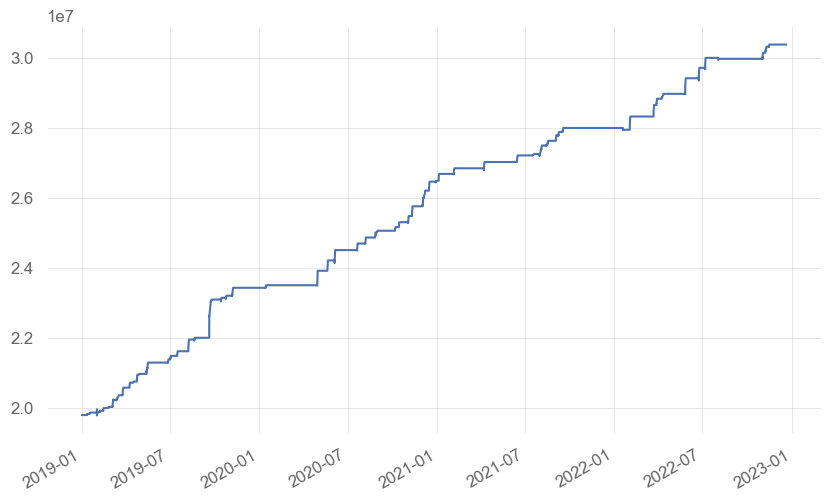

In [88]:
# Filter columns for position and return
position_columns = [col for col in combined_df.columns if 'position' in col]
return_columns = [col for col in combined_df.columns if '_ret' in col]

# Calculate the sum of returns for assets where position is non-zero
combined_df['sum_of_rturns'] = combined_df[return_columns].sum(axis=1)

# Count the number of non-zero positions for each row
combined_df['non_zero_positions'] = combined_df[position_columns].apply(lambda x: (x!=0).sum(), axis=1)

symbol_Equity = (combined_df[return_columns]*100000)


total_profit_from_returns = symbol_Equity.cumsum().iloc[-1]

Portfolio_EC = len(return_columns)*100000+(symbol_Equity.sum(axis=1).cumsum())

Portfolio_EC.plot()

In [89]:
Portfolio_EC

2019-01-01 09:15:00   19800000.00
2019-01-01 09:45:00   19800000.00
2019-01-01 10:15:00   19800000.00
2019-01-01 10:45:00   19800000.00
2019-01-01 11:15:00   19800000.00
                          ...    
2022-12-20 13:15:00   30391585.38
2022-12-20 13:45:00   30391585.38
2022-12-20 14:15:00   30391585.38
2022-12-20 14:45:00   30391585.38
2022-12-20 15:15:00   30391585.38
Length: 12746, dtype: float64

<Axes: >

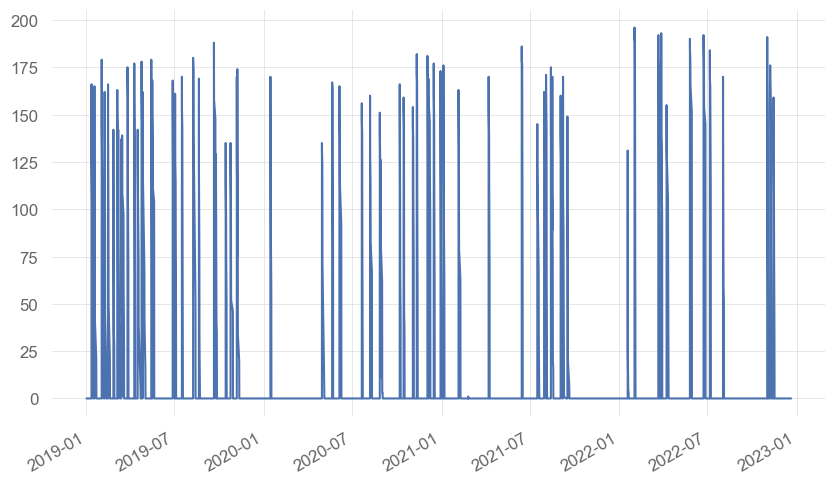

In [84]:
combined_df['non_zero_positions'].plot()
